In [2]:
import pandas as pd
import numpy as np
import sklearn
import openpyxl
import json
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsRegressor, LocalOutlierFactor, NearestNeighbors
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, max_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import OneClassSVM
from sklearn import preprocessing

In [3]:
# chemical_composition = ['C', 'Si', 'Mn', 'Cu', 'Ni', 'Mo','Cr', 'V']
chemical_composition = ['C', 'Si', 'Mn', 'Cu', 'Ni', 'Mo']
heat_treatment = ['aust_temp', 'aust_czas', 'ausf_temp', 'ausf_czas']
physical_properties = ['Rm', 'Rp02', 'A5', 'HB', 'K']
additional_features = ['grubosc']
all_cols = chemical_composition + heat_treatment + additional_features + physical_properties

In [4]:
!rm zebrane-dane-2.xlsx
!wget https://github.com/somas3k/master_thesis/raw/master/zebrane-dane-2.xlsx
excel_data_path = "zebrane-dane-2.xlsx"
df_org = pd.read_excel(excel_data_path, sheet_name="Dane", header=1, usecols=all_cols)
df_org

--2020-11-19 23:30:47--  https://github.com/somas3k/master_thesis/raw/master/zebrane-dane-2.xlsx
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/somas3k/master_thesis/master/zebrane-dane-2.xlsx [following]
--2020-11-19 23:30:48--  https://raw.githubusercontent.com/somas3k/master_thesis/master/zebrane-dane-2.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502418 (491K) [application/octet-stream]
Saving to: ‘zebrane-dane-2.xlsx’

zebrane-dane-2.xlsx 100%[===================>] 490.64K   673KB/s    in 0.7s    

2020-11-19 23:30:49 (673 KB/s) - ‘zebrane-dane-2.xlsx’ saved [502418/502418]



,C,Si,Mn,Cu,Ni,Mo,aust_temp,aust_czas,ausf_temp,ausf_czas,Rm,Rp02,A5,HB,K,grubosc
0,3.40,2.30,0.17,0.70,1.50,0.24,900,120,240,120,1507.0,1072.0,2.8,429.0,54.4,25
1,3.40,2.30,0.17,0.70,1.50,0.24,900,120,270,120,1307.0,936.0,4.1,388.0,71.6,25
2,3.40,2.30,0.17,0.70,1.50,0.24,900,120,310,120,1132.0,804.0,5.4,341.0,84.4,25
3,3.40,2.30,0.17,0.70,1.50,0.24,900,120,360,120,1028.0,652.0,10.0,285.0,123.6,25
4,3.52,2.87,0.22,0.73,1.55,0.00,850,120,390,90,1064.9,NaN,15.4,296.8,NaN,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,3.97,1.57,0.49,0.00,0.00,0.00,850,30,370,60,NaN,NaN,NaN,NaN,51.0,25
685,3.97,1.57,0.49,0.00,0.00,0.00,850,30,400,60,NaN,NaN,NaN,NaN,30.0,25
686,3.97,1.57,0.49,0.00,0.00,0.00,950,15,340,60,NaN,NaN,NaN,NaN,28.0,25
687,3.97,1.57,0.49,0.00,0.00,0.00,950,15,370,60,NaN,NaN,NaN,NaN,48.5,25


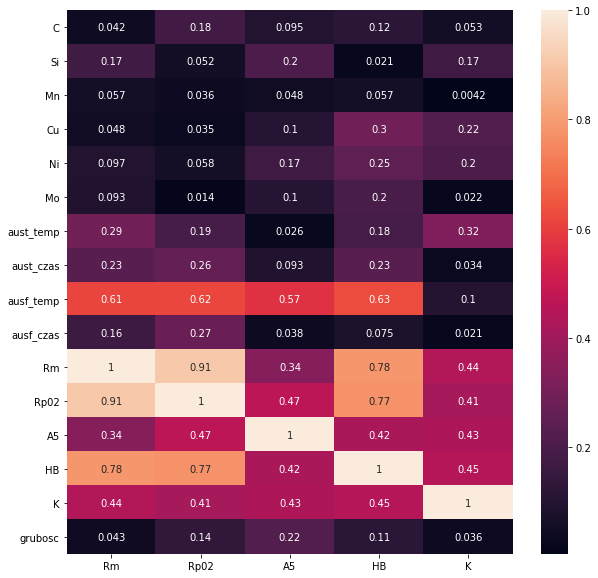

In [259]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt


corrMatrix = df_org.corr().abs()[physical_properties]
plt.figure(figsize=(10,10))
sn.heatmap(corrMatrix, annot=True)

plt.show()

In [5]:
def evaluate(model, X, y, label= "", save_predictions=False):
    print('Model Performance')
    pred_train_rf= model.predict(X)
    print('{} RMSE = {:0.2f}.'.format(label, np.sqrt(mean_squared_error(y,pred_train_rf))))
    print('{} RMAE = {:0.2f}.'.format(label, np.sqrt(mean_absolute_error(y,pred_train_rf))))
    print('{} Max error  = {:0.2f}.'.format(label, max_error(y, pred_train_rf)))
    print('{} R2 = {:0.2f}.'.format(label, r2_score(y, pred_train_rf)))
    if save_predictions:
        train = pd.DataFrame()
        train['y'] = y
        train['y_pred'] = pred_train_rf
        train.to_csv("{}_y_comp_rf.csv".format(label))

In [6]:
def get_rows_to_evaluate(df, frac, props):
    rows_to_evaluate = {}
    for i, prop in enumerate(props):
        df_without_singles = df[df[physical_properties].apply(lambda row: row.count() >= 2, axis=1)]
        df_test = df_without_singles[[prop]].dropna().sample(frac=frac, random_state=i*17)
        df.loc[df_test.index, prop] = None
        rows_to_evaluate[prop] = df_test
    return rows_to_evaluate

In [7]:
df = df_org.copy()
rows_to_evaluate = get_rows_to_evaluate(df, 0.05, physical_properties)
for key, value in rows_to_evaluate.items():
#     print(key)
    print(value.count())

Rm    21
dtype: int64
Rp02    15
dtype: int64
A5    21
dtype: int64
HB    18
dtype: int64
K    11
dtype: int64


In [68]:
def get_n_correlated_features_without(corrs, n, without):
    correlated_to_check = list(corrs.sort_values(ascending=False).index.values[1:])
    correlated = []
    for corr in correlated_to_check:
        if len(correlated) < n and corr not in without:
            correlated.append(corr)
    return correlated

def get_features_above_corr_coef(corrs, amount_of_feats_to_reg, corr_cutoff):
    features = []
#     sum = 0.0
    corrs = corrs.dropna()
    for index, corr in corrs.map(abs).items():
        if corr >= corr_cutoff:
            features.append(index)
#     if sum/len(features) >= corr_cutoff:
    if len(features) == corrs.size:
        return features  
    return []

# parametry wejściowe
# row - próbka ze zbioru danych
# df - zbiór danych
# prop - uzupełniany wymiar
# corr_cutoff- próg współczynnika korelacji  wśród sąsiadów
# req_neighs - wymagana ilość sąsiadów na podstawie których zostanie wyliczona brakująca wartość
# linear_reg_to - próg stosowania regresji liniowej do obliczenia brakującej wartości
# amount_of_feats_to_reg - ilość wymiarów, na podstawie której przewidywana jest brakująca wartość
# order - lista uzupełnianych wymiarów określająca ich kolejność przetwarzania
def fill(row, prop, df, req_neighs, linear_reg_to, amount_of_feats_to_reg, corr_cutoff, next_predictor_provider):
    if not np.isnan(row[prop]): # jeżeli wartość dla uzupełnianego wymiaru istnieje
        return [row[prop], None, None, None, None, None, None]
    physical_properties = ['Rm', 'Rp02', 'A5', 'HB', 'K']
    heat_treatment = ['aust_temp', 'aust_czas', 'ausf_temp', 'ausf_czas']
    important_features = set(['Mn', 'Cu', 'Ni', 'Mo'] + heat_treatment)
    nan_features = list(row[row.isnull()].index.values) # wyznacz wymiary, dla których nie ma wartości
    nan_features.remove(prop) # usuń wymiar, dla którego będzie przewidywana brakująca wartość
    correlated = get_n_correlated_features_without(df.corr()[prop].map(abs), amount_of_feats_to_reg, nan_features) # wyznacz n najbardziej skorelowanych wymiarów do rozpatrywanego wymiaru poza wymiarami, dla których nie ma wartości (gdzie n oznacza ilość wymiarów, na podstawie której przewidywana jest brakująca wartość)    
    not_correlated = set(df.columns) - set(correlated) # wyznacz nieskorelowane wymiary - różnica zbioru wszystkich wymiarów i zbioru wymiarów skorelowanych
    not_correlated = not_correlated - set(physical_properties) # usuń ze zbioru wymiary uzupełniane
    # not_correlated = set(df.columns) - set(correlated)
    not_correlated = set(df[not_correlated].dropna(axis=1).columns) # usuń ze zbioru wymiary, dla których nie ma wartości
    # not_correlated = not_correlated.intersection(important_features)
    X = df[not_correlated].values # dataset nieskorelowanych danych
    scaler = MinMaxScaler().fit(X) # skalowanie datasetu MinMaxem
    X = scaler.transform(X)
    neighs = req_neighs # ilość szukanych sąsiadów, początkowo ilość wymaganych
    while True:
        # znajdz najblizszych sasiadow na podstawie odleglosci euklidesowej
        nbrs = NearestNeighbors(n_neighbors=neighs, algorithm = 'brute').fit(X)
        index_to_reg = list(nbrs.kneighbors(scaler.transform([row[not_correlated]]))[1][0][1:])
        df_to_reg = df.iloc[index_to_reg]
        
        df_to_reg = df_to_reg.dropna(subset=correlated+[prop]) #usuń sąsiadów, którzy nie zawierają wszystkich wartości
        neighs+=(req_neighs - df_to_reg.shape[0]) #zwiększ ilosc szukanych sasiadow o ilość usuniętych
        if df_to_reg.shape[0] >= req_neighs: # jezeli ilosc znalezionych sasiadow jest rowna badz wieksza ilosci wymaganych sasiadow
            break
    correlated = set(correlated)
    correlated.discard(prop) #usun ze zbioru skorelowanych akrualnie uzupelniany wymiar
    corrs = df_to_reg.corr()[prop][correlated] #wyznacz korelacje do aktualnie rozpatrywanego wymiaru wśród znalezionych sąsiadów
    
    corr_tmp = list(correlated)
    correlated = get_features_above_corr_coef(corrs, amount_of_feats_to_reg, corr_cutoff) #wyznacz n wymiarow z najwyzszym współczynnikiem korelacji, dla których średnia wartości współczynników korelacji przekracza lub jest równa progowi (n - ilość wymiarów na podstawie której przewidywana jest brakująca wartość)
    
    # jezeli ilosc wymiarow jest rowna zeru
    if len(correlated) == 0:
#         if corr_cutoff < 0.1:
#             print('---------No features fulfill reqs to be correlated for row {} when imputing {} with correlated features {} and corrs {}'.format(str(row), str(prop), str(corr_tmp), str(corrs)))
        return [None, None, None, None, None, None, None]
    to_reg_X, to_reg_y = df_to_reg[correlated].values, df_to_reg[prop].values
    # jezeli prog korelacji jest wiekszy lub rowny progu stosowania regresji liniowej 
    if corr_cutoff >= linear_reg_to:
        predictor = LinearRegression()
    else:
        predictor = next_predictor_provider()
    # naucz model przewidujacy na podstawie próbek ze znalezionych sasiadów
    reg_model = predictor.fit(to_reg_X, to_reg_y)
    
    # wyznacz brakującą wartość wykorzystując wyuczony model
    try:
        predicted = reg_model.predict([row[correlated].values])[0]
    except:
        print(prop)
        print(correlated)
        print(row[correlated].values)
        print(corrs)
    # jeżeli przewidziana wartośc jest mniejsz od zera
    if predicted <= 0:
#         if corr_cutoff < 0.1:
#             print('---------Value below 0 for row {} when imputing {} with correlated features {}'.format(str(row), str(prop), str(correlated)))
        return [None, None, None, None, None, None, None]
    # zwróć uzupełnioną wartość
    return [predicted, not_correlated, df_to_reg.shape[0], list(corrs[correlated].index.values), list(corrs[correlated].values), [min(to_reg_y), max(to_reg_y)], list(df_to_reg.index.values)]
    

def impute_missing(prop, df: DataFrame, req_neighs, linear_reg_to, amount_of_feats_to_reg, corr_cutoff, next_predictor_provider):
    return df.apply(axis=1, func=fill, args=[prop, df, req_neighs, linear_reg_to, amount_of_feats_to_reg, corr_cutoff, next_predictor_provider], result_type='expand')

from functools import reduce

def get_amount_of_missing(dff, props):
    return dff.shape[0] * len(props) - reduce((lambda x, y: x + y), map(lambda prop: dff.describe()[prop].loc['count'], props))

# parametry wejściowe
# df - zbiór danych
# corr_cutoff_bound - początkowy próg korelacji  wśród sąsiadów
# req_neighs - wymagana ilość sąsiadów na podstawie których zostanie wyliczona brakująca wartość
# linear_reg_to - próg stosowania regresji liniowej do obliczenia brakującej wartości
# amount_of_feats_to_reg - ilość wymiarów, na podstawie której przewidywana jest brakująca wartość
# order - lista uzupełnianych wymiarów określająca ich kolejność przetwarzania
def filling(df, corr_cutoff_bound, req_neighs, linear_reg_to, amount_of_feats_to_reg, order, next_predictor_provider):
    # 1. inicjalizacja zmiennych
    corr_cutoff = corr_cutoff_bound # próg korelacji
    max_steps = 30 # maksymalna ilość kroków algorytmu
    df_filled = df.copy()
    missing_values = get_amount_of_missing(df_filled, order) # ilość brakujących wartości
#     print('Missing values: ' + str(missing_values))
    filling_info = {} 
    step = 1 #krok
    #import shutil
    #shutil.copy2("zebrane-dane-2.xlsx", "zebrane-dane-2-filled.xlsx")
    while True:
#         print('Step {} with corr cutoff {}'.format(step, corr_cutoff))
        filled = 0 #ilośc wypełnionych wymiarów
        for prop in order: #dla kazdego wypelnianego wymiaru
            if df_filled.describe()[prop].loc['count'] == df_filled.shape[0]: #jesli wszystkie wartosci w danym wymiarze zostaly uzupelnione
                filled+=1
                continue
            df_new = DataFrame() 
            df_new[prop] = df_filled[prop]
            returned_cols = [prop + '_imp', 'Features to find neighs', 'Amount of neighs', 'Correlated features', 'Correlation coefficients', 'Min_max', 'Neighs indexes']
            df_new[returned_cols] = impute_missing(prop, df_filled, req_neighs, linear_reg_to, amount_of_feats_to_reg, corr_cutoff, next_predictor_provider) #dla kazdego wiersza wykonaj procedure uzupełniania brakującyh wartości w zakresie aktualnie uzupełnianego wymiaru

#             print('Finished imputing for {}'.format(prop))
            df_filled[prop] = df_new[prop + '_imp']
            df_new.loc[df_new[prop].isna() & df_new[prop + '_imp'].notna(), 'step'] = step
            new_rows = df_new[df_new[prop].isna() & df_new[prop + '_imp'].notna()]
            if prop not in filling_info:
                filling_info[prop] = df_new
            else:
                filling_info[prop] = filling_info[prop].combine_first(new_rows)
        if filled == len(order) or step >= max_steps or corr_cutoff < 0.0: #jezeli wszystkie wymiary zostaly uzupełnione
            break
        step+=1 # inkrementuj krok
        actually_missing = get_amount_of_missing(df_filled, order) # akrualna ilosc brakujacych wartosci po kroku uzupelniania
        if missing_values == actually_missing: # jezeli ilosc brakujach wartosci nie zmniejszyla sie
            corr_cutoff = corr_cutoff - 0.05 # zmniejsz prog wartosci korelacji o 0.05
        missing_values = actually_missing #zaktualizuj ilosc brakujacych wartosci
#         print('Still missing: ' + str(missing_values))
        

#     for prop in order:  
#         with pd.ExcelWriter("zebrane-dane-2-filled.xlsx", engine="openpyxl", mode='a') as writer:
#             filling_info[prop].sort_index().to_excel(writer,  sheet_name="imputed_{}".format(prop))
    return [df_filled, filling_info]

In [18]:
# from multiprocessing import Pool
from sklearn.model_selection import ParameterGrid

params_grid_5_20= {
    'df': [df],
    'corr_cutoff_bound': [0.85, 0.9, 0.95],
    'req_neighs': [5, 20],
    'linear_reg_to': [0.65, 0.75, 0.85],
    'amount_of_feats_to_reg': [1, 2]
}
params_grid_10_15 = {
    'df': [df],
    'corr_cutoff_bound': [0.85, 0.9, 0.95],
    'req_neighs': [10, 15],
    'linear_reg_to': [0.65, 0.75, 0.85],
    'amount_of_feats_to_reg': [1, 2]
}

params_grid_3_feats = {
    'df': [df],
    'corr_cutoff_bound': [0.85, 0.9, 0.95],
    'req_neighs': [5, 10, 15, 20],
    'linear_reg_to': [0.65, 0.75, 0.85],
    'amount_of_feats_to_reg': [3]
}
# params_grid = {
#     'df': [df],
#     'corr_cutoff_bound': [0.85],
#     'req_neighs': [5],
#     'linear_reg_to': [0.65],
#     'amount_of_feats_to_reg': [3]
# }
params_grid = {
    'df': [df],
    'corr_cutoff_bound': [0.85, 0.9, 0.95],
    'req_neighs': [5, 10, 20],
    'linear_reg_to': [0.7, 0.85],
    'amount_of_feats_to_reg': [1, 2],
    'order': [['HB', 'Rm', 'Rp02', 'A5', 'K'], ['Rp02', 'HB', 'Rm', 'K', 'A5']],
    'next_predictor_provider': [lambda: LinearRegression(), lambda: DecisionTreeRegressor()]
}

# params_list_5_20 = list(ParameterGrid(params_grid_5_20))
# params_list_10_15 = list(ParameterGrid(params_grid_10_15))
# params_list_3_feats = list(ParameterGrid(params_grid_3_feats))
# params_list = params_list_5_20
# params_list.extend(params_list_10_15)
# params_list.extend(params_list_3_feats)
params_list = list(ParameterGrid(params_grid))
print(len(params_list))
# for params in params_list:
#     params.pop('df')

144


In [71]:
params_list = [
    {'df': df, 'amount_of_feats_to_reg': 1, 'corr_cutoff_bound': 0.95, 'linear_reg_to': 0.85,'next_predictor_provider': lambda: DecisionTreeRegressor(), 'order': ['HB', 'Rm', 'Rp02', 'A5', 'K'], 'req_neighs':10},
    {'df': df, 'amount_of_feats_to_reg': 1, 'corr_cutoff_bound': 0.95, 'linear_reg_to': 0.85 ,'next_predictor_provider': lambda: LinearRegression(), 'order': ['HB', 'Rm', 'Rp02', 'A5', 'K'], 'req_neighs':10},
    {'df': df, 'amount_of_feats_to_reg': 1, 'corr_cutoff_bound': 0.95, 'linear_reg_to': 0.7,'next_predictor_provider': lambda: LinearRegression(), 'order': ['HB', 'Rm', 'Rp02', 'A5', 'K'], 'req_neighs':20},
    {'df': df, 'amount_of_feats_to_reg': 1, 'corr_cutoff_bound': 0.95, 'linear_reg_to': 0.7,'next_predictor_provider': lambda: DecisionTreeRegressor(), 'order': ['HB', 'Rm', 'Rp02', 'A5', 'K'], 'req_neighs':10},
    {'df': df, 'amount_of_feats_to_reg': 1, 'corr_cutoff_bound': 0.9, 'linear_reg_to': 0.7,'next_predictor_provider': lambda: LinearRegression(), 'order': ['Rp02', 'HB', 'Rm', 'K', 'A5'], 'req_neighs':20},
    {'df': df, 'amount_of_feats_to_reg': 1, 'corr_cutoff_bound': 0.9, 'linear_reg_to': 0.7,'next_predictor_provider': lambda: DecisionTreeRegressor(), 'order': ['Rp02', 'HB', 'Rm', 'K', 'A5'], 'req_neighs':10},
    {'df': df, 'amount_of_feats_to_reg': 2, 'corr_cutoff_bound': 0.95, 'linear_reg_to': 0.85,'next_predictor_provider': lambda: LinearRegression(), 'order': ['HB', 'Rm', 'Rp02', 'A5', 'K'], 'req_neighs': 10},
    {'df': df, 'amount_of_feats_to_reg': 2, 'corr_cutoff_bound': 0.95, 'linear_reg_to': 0.7,'next_predictor_provider': lambda: DecisionTreeRegressor(), 'order': ['HB', 'Rm', 'Rp02', 'A5', 'K'], 'req_neighs':10},
    {'df': df, 'amount_of_feats_to_reg': 2, 'corr_cutoff_bound': 0.95, 'linear_reg_to': 0.7,'next_predictor_provider': lambda: LinearRegression(), 'order': ['HB', 'Rm', 'Rp02', 'A5', 'K'], 'req_neighs':20},
    {'df': df, 'amount_of_feats_to_reg': 1, 'corr_cutoff_bound': 0.85, 'linear_reg_to': 0.7,'next_predictor_provider': lambda: LinearRegression(), 'order': ['Rp02', 'HB', 'Rm', 'K', 'A5'], 'req_neighs':10},
    {'df': df, 'amount_of_feats_to_reg': 1, 'corr_cutoff_bound': 0.85, 'linear_reg_to': 0.85,'next_predictor_provider': lambda: LinearRegression(), 'order': ['HB', 'Rm', 'Rp02', 'A5', 'K'], 'req_neighs':5},
    {'df': df, 'amount_of_feats_to_reg': 1, 'corr_cutoff_bound': 0.85, 'linear_reg_to': 0.7,'next_predictor_provider': lambda: LinearRegression(), 'order': ['Rp02', 'HB', 'Rm', 'K', 'A5'], 'req_neighs':20},
    {'df': df, 'amount_of_feats_to_reg': 1, 'corr_cutoff_bound': 0.9, 'linear_reg_to': 0.85,'next_predictor_provider': lambda: LinearRegression(), 'order': ['HB', 'Rm', 'Rp02', 'A5', 'K'], 'req_neighs':20},
    {'df': df, 'amount_of_feats_to_reg': 1, 'corr_cutoff_bound': 0.9, 'linear_reg_to': 0.7,'next_predictor_provider': lambda: DecisionTreeRegressor(), 'order': ['Rp02', 'HB', 'Rm', 'K', 'A5'], 'req_neighs':5},
    {'df': df, 'amount_of_feats_to_reg': 1, 'corr_cutoff_bound': 0.9, 'linear_reg_to': 0.7,'next_predictor_provider': lambda: LinearRegression(), 'order': ['HB', 'Rm', 'Rp02', 'A5', 'K'], 'req_neighs':5},
    {'df': df, 'amount_of_feats_to_reg': 1, 'corr_cutoff_bound': 0.85, 'linear_reg_to': 0.85,'next_predictor_provider': lambda: DecisionTreeRegressor(), 'order': ['Rp02', 'HB', 'Rm', 'K', 'A5'], 'req_neighs':5},
]
print(len(params_list))

16


In [ ]:
from tqdm import tqdm
import signal
import dill
from multiprocess import Pool


def f1(params):
    params_org = dict(params)
#     params.pop('df')
    result = filling(**params_org)
    return result

def init_worker():
    signal.signal(signal.SIGINT, signal.SIG_IGN)
    
# import multiprocessing
import dill

num_processors = 8
p = Pool(num_processors, init_worker)
result_list_tqdm = []
try:
    for result in tqdm(p.imap_unordered(func=f1, iterable=params_list), total=len(params_list)):
        result_list_tqdm.append(result)
    p.close()
    p.join()
    with open('results_dump_max_30_steps', 'wb') as results_dump:
        dill.dump(result_list_tqdm, results_dump)
except KeyboardInterrupt:
    pool.terminate()
    pool.join()

 25%|██▌       | 4/16 [42:11<2:19:37, 698.13s/it] 

In [8]:
import dill
# with open('results_dump_5_20', 'rb') as results_dump_5_20:
#     results_5_20 = pickle.load(results_dump_5_20)
#     print(len(results_5_20))
# with open('results_dump_10_15', 'rb') as results_dump_10_15:
#     results_10_15 = pickle.load(results_dump_10_15)
#     print(len(results_10_15))
# with open('results_dump_3_feats', 'rb') as results_dump_3_feats:
#     results_3_feats = pickle.load(results_dump_3_feats)
#     print(len(results_3_feats))    
    
with open('results_dump_max_15_steps', 'rb') as results_dump_3_feats:
    results = dill.load(results_dump_3_feats)
    print(len(results)) 

144


In [301]:
results = list(results_5_20)
results.extend(results_10_15)
results.extend(results_3_feats)

In [61]:
import numpy as np
import warnings
from functools import reduce
warnings.filterwarnings("default")

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def get_amount_of_missing(dff, props):
    return dff.shape[0] * len(props) - reduce((lambda x, y: x + y), map(lambda prop: dff.describe()[prop].loc['count'], props))

# def evaluate_filled_values(df, rows_to_test):
#     for label, df_test in rows_to_test.items():
#         df_pred = df.loc[df_test.index, label].dropna()
#         y = df_test.loc[df_pred.index, label].values
#         pred_y = df_pred.values
#         print('y:\t' + str(list(y)))
#         print('pred_y:\t' + str(list(pred_y)))
#         print('{} RMSE = {:0.2f}.'.format(label, np.sqrt(mean_squared_error(y,pred_y))))
#         print('{} RMAE = {:0.2f}.'.format(label, np.sqrt(mean_absolute_error(y,pred_y))))
#         print('{} Max error  = {:0.2f}.'.format(label, max_error(y, pred_y)))
#         print('{} MAPE  = {:0.2f}.'.format(label, mean_absolute_percentage_error(y, pred_y)))
#         print('{} R2 = {:0.2f}.'.format(label, r2_score(y, pred_y)))
#         print('------------------------------------------------------------------------')
        
params_grid = {
    'corr_cutoff_bound': [0.85, 0.9, 0.95],
    'req_neighs': [5, 10, 20],
    'linear_reg_to': [0.7, 0.85],
    'amount_of_feats_to_reg': [1, 2],
    'order': [1, 2],
    'next_predictor_provider': ['lin', 'dectree']
}        
params_list = list(ParameterGrid(params_grid))

amount_of_missing_test = 0
for key, value in rows_to_evaluate.items():
    amount_of_missing_test += value.count()[key]
    
print(amount_of_missing_test)

def evaluate_filled_values(df, rows_to_test):
    res = {}
    r2_sum = 0
    mape_sum = 0
    missing_sum = 0
    missing_test_sum = 0
    for label, df_test in rows_to_test.items():
        df_with_nans = df.loc[df_test.index, label]
        df_pred = df_with_nans.dropna()
        y = df_test.loc[df_pred.index, label].values
        pred_y = df_pred.values
        mape = mean_absolute_percentage_error(y, pred_y)
        mape_sum += mape
        res['{}_mape'.format(label)] = mape
        r2 = r2_score(y, pred_y)
        r2_sum += r2
        res['{}_r2'.format(label)] = r2
        missing_from_test = np.count_nonzero(np.isnan(df_with_nans.values))
        missing_test_sum += missing_from_test
        still_missing = get_amount_of_missing(df, [label])
        missing_sum += still_missing
        res['{}_missing_from_test'.format(label)] = missing_from_test
        res['{}_missing'.format(label)] = still_missing 
    
    res['avg_r2'] = r2_sum / 5
    res['avg_mape'] = mape_sum / 5
    res['missing_all'] = missing_sum
    res['missing_test_percent'] = missing_test_sum / amount_of_missing_test
    
    return res
        
def prepare_data_to_analyze(results, rows_to_test):
    res = []
    for i, df in enumerate(results):
        params = params_list[i]
        params.update(evaluate_filled_values(df[0], rows_to_test))
        res.append(params)
    return pd.DataFrame(res)
        

86


In [62]:
# evaluate_filled_values(results[100][0], rows_to_evaluate)
# print(results[100])
# rows_to_evaluate
df_to_analyze = prepare_data_to_analyze(results, rows_to_evaluate)

/home/sg0303587/anaconda3/envs/magisterka/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/sg0303587/anaconda3/envs/magisterka/lib/python3.8/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/sg0303587/anaconda3/envs/magisterka/lib/python3.8/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/sg0303587/anaconda3/envs/magisterka/lib/python3.8/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not we

In [57]:
df_to_analyze.sort_values(by='avg_r2', ascending=False).to_csv('df_to_analyze_r2.csv')
df_to_analyze.sort_values(by='avg_mape').to_csv('df_to_analyze_mape.csv')
df_to_analyze.sort_values(by='missing_all').to_csv('df_to_analyze_missing.csv')

In [22]:
import matplotlib.pyplot as plt

def errors_to_step(results, rows_to_evaluate):
    xs = {}
    ys = {}
    for prop in physical_properties:
        xs[prop] = []
        ys[prop] = []
    for result in results:
        df, filling_info = result[0], result[1]
        for label, df_test in rows_to_evaluate.items():
            df_pred = df.loc[df_test.index, label].dropna()
            steps = filling_info[label].loc[df_pred.index, 'step'].values
            y = df_test.loc[df_pred.index, label].values
            pred_y = df_pred.values
            errors = (abs(y-pred_y)/y)*100
            xs[label].extend(steps)
            ys[label].extend(errors)
#             print(label)
#             print(steps)
#             print(errors)
#             print('--------------------')
    for prop in physical_properties:
        plt.scatter(xs[prop], ys[prop])
        plt.title(prop)
        plt.show()

In [195]:
# errors_to_step(results, rows_to_evaluate)

In [314]:
from statistics import mean 

algo_params = ['amount_of_feats_to_reg','corr_cutoff_bound', 'linear_reg_to', 'req_neighs']
prop_to_color = {
    'Rm' : 'red',
    'Rp02': 'blue',
    'HB': 'black',
    'A5': 'green',
    'K': 'pink'
}

analyzed_props = ['Rm', 'Rp02', 'HB', 'A5']

def get_average_r2_for_param_value(param_values, r2s):
    x = []
    y = []
    for param_value in set(param_values):
        tmp = []
        for r2, param_v in zip(r2s, param_values):
            if param_value == param_v:
                tmp.append(r2)
        x.append(param_value)
        y.append(mean(tmp))
    return x, y
        

def get_r2_error(df, df_test, prop):
    df_pred = df.loc[df_test.index, prop].dropna()
    y = df_test.loc[df_pred.index, prop].values
    pred_y = df_pred.values
    return r2_score(y, pred_y)

def analyze_algo_props(results_list, params_list):
    for algo_param in algo_params:
        fig, ax = plt.subplots(1, len(analyzed_props)+1, sharey='row', figsize=(10, 5))
        fig.text(0.5, 0.04, algo_param, ha='center')
        fig.text(0.04, 0.5, 'average r2 score', va='center', rotation='vertical')
        xs = []
        ys = []
        r2_sum = 0
        for i, prop in enumerate(analyzed_props):
            x = []
            y = []
            for results, params in zip(results_list, params_list):
                try:
                    r2 = get_r2_error(results[0], rows_to_evaluate[prop], prop)
                    y.append(r2)
                    x.append(params[algo_param])
                except:
                    pass
            xs.extend(x)
            ys.extend(y)
            xy = get_average_r2_for_param_value(x, y)
            ax[i].scatter(xy[0], xy[1])
            ax[i].set_title(prop)
        xys = get_average_r2_for_param_value(xs, ys)
        ax[len(analyzed_props)].scatter(xys[0], xys[1])
        ax[len(analyzed_props)].set_title('All properties')
        plt.show()
        
def get_best_params(results_list, params_list):
    best_params = []
    for results, params in zip(results_list, params_list):
        r2_sum = 0
        r2s = []
        for prop in analyzed_props:
            try:
                r2 = get_r2_error(results[0], rows_to_evaluate[prop], prop)
                r2s.append([prop, r2])
                r2_sum = r2_sum + r2
            except:
                pass
        best_params.append([params, r2_sum, results, r2s])
    best_params.sort(key=lambda x: x[1], reverse=True)
    return best_params  

In [315]:
def get_amount_of_missing_by_prop(dff, props):
    return [[prop, dff.shape[0] - dff.describe()[prop].loc['count']] for prop in props]

# analyze_algo_props(results, params_list)
for i in range(3):
    best = get_best_params(results, params_list)[i]
    print(str(best[0]) + ' ' + str(best[3]))
    print(get_amount_of_missing_by_prop(best[2][0], ['Rm', 'Rp02', 'A5', 'HB']))


{'amount_of_feats_to_reg': 3, 'corr_cutoff_bound': 0.85, 'linear_reg_to': 0.85, 'req_neighs': 5} [['Rm', 0.7797527888710699], ['Rp02', 0.9094732384996044], ['HB', 0.7060015644160877], ['A5', 0.7453709819747434]]
[['Rm', 109.0], ['Rp02', 97.0], ['A5', 93.0], ['HB', 117.0]]
{'amount_of_feats_to_reg': 3, 'corr_cutoff_bound': 0.95, 'linear_reg_to': 0.75, 'req_neighs': 5} [['Rm', 0.8686316546173983], ['Rp02', 0.7983546143451665], ['HB', 0.5873856082206115], ['A5', 0.8459020826375931]]
[['Rm', 28.0], ['Rp02', 146.0], ['A5', 136.0], ['HB', 98.0]]
{'amount_of_feats_to_reg': 2, 'corr_cutoff_bound': 0.85, 'linear_reg_to': 0.85, 'req_neighs': 5} [['Rm', 0.7138005944809972], ['Rp02', 0.997247265169043], ['HB', 0.6613259625476089], ['A5', 0.669370584522345]]
[['Rm', 2.0], ['Rp02', 2.0], ['A5', 44.0], ['HB', 11.0]]


In [379]:
# order = ['Rp02', 'Rm', 'HB', 'K', 'A5']
from sklearn.tree import DecisionTreeRegressor
order = ['HB', 'Rm', 'Rp02', 'A5']
df = df_org.copy()
rows_to_evaluate = get_rows_to_evaluate(df, 0.03, order)
import time
t0= time.time()
res = filling(df, amount_of_feats_to_reg=2, linear_reg_to=0.85, order=order, req_neighs=5, corr_cutoff_bound=0.85, next_predictor_provider=lambda: LinearRegression())
t1 = time.time() - t0
print(t1/60)

Missing values: 1151.0
Step 1 with corr cutoff 0.85
Finished imputing for HB


KeyboardInterrupt: 

In [378]:
rows_to_eval = dict(rows_to_evaluate)
# rows_to_eval.pop('K')
with pd.ExcelWriter("filling_info.xlsx", engine="openpyxl", mode='w') as writer:
    for prop in order:  
        res[1][prop].sort_index().to_excel(writer,  sheet_name="imputed_{}".format(prop))
evaluate_filled_values(res[0], rows_to_eval)

y:	[424.3, 321.4, 366.0, 246.0, 260.5, 336.8, 251.333333333333, 234.0, 311.0, 321.666666666667, 336.0]
pred_y:	[413.7744732767633, 324.14314885491433, 351.52213435628795, 279.97141434726495, 249.76794829500457, 338.0505782243955, 254.89120105217512, 254.48626394560688, 315.8202055692807, 317.33310709601244, 321.27200906976884]
HB RMSE = 14.43.
HB RMAE = 3.33.
HB Max error  = 33.97.
HB R2 = 0.93.
------------------------------------------------------------------------
y:	[1137.0, 1026.0, 1245.0, 1116.0, 1013.0, 1043.0, 1657.0, 1089.9, 852.0, 1131.0, 1180.0, 960.2, 1154.0]
pred_y:	[1137.6639369917439, 1054.7376320976327, 1237.1478792938428, 1108.1132829848918, 1038.2885187281174, 1077.669510076909, 1246.75, 1085.9874451311855, 852.1749894372542, 1230.6918068606922, 1163.5381674577357, 982.9470018597366, 1140.885406511738]
Rm RMSE = 118.33.
Rm RMAE = 7.19.
Rm Max error  = 410.25.
Rm R2 = 0.58.
------------------------------------------------------------------------
y:	[1385.0, 833.0, 898.

In [ ]:
with pd.ExcelWriter(excel_data_path,
                    mode='a') as writer:
    df_new_rm.to_excel(writer, sheet_name="imputed")

In [ ]:
df['ausf_czas_2'] = df.apply(lambda row: row['ausf_czas']**4, axis=1)
df

,C,Si,Mn,Mg,Cu,Ni,Mo,S,P,V,...,aust_czas,ausf_temp,ausf_czas,Rm,Rp02,A5,HB,K,grubosc,log_10(ausf_czas_sec)
count,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,...,711.000000,711.000000,711.000000,711.000000,711.000000,650.000000,710.000000,692.000000,711.000000,711.000000
mean,3.482267,2.468509,0.245526,0.051046,0.582959,0.757358,0.080327,0.011460,0.034224,0.000852,...,94.774965,335.552743,135.053446,1132.380020,914.584039,5.734204,348.332852,82.231034,28.803094,3.768979
std,0.166609,0.223651,0.098214,0.029140,0.572900,0.634207,0.117780,0.006368,0.075171,0.005667,...,38.686424,43.394421,147.029622,192.603586,210.893653,3.563061,55.001321,38.271770,13.540676,0.339365
min,3.070000,1.570000,0.061000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,15.000000,240.000000,10.000000,588.000000,379.000000,-17.596499,180.529925,-17.005376,13.000000,2.778151
25%,3.400000,2.320000,0.180000,0.042000,0.002000,0.090000,0.000000,0.008000,0.015000,0.000000,...,60.000000,300.000000,60.000000,998.500000,774.000000,3.228295,309.412122,57.500000,25.000000,3.556303
50%,3.500000,2.500000,0.230000,0.048000,0.500000,0.820000,0.010000,0.010000,0.022000,0.000000,...,90.000000,340.000000,120.000000,1116.000000,889.010873,5.500000,341.690325,78.578873,25.000000,3.857332
75%,3.580000,2.570000,0.300000,0.055000,1.000000,1.500000,0.150000,0.013000,0.029000,0.000000,...,120.000000,370.000000,180.000000,1261.429772,1051.877018,7.900000,388.136764,106.000000,25.000000,4.033424
max,3.970000,3.090000,0.610000,0.500000,1.600000,1.900000,0.500000,0.125000,0.650000,0.050000,...,180.000000,450.000000,1440.000000,1657.000000,1655.779514,19.900000,498.000000,255.500000,100.000000,4.936514


In [ ]:
with pd.ExcelWriter(excel_data_path,
                    mode='a') as writer:
    df_new_rm.to_excel(writer, sheet_name="imputed")

NameError: name 'df_new_rm' is not defined

In [ ]:
df['ausf_czas_2'] = df.apply(lambda row: row['ausf_czas']**4, axis=1)
df

,C,Si,Mn,Mg,Cu,Ni,Mo,S,P,Cr,...,ausf_czas,Rm,Rp02,A5,HB,K,grubosc,aust_temp_2,ausf_temp_2,ausf_czas_2
0,3.40,2.30,0.17,0.047,0.70,1.50,0.24,0.010,0.034,0.0,...,120,1507.0,1072.0,2.8,429.0,54.4,25,810000.0,57600.0,2.073600e+08
1,3.40,2.30,0.17,0.047,0.70,1.50,0.24,0.010,0.034,0.0,...,120,1307.0,936.0,4.1,388.0,71.6,25,810000.0,72900.0,2.073600e+08
2,3.40,2.30,0.17,0.047,0.70,1.50,0.24,0.010,0.034,0.0,...,120,1132.0,804.0,5.4,341.0,84.4,25,810000.0,96100.0,2.073600e+08
3,3.40,2.30,0.17,0.047,0.70,1.50,0.24,0.010,0.034,0.0,...,120,1028.0,652.0,10.0,285.0,123.6,25,810000.0,129600.0,2.073600e+08
4,3.52,2.87,0.22,0.051,0.73,1.55,0.00,0.017,0.650,0.0,...,90,1064.9,NaN,15.4,296.8,NaN,25,722500.0,152100.0,6.561000e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,3.07,2.15,0.26,0.043,1.60,1.50,0.00,0.010,0.020,0.0,...,60,1131.0,NaN,5.3,NaN,46.0,25,810000.0,122500.0,1.296000e+07
472,3.07,2.15,0.26,0.043,1.60,1.50,0.00,0.010,0.020,0.0,...,120,1128.5,NaN,9.9,NaN,89.5,25,810000.0,122500.0,2.073600e+08
473,3.07,2.15,0.26,0.043,1.60,1.50,0.00,0.010,0.020,0.0,...,180,1082.5,NaN,11.1,NaN,121.5,25,810000.0,122500.0,1.049760e+09
474,3.07,2.15,0.26,0.043,1.60,1.50,0.00,0.010,0.020,0.0,...,240,1041.5,NaN,10.1,NaN,105.0,25,810000.0,122500.0,3.317760e+09


In [ ]:
df_new = DataFrame()
to_impute = physical_properties
df_tmp = df.query("obrobka_produkcyjna==1")
for prop in to_impute:
    print(prop)
    df_new[prop] = impute_missing(prop, df_tmp,
                                    ['Cu', 'Ni', 'Mo'] + heat_treatment + ['grubosc'],
                                    LinearRegression())

Rm
Model Performance
Rm RMSE = 119.72.
Rm RMAE = 9.57.
Rm Max error  = 460.05.
Rm R2 = 0.57.
Rp02
Model Performance
Rp02 RMSE = 130.81.
Rp02 RMAE = 9.96.
Rp02 Max error  = 422.33.
Rp02 R2 = 0.59.
A5
Model Performance
A5 RMSE = 2.51.
A5 RMAE = 1.40.
A5 Max error  = 7.74.
A5 R2 = 0.38.
HB
Model Performance
HB RMSE = 28.24.
HB RMAE = 4.58.
HB Max error  = 99.37.
HB R2 = 0.76.
K
Model Performance
K RMSE = 27.39.
K RMAE = 4.69.
K Max error  = 73.69.
K R2 = 0.41.


In [ ]:
with pd.ExcelWriter(excel_data_path,
                    mode='a') as writer:
    df_new.to_excel(writer, sheet_name="imputed_random_forest")

In [ ]:
def increase_degree(df, predictors, degree):
    new_predictors = []
    for predictor in predictors:
        new_predictors.append(predictor)
        for i in range(2, degree+1):
            new_predictor = '{}^{}'.format(predictor, str(i))
            new_predictors.append(new_predictor)
            df['{}^{}'.format(predictor, str(i))] = df.apply(lambda row: row[predictor]**i, axis=1)
    return new_predictors

In [ ]:
def find_max_error(true_values, predicted_values):
    max_error = 0
    t, p = None, None
    for true, predicted in zip(list(true_values), list(predicted_values.ravel())):
        error = abs(true-predicted)
        if error > max_error:
            max_error = error
            t, p = true, predicted
    return t, p        

In [206]:
# df_comp = pd.read_excel(excel_data_path, sheet_name="Dane", header=1, usecols=all_cols)
df_comp = df_org.copy()
# df_comp = df_comp.query('kompletny==1')
# predictors_to_inc_degree = ['Mn', 'Cu', 'Ni', 'Mo'] + heat_treatment + []
predictors_to_inc_degree = chemical_composition + heat_treatment

new_predictors = predictors_to_inc_degree
# new_predictors = increase_degree(df_comp, predictors_to_inc_degree, 2)
# df_comp['grubosc^-1'] = df_comp.apply(lambda row: 1.0/(row['grubosc']), axis=1)
# other_predictors += ['grubosc^-1']
# df_comp['ausf_temp_scaled'] = MinMaxScaler().fit_transform(df_comp['ausf_temp'].values.reshape(-1, 1))
df_comp['log_10(ausf_czas_sec)'] = df_comp.apply(lambda row: np.log10(row['ausf_czas']*60), axis=1)
other_predictors = ['grubosc']
generated_predictors = ['log_10(ausf_czas_sec)']
predictors = new_predictors + other_predictors + generated_predictors
target_column = "HB"
df_comp[predictors+[target_column]].describe()

,C,Si,Mn,Mg,Cu,Ni,Mo,S,P,Cr,V,CE,aust_temp,aust_czas,ausf_temp,ausf_czas,grubosc,log_10(ausf_czas_sec),HB
count,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000,500.000000
mean,3.475039,2.467228,0.242335,0.051302,0.600122,0.778710,0.080976,0.011302,0.034579,0.011771,0.000880,4.308975,898.416546,95.885341,335.219158,122.442671,28.924528,3.764736,346.938721
std,0.164055,0.227081,0.097739,0.029566,0.573733,0.632711,0.119591,0.006397,0.076337,0.040806,0.005755,0.182115,30.764849,38.789083,43.768782,88.824935,13.738107,0.301986,70.982847
min,3.070000,1.570000,0.061000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.793333,827.000000,15.000000,240.000000,10.000000,13.000000,2.778151,135.000000
25%,3.400000,2.320000,0.180000,0.042000,0.001000,0.090000,0.000000,0.008000,0.015000,0.000000,0.000000,4.198333,900.000000,60.000000,300.000000,60.000000,25.000000,3.556303,300.525000
50%,3.500000,2.500000,0.230000,0.049000,0.500000,0.950000,0.001000,0.010000,0.021000,0.000000,0.000000,4.293333,900.000000,90.000000,340.000000,120.000000,25.000000,3.857332,341.000000
75%,3.570000,2.570000,0.280000,0.055000,1.000000,1.500000,0.150000,0.013000,0.030000,0.020000,0.000000,4.441667,910.000000,120.000000,370.000000,180.000000,25.000000,4.033424,403.272727
max,3.970000,3.090000,0.610000,0.500000,1.600000,1.900000,0.500000,0.125000,0.650000,0.500000,0.050000,4.833333,982.000000,180.000000,450.000000,800.000000,100.000000,4.681241,615.000000


In [13]:
def round_to(series, val, limit):
    if limit == 'min':
        l = series.min()
        return l + ((val - l % val) if l % val else 0)
    if limit == 'max':
        l = series.max()
        return l - (l % val)

def get_possible_values_list(min_val, max_val, step):
    return list(np.linspace(min_val, max_val, int((max_val - min_val)/step) + 1))

df_comp = df_org.copy()
compositions = set([json.dumps(dict) for dict in df_comp[chemical_composition].to_dict('records')])
compositions = list([json.loads(comp) for comp in compositions])
for i, comp in enumerate(compositions):
    comp['id'] = i
temps = ['aust_temp', 'ausf_temp']
temp_step = 5
time_step = 15

min_aust_temp = round_to(df_comp['aust_temp'], temp_step, 'min')
max_aust_temp = round_to(df_comp['aust_temp'], temp_step, 'max')
min_ausf_temp = round_to(df_comp['ausf_temp'], temp_step, 'min')
max_ausf_temp = round_to(df_comp['ausf_temp'], temp_step, 'max')
min_aust_time = round_to(df_comp['aust_czas'], time_step, 'min')
max_aust_time = round_to(df_comp['aust_czas'], time_step, 'max')
min_ausf_time = round_to(df_comp['ausf_czas'], time_step, 'min')
max_ausf_time = round_to(df_comp['ausf_czas'], time_step, 'max')
possible_values = {
    'chemicalCompositions' : compositions,
    'possibleAustTemps' : get_possible_values_list(min_aust_temp, max_aust_temp, temp_step),
    'possibleAustTimes' : get_possible_values_list(min_aust_time, max_aust_time, time_step),
    'possibleAusfTemps' : get_possible_values_list(min_ausf_temp, max_ausf_temp, temp_step),
    'possibleAusfTimes' : get_possible_values_list(min_ausf_time, max_ausf_time, time_step),
}
with open('possible_values.json', 'w') as f:
    json.dump(possible_values, f)

In [207]:
df_before_scaling = df_comp.copy()
df_comp[predictors] = MinMaxScaler(feature_range=(-0.5, 0.5)).fit_transform(df_comp[predictors])
# df_comp[['Rm_w']] = MinMaxScaler().fit_transform(df_comp[['Rm_w']])
df_tmp = df_comp.copy()
df_comp = df_comp[predictors + [target_column]].dropna()
df_comp

,C,Si,Mn,Mg,Cu,Ni,Mo,S,P,Cr,V,CE,aust_temp,aust_czas,ausf_temp,ausf_czas,grubosc,log_10(ausf_czas_sec),HB
0,-0.133333,-0.019737,-0.301457,-0.443750,-0.06250,0.289474,-0.02,-0.420,-0.447692,-0.5,-0.5,-0.130128,-0.029032,0.136364,-0.500000,-0.360759,-0.362069,0.067068,429.0
1,-0.133333,-0.019737,-0.301457,-0.443750,-0.06250,0.289474,-0.02,-0.420,-0.447692,-0.5,-0.5,-0.130128,-0.029032,0.136364,-0.357143,-0.360759,-0.362069,0.067068,388.0
2,-0.133333,-0.019737,-0.301457,-0.443750,-0.06250,0.289474,-0.02,-0.420,-0.447692,-0.5,-0.5,-0.130128,-0.029032,0.136364,-0.166667,-0.360759,-0.362069,0.067068,341.0
3,-0.133333,-0.019737,-0.301457,-0.443750,-0.06250,0.289474,-0.02,-0.420,-0.447692,-0.5,-0.5,-0.130128,-0.029032,0.136364,0.071429,-0.360759,-0.362069,0.067068,285.0
4,0.000000,0.355263,-0.210383,-0.435417,-0.04375,0.315789,-0.50,-0.364,0.500000,-0.5,-0.5,0.365385,-0.351613,0.136364,0.214286,-0.398734,-0.362069,0.001417,296.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,-0.011111,0.361842,0.372495,-0.431250,-0.50000,-0.500000,-0.50,-0.404,-0.500000,-0.5,-0.5,0.150641,0.293548,-0.136364,0.119048,-0.436709,-0.362069,-0.091112,302.5
678,-0.011111,0.361842,0.372495,-0.431250,-0.50000,-0.500000,-0.50,-0.404,-0.500000,-0.5,-0.5,0.150641,0.293548,-0.136364,0.261905,-0.436709,-0.362069,-0.091112,267.5
679,-0.011111,0.361842,0.372495,-0.431250,-0.50000,-0.500000,-0.50,-0.404,-0.500000,-0.5,-0.5,0.150641,-0.351613,-0.136364,-0.023810,-0.436709,-0.362069,-0.091112,330.0
680,-0.011111,0.361842,0.372495,-0.431250,-0.50000,-0.500000,-0.50,-0.404,-0.500000,-0.5,-0.5,0.150641,-0.351613,-0.136364,0.119048,-0.436709,-0.362069,-0.091112,292.5


In [208]:
X = df_comp[predictors].values
# weights = df_comp[['Rm_w']].values
y = df_comp[target_column].values

In [245]:
bins = np.linspace(y.min()-0.1, y.max()+0.1, 6)
# bins = [-1, 2.7, 4.7, 6.6, 8.6, 100] #a5
# bins = [0, 710, 820, 910, 1100, 2000] #rp02
# bins = [0, 52, 75, 90, 110, 300] #k
bins = [0, 286, 325, 370, 415, 1000] #hb

y_binned = np.digitize(y, bins)
bins

[0, 286, 325, 370, 415, 1000]

<AxesSubplot:>

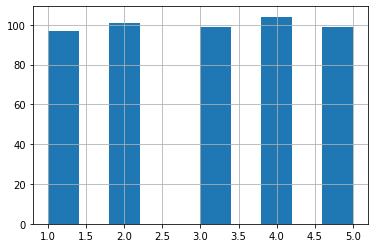

In [246]:
pd.Series(y_binned).hist()

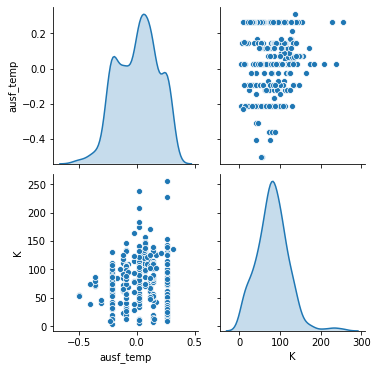

In [189]:
import seaborn as sns
sns.pairplot(df_comp[["ausf_temp", target_column]], diag_kind="kde")

In [247]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [202]:
best_model = None
best_score = 10000000
X_train, X_test = None, None
y_train, y_test = None, None
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=51)
cvscores = []
for train, test in kfold.split(X, y_binned):
  # create model
    model = keras.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=[len(predictors)]))
    model.add(layers.Dense(64, activation='relu'))
#     model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    # Compile model
    model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(0.001), metrics=['mae', 'mse'])
    # Fit the model
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

    history = model.fit(X[train], y[train], epochs=1000,
                              batch_size=10, verbose=0,
                              validation_data=(X[test], y[test]),
                              callbacks=[early_stop, tfdocs.modeling.EpochDots()])
    scores = model.evaluate(X[test], y[test], verbose=0)
    # evaluate the model
    # learning curves of model accuracy
    plt.plot(history.history['mae'], label='train')
    plt.plot(history.history['val_mae'], label='test')
    plt.legend()
    plt.show()
    train_predictions = model.predict(X[train])
    print()
    print("train_max_error: {}".format(max_error(y[train], train_predictions)))
    test_predictions = model.predict(X[test])
    print("test_max_error: {}".format(max_error(y[test], test_predictions)))
    print('Train R2 = {:0.2f}.'.format(r2_score(y[train], train_predictions)))
    print('Test R2 = {:0.2f}.'.format(r2_score(y[test], test_predictions)))
    score = scores[1]
    print("\n{}: {:.2f}".format(model.metrics_names[1], score))
    cvscores.append(score)
    if score < best_score:
        X_train, y_train = X[train], y[train]
        X_test, y_test = X[test], y[test]
        best_model = model
        best_score = score
print("{:.2f} (+/- {:.2f})".format(np.mean(cvscores), np.std(cvscores)))

Units 20

Epoch: 0, loss:120837.3359,  mae:340.4292,  mse:120837.3359,  val_loss:117459.7031,  val_mae:333.9973,  val_mse:117459.6953,  
....................................................................................................
Epoch: 100, loss:3189.1382,  mae:45.1572,  mse:3189.0771,  val_loss:4178.7075,  val_mae:51.6664,  val_mse:4178.6460,  
....................................................................................................
Epoch: 200, loss:1233.8923,  mae:25.3516,  mse:1233.7706,  val_loss:1334.5049,  val_mae:27.0230,  val_mse:1334.3831,  
....................................................................................................
Epoch: 300, loss:1032.3765,  mae:22.2581,  mse:1032.2191,  val_loss:1104.1005,  val_mae:24.1741,  val_mse:1103.9432,  
....................................................................................................
Epoch: 400, loss:910.2589,  mae:21.0159,  mse:910.0630,  val_loss:964.7220,  val_mae:22.4743,  val_mse

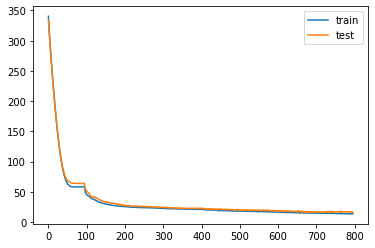


train_max_error: 89.69985961914062
test_max_error: 91.41293334960938
Train R2 = 0.92.
Test R2 = 0.91.

Epoch: 0, loss:120597.3672,  mae:339.7368,  mse:120597.3672,  val_loss:117231.3281,  val_mae:335.7562,  val_mse:117231.3359,  
....................................................................................................
Epoch: 100, loss:3680.3330,  mae:48.3554,  mse:3680.2815,  val_loss:3387.2710,  val_mae:45.7911,  val_mse:3387.2183,  
....................................................................................................
Epoch: 200, loss:1072.2981,  mae:22.9384,  mse:1072.1793,  val_loss:1725.0200,  val_mae:28.3375,  val_mse:1724.9010,  
....................................................................................................
Epoch: 300, loss:790.3937,  mae:18.9656,  mse:790.2374,  val_loss:1555.2712,  val_mae:24.8796,  val_mse:1555.1149,  
....................................................................................................
Epoch: 400

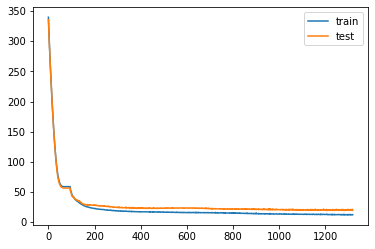


train_max_error: 73.22357177734375
test_max_error: 93.45350508256439
Train R2 = 0.94.
Test R2 = 0.79.

Epoch: 0, loss:120253.0156,  mae:339.5489,  mse:120253.0156,  val_loss:120457.2578,  val_mae:338.8410,  val_mse:120457.2578,  
....................................................................................................
Epoch: 100, loss:3244.2085,  mae:45.9447,  mse:3244.1543,  val_loss:3893.8538,  val_mae:49.9591,  val_mse:3893.7981,  
....................................................................................................
Epoch: 200, loss:896.4853,  mae:21.2287,  mse:896.3580,  val_loss:1693.6017,  val_mae:30.5547,  val_mse:1693.4740,  
....................................................................................................
Epoch: 300, loss:712.1448,  mae:18.0243,  mse:711.9813,  val_loss:1597.5653,  val_mae:28.0725,  val_mse:1597.4015,  
....................................................................................................
Epoch: 400, 

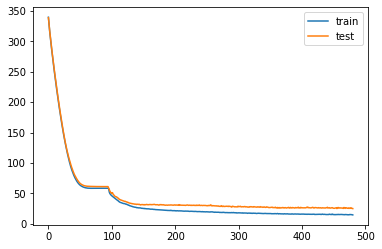


train_max_error: 99.96417236328125
test_max_error: 165.50814819335938
Train R2 = 0.91.
Test R2 = 0.75.

Epoch: 0, loss:121712.8672,  mae:341.4323,  mse:121712.8672,  val_loss:115705.3203,  val_mae:333.8841,  val_mse:115705.3203,  
....................................................................................................
Epoch: 100, loss:5144.4487,  mae:59.3935,  mse:5144.3989,  val_loss:4222.9663,  val_mae:55.3240,  val_mse:4222.9160,  
....................................................................................................
Epoch: 200, loss:923.1471,  mae:21.1440,  mse:923.0074,  val_loss:1787.3685,  val_mae:29.2785,  val_mse:1787.2286,  
...........................................................................................

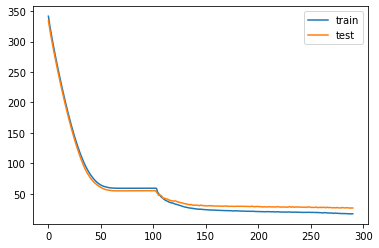


train_max_error: 144.55612182617188
test_max_error: 147.44784545898438
Train R2 = 0.87.
Test R2 = 0.54.

Epoch: 0, loss:121151.3984,  mae:340.8329,  mse:121151.3984,  val_loss:113706.2969,  val_mae:329.3886,  val_mse:113706.2969,  
....................................................................................................
Epoch: 100, loss:2888.7756,  mae:42.5347,  mse:2888.7107,  val_loss:3046.2378,  val_mae:45.2711,  val_mse:3046.1724,  
....................................................................................................
Epoch: 200, loss:1243.0370,  mae:25.7750,  mse:1242.9111,  val_loss:1518.8940,  val_mae:27.2350,  val_mse:1518.7678,  
....................................................................................................
Epoch: 300, loss:877.4872,  mae:21.0714,  mse:877.3202,  val_loss:1098.4667,  val_mae:23.5357,  val_mse:1098.2994,  
...................................................................................................

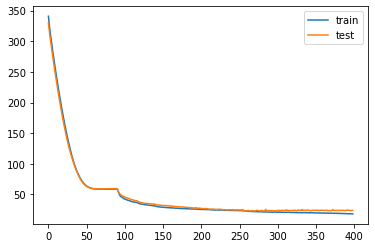


train_max_error: 132.33746337890625
test_max_error: 99.53184204101564
Train R2 = 0.86.
Test R2 = 0.78.

Epoch: 0, loss:120580.2500,  mae:339.8452,  mse:120580.2500,  val_loss:115545.7969,  val_mae:332.7760,  val_mse:115545.7891,  
....................................................................................................
Epoch: 100, loss:3437.3145,  mae:46.8326,  mse:3437.2588,  val_loss:2957.6846,  val_mae:42.7396,  val_mse:2957.6272,  
....................................................................................................
Epoch: 200, loss:1181.2024,  mae:24.5468,  mse:1181.0718,  val_loss:1182.3217,  val_mae:24.7382,  val_mse:1182.1910,  
....................................................................................................
Epoch: 300, loss:886.6824,  mae:20.3989,  mse:886.5229,  val_loss:913.4573,  val_mae:21.5290,  val_mse:913.2977,  
....................................................................................................
Epoch: 400,

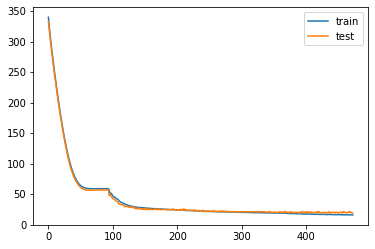


train_max_error: 121.51956176757812
test_max_error: 104.64284057617186
Train R2 = 0.89.
Test R2 = 0.83.

Epoch: 0, loss:120780.4844,  mae:340.1399,  mse:120780.4844,  val_loss:112698.3516,  val_mae:328.0941,  val_mse:112698.3438,  
....................................................................................................
Epoch: 100, loss:3989.8372,  mae:51.2128,  mse:3989.7856,  val_loss:3720.0427,  val_mae:49.7391,  val_mse:3719.9910,  
....................................................................................................
Epoch: 200, loss:1185.7336,  mae:24.0639,  mse:1185.6119,  val_loss:1261.2197,  val_mae:27.2870,  val_mse:1261.0978,  
....................................................................................................
Epoch: 300, loss:954.1325,  mae:20.6537,  mse:953.9940,  val_loss:932.0287,  val_mae:23.1882,  val_mse:931.8902,  
....................................................................................................
Epoch: 400

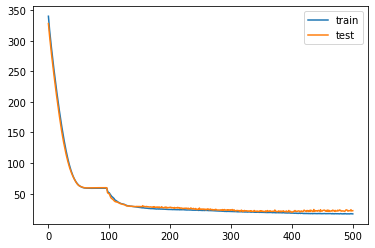


train_max_error: 114.01528930664062
test_max_error: 107.1007080078125
Train R2 = 0.88.
Test R2 = 0.82.

Epoch: 0, loss:121334.9219,  mae:340.9725,  mse:121334.9141,  val_loss:117681.1797,  val_mae:335.8903,  val_mse:117681.1797,  
....................................................................................................
Epoch: 100, loss:3581.5129,  mae:47.7287,  mse:3581.4626,  val_loss:3395.0645,  val_mae:46.7666,  val_mse:3395.0137,  
....................................................................................................
Epoch: 200, loss:1153.4182,  mae:24.3686,  mse:1153.2936,  val_loss:1239.7811,  val_mae:26.8446,  val_mse:1239.6562,  
....................................................................................................
Epoch: 300, loss:946.6698,  mae:21.5531,  mse:946.5177,  val_loss:1181.3405,  val_mae:25.5479,  val_mse:1181.1881,  
...........................................................

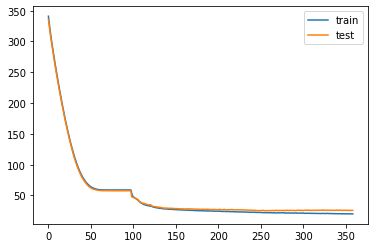


train_max_error: 151.34841918945312
test_max_error: 129.91476440429688
Train R2 = 0.83.
Test R2 = 0.75.
Units 19

Epoch: 0, loss:121232.3047,  mae:341.0579,  mse:121232.3047,  val_loss:118143.0938,  val_mae:335.0191,  val_mse:118143.0781,  
....................................................................................................
Epoch: 100, loss:4248.1387,  mae:52.8855,  mse:4248.0879,  val_loss:5137.5146,  val_mae:60.0161,  val_mse:5137.4644,  
....................................................................................................
Epoch: 200, loss:1272.5273,  mae:25.6322,  mse:1272.4174,  val_loss:1262.3280,  val_mae:26.3328,  val_mse:1262.2179,  
....................................................................................................
Epoch: 300, loss:1037.3828,  mae:22.4009,  mse:1037.2332,  val_loss:915.7501,  val_mae:22.0009,  val_mse:915.6001,  
....................................................................................................

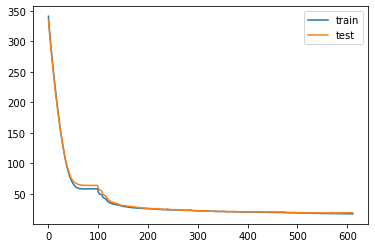


train_max_error: 114.48867797851562
test_max_error: 76.62472534179688
Train R2 = 0.87.
Test R2 = 0.89.

Epoch: 0, loss:120731.4297,  mae:339.9577,  mse:120731.4219,  val_loss:117796.9531,  val_mae:336.5957,  val_mse:117796.9375,  
....................................................................................................
Epoch: 100, loss:4885.2876,  mae:57.4312,  mse:4885.2427,  val_loss:4117.7236,  val_mae:52.3677,  val_mse:4117.6782,  
....................................................................................................
Epoch: 200, loss:1124.0061,  mae:23.7299,  mse:1123.8848,  val_loss:1737.1921,  val_mae:27.7900,  val_mse:1737.0706,  
....................................................................................................
Epoch: 300, loss:915.5785,  mae:20.1434,  mse:915.4337,  val_loss:1685.3530,  val_mae:26.6739,  val_mse:1685.2080,  
....................................................................................................
Epoch: 40

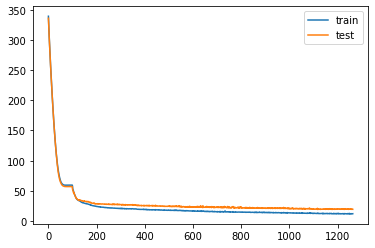


train_max_error: 66.59811401367188
test_max_error: 111.90635542436127
Train R2 = 0.95.
Test R2 = 0.80.

Epoch: 0, loss:121314.6641,  mae:341.1528,  mse:121314.6641,  val_loss:121904.4844,  val_mae:340.9606,  val_mse:121904.4688,  
....................................................................................................
Epoch: 100, loss:4181.1533,  mae:53.0516,  mse:4181.1045,  val_loss:4798.5322,  val_mae:56.7948,  val_mse:4798.4814,  
....................................................................................................
Epoch: 200, loss:888.1746,  mae:21.8722,  mse:888.0567,  val_loss:1760.6620,  val_mae:31.1291,  val_mse:1760.5439,  
....................................................................................................
Epoch: 300, loss:651.0260,  mae:18.2399,  mse:650.8604,  val_loss:1679.4915,  val_mae:27.9393,  val_mse:1679.3256,  
...............................................................

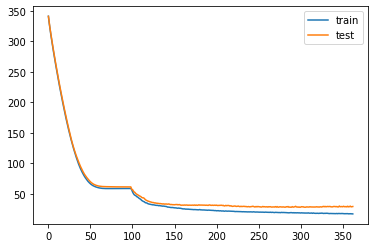


train_max_error: 104.40902709960938
test_max_error: 167.14474487304688
Train R2 = 0.89.
Test R2 = 0.69.

Epoch: 0, loss:121573.2891,  mae:341.0965,  mse:121573.2891,  val_loss:115571.0156,  val_mae:333.6797,  val_mse:115571.0000,  
....................................................................................................
Epoch: 100, loss:5144.9634,  mae:59.3758,  mse:5144.9160,  val_loss:4223.7798,  val_mae:55.3161,  val_mse:4223.7319,  
....................................................................................................
Epoch: 200, loss:1128.6184,  mae:23.8257,  mse:1128.4990,  val_loss:1821.9055,  val_mae:30.6278,  val_mse:1821.7860,  
....................................................................................................
Epoch: 300, loss:833.3324,  mae:19.5949,  mse:833.1874,  val_loss:1899.3322,  val_mae:28.9253,  val_mse:1899.1869,  
........

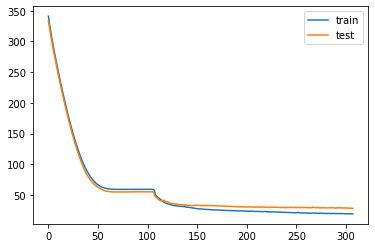


train_max_error: 150.97006225585938
test_max_error: 142.24362182617188
Train R2 = 0.85.
Test R2 = 0.55.

Epoch: 0, loss:120785.5312,  mae:340.2302,  mse:120785.5312,  val_loss:113259.7266,  val_mae:328.7100,  val_mse:113259.7266,  
....................................................................................................
Epoch: 100, loss:3549.8491,  mae:47.8934,  mse:3549.7976,  val_loss:3609.6572,  val_mae:49.9291,  val_mse:3609.6047,  
....................................................................................................
Epoch: 200, loss:1470.6252,  mae:28.8385,  mse:1470.5219,  val_loss:1640.3333,  val_mae:29.3286,  val_mse:1640.2299,  
....................................................................................................
Epoch: 300, loss:976.0330,  mae:22.5830,  mse:975.8941,  val_loss:1326.7517,  val_mae:25.6821,  val_mse:1326.6125,  
....................................................................................................
Epoch: 4

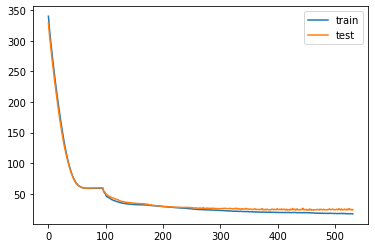


train_max_error: 119.46017456054688
test_max_error: 108.48356323242189
Train R2 = 0.88.
Test R2 = 0.78.

Epoch: 0, loss:119718.6094,  mae:338.5936,  mse:119718.6094,  val_loss:114791.8047,  val_mae:331.6288,  val_mse:114791.7969,  
....................................................................................................
Epoch: 100, loss:4395.1079,  mae:54.2407,  mse:4395.0615,  val_loss:3870.7671,  val_mae:48.9217,  val_mse:3870.7192,  
....................................................................................................
Epoch: 200, loss:1309.2819,  mae:26.7126,  mse:1309.1720,  val_loss:1122.4216,  val_mae:25.1203,  val_mse:1122.3118,  
....................................................................................................
Epoch: 300, loss:998.0502,  mae:22.3521,  mse:997.9154,  val_loss:923.0113,  val_mae:21.8444,  val_mse:922.8761,  
....................................................................................................
Epoch: 400

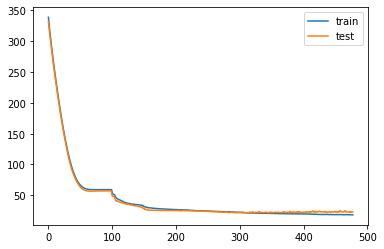


train_max_error: 127.94805908203125
test_max_error: 98.93614501953124
Train R2 = 0.87.
Test R2 = 0.81.

Epoch: 0, loss:120941.5703,  mae:340.4938,  mse:120941.5625,  val_loss:113142.9688,  val_mae:328.7864,  val_mse:113142.9609,  
....................................................................................................
Epoch: 100, loss:3481.6399,  mae:47.8498,  mse:3481.5862,  val_loss:2891.4775,  val_mae:44.7320,  val_mse:2891.4233,  
....................................................................................................
Epoch: 200, loss:1224.1021,  mae:25.0905,  mse:1223.9817,  val_loss:1006.5851,  val_mae:24.7323,  val_mse:1006.4648,  
....................................................................................................
Epoch: 300, loss:952.2804,  mae:21.2048,  mse:952.1229,  val_loss:864.6866,  val_mae:22.2467,  val_mse:864.5284,  
....................................................................................................
Epoch: 400,

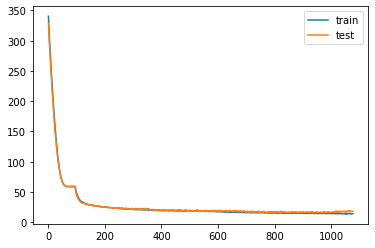


train_max_error: 88.72308349609375
test_max_error: 80.36380004882812
Train R2 = 0.93.
Test R2 = 0.88.

Epoch: 0, loss:120525.6016,  mae:339.7486,  mse:120525.5859,  val_loss:116686.7266,  val_mae:334.3925,  val_mse:116686.7266,  
....................................................................................................
Epoch: 100, loss:4597.6255,  mae:55.8894,  mse:4597.5825,  val_loss:4208.9385,  val_mae:51.4122,  val_mse:4208.8955,  
....................................................................................................
Epoch: 200, loss:1199.7087,  mae:25.3430,  mse:1199.5948,  val_loss:1279.7266,  val_mae:27.5863,  val_mse:1279.6127,  
....................................................................................................
Epoch: 300, loss:1008.5440,  mae:22.0428,  mse:1008.4033,  val_loss:1189.1010,  val_mae:25.2485,  val_mse:1188.9601,  
....................................................................................................
Epoch: 4

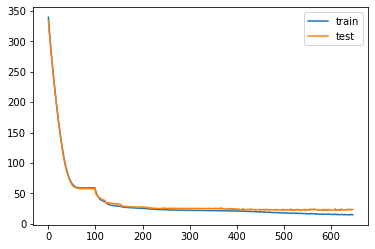


train_max_error: 103.70925903320312
test_max_error: 89.51104736328125
Train R2 = 0.91.
Test R2 = 0.78.
Units 18

Epoch: 0, loss:120660.6875,  mae:340.1365,  mse:120660.6875,  val_loss:117628.3516,  val_mae:334.2483,  val_mse:117628.3516,  
....................................................................................................
Epoch: 100, loss:4898.8096,  mae:58.1240,  mse:4898.7632,  val_loss:5902.3979,  val_mae:63.6682,  val_mse:5902.3511,  
....................................................................................................
Epoch: 200, loss:1273.5319,  mae:25.6831,  mse:1273.4210,  val_loss:1514.2998,  val_mae:30.5410,  val_mse:1514.1888,  
....................................................................................................
Epoch: 300, loss:1014.5178,  mae:23.2563,  mse:1014.3851,  val_loss:1040.4967,  val_mae:24.5711,  val_mse:1040.3632,  
...................................................................................................

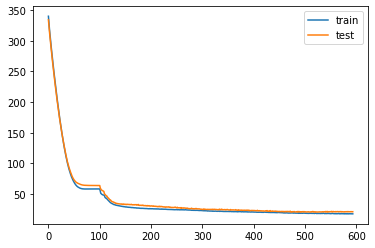


train_max_error: 99.99298095703125
test_max_error: 111.60809326171875
Train R2 = 0.88.
Test R2 = 0.85.

Epoch: 0, loss:121279.1094,  mae:340.8139,  mse:121279.1094,  val_loss:118542.5391,  val_mae:337.7120,  val_mse:118542.5312,  
....................................................................................................
Epoch: 100, loss:5106.0928,  mae:59.1356,  mse:5106.0503,  val_loss:4486.9727,  val_mae:56.7411,  val_mse:4486.9292,  
....................................................................................................
Epoch: 200, loss:1176.4860,  mae:24.7882,  mse:1176.3799,  val_loss:1924.5347,  val_mae:30.6554,  val_mse:1924.4290,  
....................................................................................................
Epoch: 300, loss:895.3458,  mae:20.7450,  mse:895.2240,  val_loss:1772.9121,  val_mae:28.7990,  val_mse:1772.7902,  
....................................................................................................
Epoch: 40

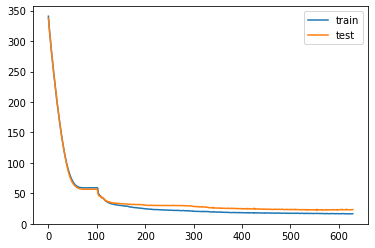


train_max_error: 111.10885620117188
test_max_error: 125.54100036621094
Train R2 = 0.89.
Test R2 = 0.73.

Epoch: 0, loss:120961.8828,  mae:340.6567,  mse:120961.8828,  val_loss:121732.5859,  val_mae:340.7164,  val_mse:121732.5859,  
....................................................................................................
Epoch: 100, loss:4371.1279,  mae:54.0412,  mse:4371.0825,  val_loss:4947.3389,  val_mae:56.1246,  val_mse:4947.2925,  
....................................................................................................
Epoch: 200, loss:1132.6782,  mae:24.3472,  mse:1132.5726,  val_loss:1703.9456,  val_mae:32.0449,  val_mse:1703.8396,  
....................................................................................................
Epoch: 300, loss:867.7032,  mae:20.6896,  mse:867.5714,  val_loss:1711.9807,  val_mae:31.0656,  val_mse:1711.8490,  
....................................................................................................
Epoch: 4

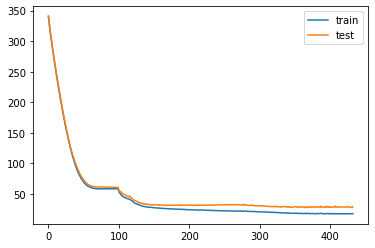


train_max_error: 111.87020874023438
test_max_error: 155.28228759765625
Train R2 = 0.87.
Test R2 = 0.71.

Epoch: 0, loss:122061.9219,  mae:341.8949,  mse:122061.9141,  val_loss:116513.1406,  val_mae:335.0932,  val_mse:116513.1406,  
....................................................................................................
Epoch: 100, loss:5145.6147,  mae:59.3889,  mse:5145.5654,  val_loss:4224.4824,  val_mae:55.3428,  val_mse:4224.4336,  
....................................................................................................
Epoch: 200, loss:1200.1573,  mae:24.9633,  mse:1200.0447,  val_loss:2122.5515,  val_mae:34.1551,  val_mse:2122.4387,  
....................................................

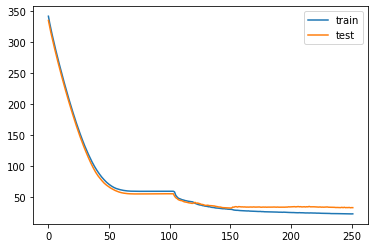


train_max_error: 168.32073974609375
test_max_error: 137.7569122314453
Train R2 = 0.79.
Test R2 = 0.50.

Epoch: 0, loss:121739.5000,  mae:341.6465,  mse:121739.5000,  val_loss:114844.8203,  val_mae:331.1170,  val_mse:114844.8203,  
....................................................................................................
Epoch: 100, loss:3735.8223,  mae:48.7693,  mse:3735.7693,  val_loss:3900.6567,  val_mae:51.2669,  val_mse:3900.6021,  
....................................................................................................
Epoch: 200, loss:1249.4459,  mae:26.2336,  mse:1249.3341,  val_loss:1538.6820,  val_mae:27.3692,  val_mse:1538.5702,  
....................................................................................................
Epoch: 300, loss:957.2035,  mae:21.5740,  mse:957.0550,  val_loss:1210.4388,  val_mae:23.7664,  val_mse:1210.2903,  
....................................................................................................
Epoch: 40

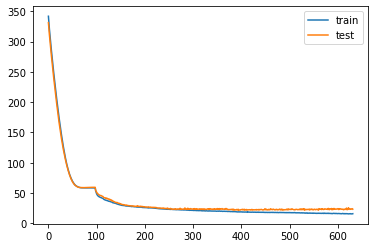


train_max_error: 115.77639770507812
test_max_error: 108.14889526367188
Train R2 = 0.90.
Test R2 = 0.78.

Epoch: 0, loss:121233.2812,  mae:340.8426,  mse:121233.2812,  val_loss:116579.0859,  val_mae:334.3173,  val_mse:116579.0781,  
....................................................................................................
Epoch: 100, loss:5061.1758,  mae:59.1037,  mse:5061.1323,  val_loss:4800.9365,  val_mae:57.0578,  val_mse:4800.8911,  
....................................................................................................
Epoch: 200, loss:1356.9076,  mae:26.7851,  mse:1356.8063,  val_loss:1093.7339,  val_mae:24.4682,  val_mse:1093.6323,  
....................................................................................................
Epoch: 300, loss:1035.8850,  mae:23.1589,  mse:1035.7738,  val_loss:1036.6722,  val_mae:22.6254,  val_mse:1036.5609,  
....................................................................................................
Epoch:

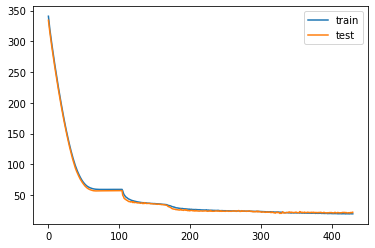


train_max_error: 130.32070922851562
test_max_error: 103.88829345703124
Train R2 = 0.85.
Test R2 = 0.80.

Epoch: 0, loss:121797.1406,  mae:341.6818,  mse:121797.1250,  val_loss:114457.6719,  val_mae:330.7815,  val_mse:114457.6562,  
....................................................................................................
Epoch: 100, loss:5025.2534,  mae:58.7917,  mse:5025.2061,  val_loss:5058.3257,  val_mae:59.6151,  val_mse:5058.2793,  
....................................................................................................
Epoch: 200, loss:1317.7212,  mae:26.3440,  mse:1317.6123,  val_loss:1239.8715,  val_mae:27.7108,  val_mse:1239.7628,  
....................................................................................................
Epoch: 300, loss:1039.5234,  mae:22.4888,  mse:1039.3983,  val_loss:1187.9666,  val_mae:25.9538,  val_mse:1187.8413,  
....................................................................................................
Epoch:

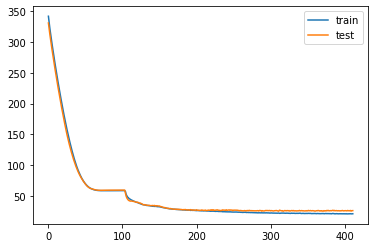


train_max_error: 148.43975830078125
test_max_error: 114.3680419921875
Train R2 = 0.82.
Test R2 = 0.76.

Epoch: 0, loss:120500.8281,  mae:339.7732,  mse:120500.8281,  val_loss:116972.3984,  val_mae:334.8289,  val_mse:116972.3906,  
....................................................................................................
Epoch: 100, loss:5053.5889,  mae:58.9987,  mse:5053.5474,  val_loss:4855.1758,  val_mae:57.6967,  val_mse:4855.1348,  
....................................................................................................
Epoch: 200, loss:1189.3849,  mae:25.2026,  mse:1189.2720,  val_loss:1327.0173,  val_mae:28.1974,  val_mse:1326.9044,  
....................................................................................................
Epoch: 300, loss:988.5289,  mae:21.8576,  mse:988.3843,  val_loss:1148.5153,  val_mae:24.6366,  val_mse:1148.3707,  
....................................................................................................
Epoch: 40

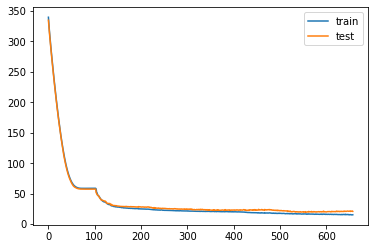


train_max_error: 125.70700073242188
test_max_error: 114.0103759765625
Train R2 = 0.90.
Test R2 = 0.82.
Units 17

Epoch: 0, loss:121413.1562,  mae:341.3139,  mse:121413.1562,  val_loss:118815.1250,  val_mae:336.0195,  val_mse:118815.1094,  
....................................................................................................
Epoch: 100, loss:4902.2622,  mae:58.1460,  mse:4902.2139,  val_loss:5911.7725,  val_mae:63.7310,  val_mse:5911.7246,  
....................................................................................................
Epoch: 200, loss:1695.3473,  mae:30.8966,  mse:1695.2568,  val_loss:2063.0710,  val_mae:35.6557,  val_mse:2062.9802,  
....................................................................................................
Epoch: 300, loss:1135.6515,  mae:23.9829,  mse:1135.5422,  val_loss:1185.2648,  val_mae:25.9666,  val_mse:1185.1555,  
...................................................................................................

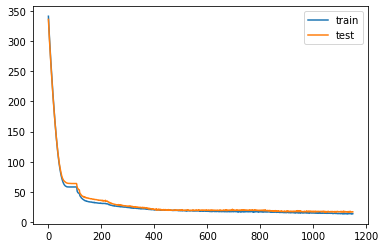


train_max_error: 75.49224039713573
test_max_error: 63.228515625
Train R2 = 0.92.
Test R2 = 0.92.

Epoch: 0, loss:121365.3203,  mae:340.9185,  mse:121365.3203,  val_loss:118831.2656,  val_mae:338.1351,  val_mse:118831.2656,  
....................................................................................................
Epoch: 100, loss:5107.4312,  mae:59.1361,  mse:5107.3877,  val_loss:4488.1196,  val_mae:56.7365,  val_mse:4488.0771,  
....................................................................................................
Epoch: 200, loss:1193.0817,  mae:25.5083,  mse:1192.9769,  val_loss:1884.9594,  val_mae:30.6813,  val_mse:1884.8541,  
....................................................................................................
Epoch: 300, loss:921.1738,  mae:20.7875,  mse:921.0520,  val_loss:1727.6490,  val_mae:27.7490,  val_mse:1727.5272,  
....................................................................................................
Epoch: 400, los

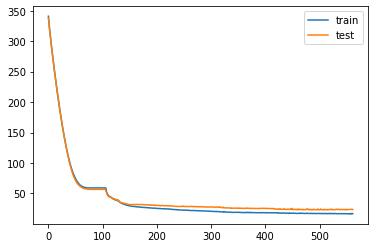


train_max_error: 113.71786499023438
test_max_error: 131.07893880208297
Train R2 = 0.89.
Test R2 = 0.70.

Epoch: 0, loss:121268.3750,  mae:341.0760,  mse:121268.3750,  val_loss:122257.1172,  val_mae:341.4809,  val_mse:122257.1094,  
....................................................................................................
Epoch: 100, loss:4935.5566,  mae:58.4976,  mse:4935.5127,  val_loss:5686.8730,  val_mae:61.0954,  val_mse:5686.8291,  
....................................................................................................
Epoch: 200, loss:986.9927,  mae:22.4273,  mse:986.8839,  val_loss:1565.9603,  val_mae:29.2589,  val_mse:1565.8513,  
....................................................................................................
Epoch: 300, loss:755.2441,  mae:19.2549,  mse:755.1024,  val_loss:1443.0510,  val_mae:27.3485,  val_mse:1442.9092,  
....................................................................................................
Epoch: 400

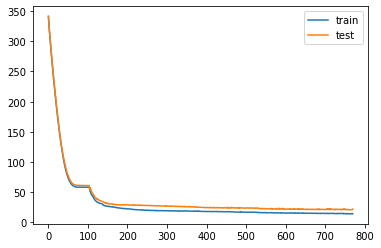


train_max_error: 100.9793701171875
test_max_error: 139.22637939453125
Train R2 = 0.91.
Test R2 = 0.78.

Epoch: 0, loss:122449.2422,  mae:342.5182,  mse:122449.2422,  val_loss:116857.9766,  val_mae:335.6047,  val_mse:116857.9609,  
....................................................................................................
Epoch: 100, loss:5145.2041,  mae:59.3695,  mse:5145.1621,  val_loss:4223.9478,  val_mae:55.3104,  val_mse:4223.9043,  
....................................................................................................
Epoch: 200, loss:1058.2349,  mae:23.8297,  mse:1058.1266,  val_loss:2043.2761,  val_mae:33.5638,  val_mse:2043.1676,  
....................................................................................................
Epoch: 300, loss:744.5575,  mae:18.7854,  mse:744.4230,  val_loss:1584.8141,  val_mae:27.1638,  val_mse:1584.6796,  
....................................................................................................
Epoch: 40

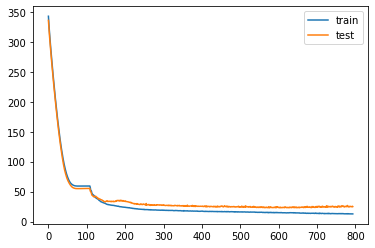


train_max_error: 105.77142333984375
test_max_error: 133.58645629882812
Train R2 = 0.93.
Test R2 = 0.64.

Epoch: 0, loss:122056.9297,  mae:342.0839,  mse:122056.9531,  val_loss:115313.2031,  val_mae:331.8271,  val_mse:115313.2031,  
....................................................................................................
Epoch: 100, loss:5002.6982,  mae:58.7635,  mse:5002.6523,  val_loss:5219.5186,  val_mae:59.6059,  val_mse:5219.4746,  
....................................................................................................
Epoch: 200, loss:1409.0817,  mae:28.4549,  mse:1408.9891,  val_loss:1486.2810,  val_mae:28.2644,  val_mse:1486.1886,  
....................................................................................................
Epoch: 300, loss:1081.3558,  mae:23.4036,  mse:1081.2476,  val_loss:1242.6708,  val_mae:24.4895,  val_mse:1242.5621,  
....................................................................................................
Epoch:

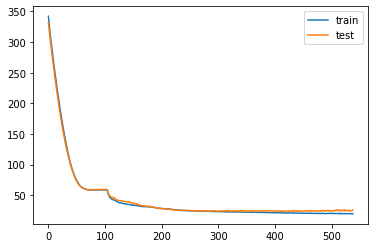


train_max_error: 140.69223022460938
test_max_error: 93.10395507812501
Train R2 = 0.85.
Test R2 = 0.77.

Epoch: 0, loss:121887.1719,  mae:341.7447,  mse:121887.1719,  val_loss:117489.9766,  val_mae:335.6851,  val_mse:117489.9766,  
....................................................................................................
Epoch: 100, loss:5060.5747,  mae:59.0938,  mse:5060.5312,  val_loss:4800.9419,  val_mae:57.0527,  val_mse:4800.8975,  
....................................................................................................
Epoch: 200, loss:1225.7657,  mae:24.9879,  mse:1225.6628,  val_loss:1036.5112,  val_mae:23.0425,  val_mse:1036.4082,  
....................................................................................................
Epoch: 300, loss:1012.9474,  mae:22.1125,  mse:1012.8150,  val_loss:1002.9451,  val_mae:21.5502,  val_mse:1002.8123,  
.......................................................

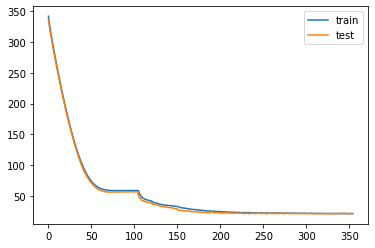


train_max_error: 151.73880004882812
test_max_error: 101.54693603515625
Train R2 = 0.81.
Test R2 = 0.79.

Epoch: 0, loss:121505.7656,  mae:341.2705,  mse:121505.7656,  val_loss:114379.2891,  val_mae:330.6631,  val_mse:114379.2891,  
....................................................................................................
Epoch: 100, loss:5025.5615,  mae:58.7831,  mse:5025.5166,  val_loss:5055.0439,  val_mae:59.5926,  val_mse:5054.9985,  
....................................................................................................
Epoch: 200, loss:1258.5576,  mae:25.0968,  mse:1258.4478,  val_loss:1288.5641,  val_mae:28.2061,  val_mse:1288.4543,  
....................................................................................................
Epoch: 300, loss:915.3510,  mae:20.9162,  mse:915.2117,  val_loss:914.0551,  val_mae:23.3505,  val_mse:913.9156,  
....................................................................................................
Epoch: 400

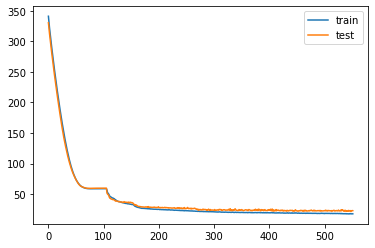


train_max_error: 120.63034057617188
test_max_error: 94.43209838867188
Train R2 = 0.87.
Test R2 = 0.82.

Epoch: 0, loss:121719.1406,  mae:341.5296,  mse:121719.1406,  val_loss:118713.5547,  val_mae:337.4216,  val_mse:118713.5547,  
....................................................................................................
Epoch: 100, loss:5055.1523,  mae:58.9918,  mse:5055.1089,  val_loss:4857.9253,  val_mae:57.6798,  val_mse:4857.8818,  
....................................................................................................
Epoch: 200, loss:1263.2194,  mae:25.9087,  mse:1263.1233,  val_loss:1340.8373,  val_mae:27.8810,  val_mse:1340.7411,  
....................................................................................................
Epoch: 300, loss:908.4288,  mae:21.1223,  mse:908.3095,  val_loss:1033.3685,  val_mae:24.5423,  val_mse:1033.2489,  
....................................................................................................
Epoch: 40

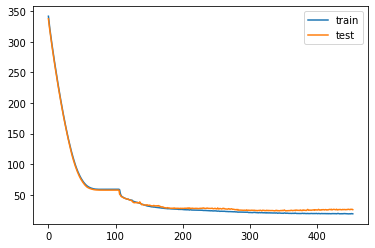


train_max_error: 128.495849609375
test_max_error: 98.30532836914062
Train R2 = 0.85.
Test R2 = 0.77.
Units 16

Epoch: 0, loss:121034.8828,  mae:340.8058,  mse:121034.8828,  val_loss:118240.2812,  val_mae:335.1634,  val_mse:118240.2656,  
....................................................................................................
Epoch: 100, loss:4902.0142,  mae:58.1164,  mse:4901.9702,  val_loss:5912.3701,  val_mae:63.7218,  val_mse:5912.3262,  
....................................................................................................
Epoch: 200, loss:1479.5459,  mae:29.6125,  mse:1479.4611,  val_loss:1688.1161,  val_mae:33.4923,  val_mse:1688.0309,  
....................................................................................................
Epoch: 300, loss:992.9136,  mae:22.6562,  mse:992.8098,  val_loss:929.3281,  val_mae:23.4832,  val_mse:929.2245,  
....................................................................................................
Epoc

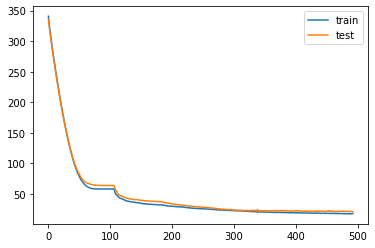


train_max_error: 100.107666015625
test_max_error: 76.3958740234375
Train R2 = 0.87.
Test R2 = 0.87.

Epoch: 0, loss:121140.1250,  mae:340.6196,  mse:121140.1250,  val_loss:118770.2969,  val_mae:338.0516,  val_mse:118770.2812,  
....................................................................................................
Epoch: 100, loss:5108.2822,  mae:59.1311,  mse:5108.2422,  val_loss:4489.8550,  val_mae:56.7315,  val_mse:4489.8140,  
....................................................................................................
Epoch: 200, loss:1228.6531,  mae:25.6304,  mse:1228.5566,  val_loss:1631.0249,  val_mae:28.9827,  val_mse:1630.9282,  
....................................................................................................
Epoch: 300, loss:941.0392,  mae:22.3258,  mse:940.9261,  val_loss:1478.5149,  val_mae:27.6033,  val_mse:1478.4016,  
....................................................................................................
Epoch: 400, 

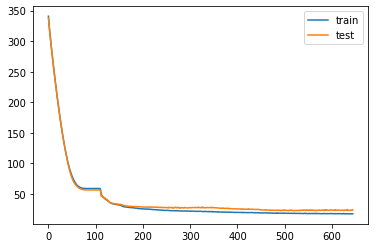


train_max_error: 124.24008178710938
test_max_error: 123.61031087239547
Train R2 = 0.87.
Test R2 = 0.71.

Epoch: 0, loss:120457.7734,  mae:339.8983,  mse:120457.7734,  val_loss:121525.4062,  val_mae:340.4115,  val_mse:121525.3906,  
....................................................................................................
Epoch: 100, loss:4935.9980,  mae:58.4749,  mse:4935.9561,  val_loss:5691.5020,  val_mae:61.1086,  val_mse:5691.4595,  
....................................................................................................
Epoch: 200, loss:1240.5116,  mae:25.9626,  mse:1240.4188,  val_loss:1655.1045,  val_mae:30.3240,  val_mse:1655.0115,  
....................................................................................................
Epoch: 300, loss:844.0602,  mae:21.0924,  mse:843.9543,  val_loss:1778.4705,  val_mae:30.1117,  val_mse:1778.3646,  
..........................

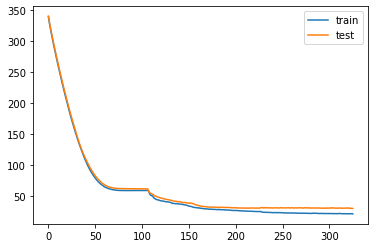


train_max_error: 133.35655212402344
test_max_error: 154.57919311523438
Train R2 = 0.84.
Test R2 = 0.70.

Epoch: 0, loss:121994.8359,  mae:341.7851,  mse:121994.8359,  val_loss:116575.6641,  val_mae:335.1855,  val_mse:116575.6641,  
....................................................................................................
Epoch: 100, loss:5145.8521,  mae:59.3510,  mse:5145.8066,  val_loss:4223.9858,  val_mae:55.2902,  val_mse:4223.9404,  
....................................................................................................
Epoch: 200, loss:1200.5193,  mae:24.9608,  mse:1200.4182,  val_loss:1910.7446,  val_mae:32.5011,  val_mse:1910.6433,  
....................................................................................................
Epoch: 300, loss:906.3745,  mae:21.3838,  mse:906.2563,  val_loss:1848.7247,  val_mae:31.8416,  val_mse:1848.6064,  
....................................................................................................
Epoch: 4

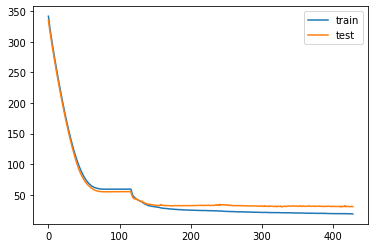


train_max_error: 147.89599609375
test_max_error: 117.28009033203125
Train R2 = 0.86.
Test R2 = 0.58.

Epoch: 0, loss:122067.8984,  mae:342.1021,  mse:122067.8984,  val_loss:115516.7266,  val_mae:332.1301,  val_mse:115516.7266,  
....................................................................................................
Epoch: 100, loss:5002.1885,  mae:58.7601,  mse:5002.1460,  val_loss:5218.6074,  val_mae:59.5942,  val_mse:5218.5654,  
....................................................................................................
Epoch: 200, loss:1615.6350,  mae:29.9836,  mse:1615.5476,  val_loss:1693.0165,  val_mae:31.6586,  val_mse:1692.9288,  
....................................................................................................
Epoch: 300, loss:1260.6946,  mae:26.3781,  mse:1260.5996,  val_loss:1280.0936,  val_mae:25.3284,  val_mse:1279.9987,  
....................................................................................................
Epoch: 40

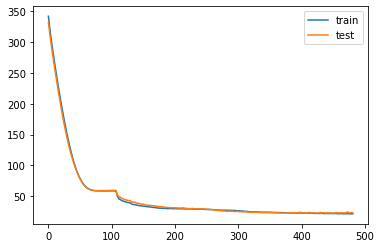


train_max_error: 158.011474609375
test_max_error: 97.54868910047787
Train R2 = 0.82.
Test R2 = 0.77.

Epoch: 0, loss:122090.2109,  mae:342.0547,  mse:122090.2109,  val_loss:117858.2969,  val_mae:336.2246,  val_mse:117858.2891,  
....................................................................................................
Epoch: 100, loss:5061.8882,  mae:59.0943,  mse:5061.8452,  val_loss:4801.3589,  val_mae:57.0262,  val_mse:4801.3154,  
....................................................................................................
Epoch: 200, loss:1297.3198,  mae:26.4837,  mse:1297.2249,  val_loss:1093.4636,  val_mae:24.8248,  val_mse:1093.3687,  
....................................................................................................
Epoch: 300, loss:1035.9055,  mae:22.9851,  mse:1035.7992,  val_loss:919.9587,  val_mae:21.9078,  val_mse:919.8521,  
....................................................................................................
Epoch: 400,

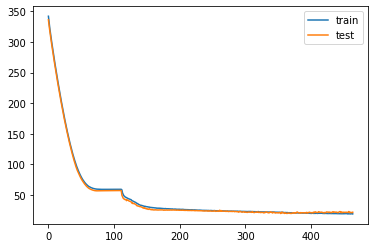


train_max_error: 135.2640380859375
test_max_error: 96.91270751953124
Train R2 = 0.86.
Test R2 = 0.82.

Epoch: 0, loss:122109.0078,  mae:342.1676,  mse:122108.9922,  val_loss:114782.4844,  val_mae:331.2686,  val_mse:114782.4844,  
....................................................................................................
Epoch: 100, loss:5025.5298,  mae:58.7505,  mse:5025.4878,  val_loss:5051.7036,  val_mae:59.5779,  val_mse:5051.6626,  
....................................................................................................
Epoch: 200, loss:1692.9780,  mae:30.2209,  mse:1692.8871,  val_loss:1861.3065,  val_mae:33.7730,  val_mse:1861.2159,  
....................................................................................................
Epoch: 300, loss:1042.3245,  mae:21.5975,  mse:1042.2079,  val_loss:1012.3549,  val_mae:25.0170,  val_mse:1012.2382,  
....................................................................................................
Epoch: 4

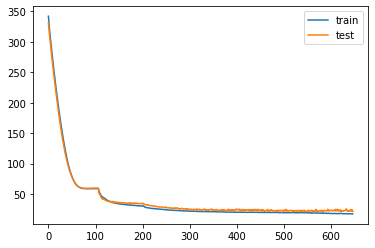


train_max_error: 110.1258544921875
test_max_error: 105.28335571289062
Train R2 = 0.87.
Test R2 = 0.82.

Epoch: 0, loss:121783.7969,  mae:341.6316,  mse:121783.7969,  val_loss:118760.1562,  val_mae:337.4889,  val_mse:118760.1406,  
....................................................................................................
Epoch: 100, loss:5053.9595,  mae:58.9900,  mse:5053.9189,  val_loss:4858.0127,  val_mae:57.6869,  val_mse:4857.9712,  
....................................................................................................
Epoch: 200, loss:1406.0640,  mae:28.1356,  mse:1405.9791,  val_loss:1564.2036,  val_mae:31.9094,  val_mse:1564.1189,  
....................................................................................................
Epoch: 300, loss:1102.3705,  mae:23.9190,  mse:1102.2738,  val_loss:1292.2213,  val_mae:26.9540,  val_mse:1292.1248,  
....................................................................................................
Epoch: 

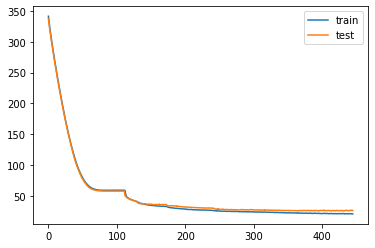


train_max_error: 151.91644287109375
test_max_error: 123.79766845703125
Train R2 = 0.82.
Test R2 = 0.73.
Units 15

Epoch: 0, loss:121442.9844,  mae:341.3419,  mse:121442.9844,  val_loss:118983.6094,  val_mae:336.2657,  val_mse:118983.6016,  
....................................................................................................
Epoch: 100, loss:4903.8311,  mae:58.0915,  mse:4903.7881,  val_loss:5914.9565,  val_mae:63.7283,  val_mse:5914.9141,  
....................................................................................................
Epoch: 200, loss:1823.9442,  mae:32.1626,  mse:1823.8701,  val_loss:2334.5613,  val_mae:38.3668,  val_mse:2334.4873,  
....................................................................................................
Epoch: 300, loss:1401.4365,  mae:27.4094,  mse:1401.3452,  val_loss:1692.1548,  val_mae:29.4342,  val_mse:1692.0635,  
..................................................................................................

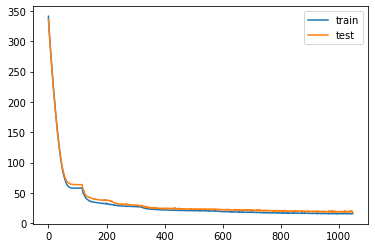


train_max_error: 102.42202758789062
test_max_error: 84.94094848632812
Train R2 = 0.90.
Test R2 = 0.89.

Epoch: 0, loss:120926.2891,  mae:340.3297,  mse:120926.2891,  val_loss:118643.5312,  val_mae:337.8574,  val_mse:118643.5312,  
....................................................................................................
Epoch: 100, loss:5110.4795,  mae:59.0978,  mse:5110.4409,  val_loss:4495.3706,  val_mae:56.7204,  val_mse:4495.3330,  
....................................................................................................
Epoch: 200, loss:1147.8250,  mae:24.8531,  mse:1147.7329,  val_loss:1764.0767,  val_mae:29.1906,  val_mse:1763.9844,  
....................................................................................................
Epoch: 300, loss:952.9269,  mae:21.4593,  mse:952.8082,  val_loss:1593.8344,  val_mae:26.8255,  val_mse:1593.7153,  
....................................................................................................
Epoch: 40

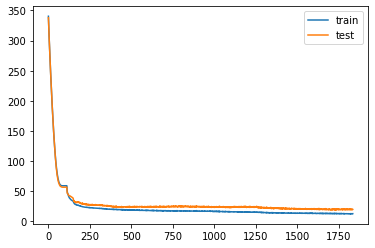


train_max_error: 73.46750895182328
test_max_error: 80.93191528320312
Train R2 = 0.94.
Test R2 = 0.84.

Epoch: 0, loss:121031.0938,  mae:340.7069,  mse:121031.0938,  val_loss:122248.6641,  val_mae:341.4772,  val_mse:122248.6562,  
....................................................................................................
Epoch: 100, loss:4938.0894,  mae:58.4450,  mse:4938.0493,  val_loss:5700.3154,  val_mae:61.1354,  val_mse:5700.2754,  
....................................................................................................
Epoch: 200, loss:1044.7450,  mae:23.4708,  mse:1044.6545,  val_loss:1791.9979,  val_mae:30.3453,  val_mse:1791.9073,  
....................................................................................................
Epoch: 300, loss:753.7285,  mae:19.8962,  mse:753.6161,  val_loss:1692.1035,  val_mae:29.0597,  val_mse:1691.9912,  
....................................................................................................
Epoch: 400

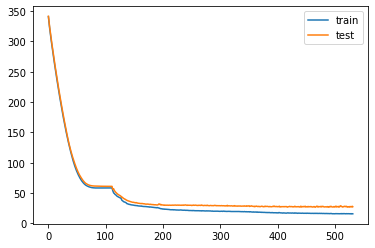


train_max_error: 106.82638549804688
test_max_error: 159.8597412109375
Train R2 = 0.90.
Test R2 = 0.71.

Epoch: 0, loss:121228.2344,  mae:340.6891,  mse:121228.2344,  val_loss:115897.2812,  val_mae:334.1715,  val_mse:115897.2734,  
....................................................................................................
Epoch: 100, loss:5147.2607,  mae:59.3255,  mse:5147.2192,  val_loss:4223.9194,  val_mae:55.2334,  val_mse:4223.8774,  
....................................................................................................
Epoch: 200, loss:1220.0322,  mae:25.6080,  mse:1219.9434,  val_loss:1915.4272,  val_mae:32.5799,  val_mse:1915.3380,  
....................................................................................................
Epoch: 300, loss:903.5578,  mae:21.4311,  mse:903.4523,  val_loss:1770.8877,  val_mae:31.0742,  val_mse:1770.7820,  
....................................................................................................

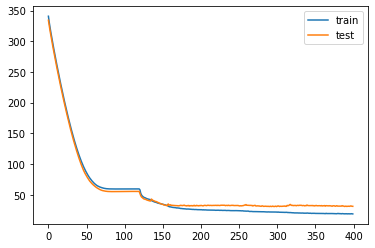


train_max_error: 146.19650268554688
test_max_error: 124.48675537109375
Train R2 = 0.86.
Test R2 = 0.56.

Epoch: 0, loss:121883.3125,  mae:341.9058,  mse:121883.3047,  val_loss:115505.5391,  val_mae:332.1100,  val_mse:115505.5312,  
....................................................................................................
Epoch: 100, loss:5004.5400,  mae:58.7232,  mse:5004.4966,  val_loss:5212.8809,  val_mae:59.5126,  val_mse:5212.8394,  
....................................................................................................
Epoch: 200, loss:1687.0442,  mae:30.5188,  mse:1686.9634,  val_loss:1950.9709,  val_mae:33.7468,  val_mse:1950.8900,  
....................................................................................................
Epoch: 300, loss:1378.9934,  mae:27.2307,  mse:1378.8967,  val_loss:1507.1747,  val_mae:29.4661,  val_mse:1507.0778,  
....................................................................................................
Epoch:

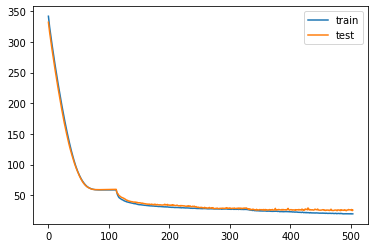


train_max_error: 118.0885009765625
test_max_error: 105.40025024414064
Train R2 = 0.85.
Test R2 = 0.75.

Epoch: 0, loss:121638.4375,  mae:341.3924,  mse:121638.4375,  val_loss:117536.0625,  val_mae:335.7452,  val_mse:117536.0547,  
....................................................................................................
Epoch: 100, loss:5063.2915,  mae:59.0630,  mse:5063.2510,  val_loss:4802.8711,  val_mae:56.9575,  val_mse:4802.8296,  
....................................................................................................
Epoch: 200, loss:1305.9468,  mae:26.8029,  mse:1305.8580,  val_loss:1124.8937,  val_mae:24.7625,  val_mse:1124.8046,  
....................................................................................................
Epoch: 300, loss:1008.4993,  mae:22.9652,  mse:1008.3959,  val_loss:939.2788,  val_mae:22.6708,  val_mse:939.1752,  
..................................................................................

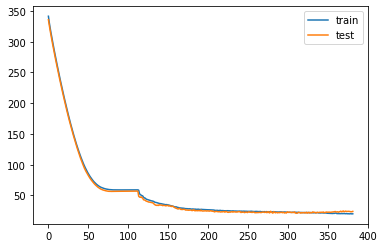


train_max_error: 141.57281494140625
test_max_error: 102.21818847656249
Train R2 = 0.84.
Test R2 = 0.79.

Epoch: 0, loss:122471.6094,  mae:342.6540,  mse:122471.6094,  val_loss:115604.7109,  val_mae:332.5021,  val_mse:115604.7031,  
....................................................................................................
Epoch: 100, loss:5028.3379,  mae:58.7158,  mse:5028.2959,  val_loss:5046.3179,  val_mae:59.5550,  val_mse:5046.2778,  
....................................................................................................
Epoch: 200, loss:1722.1067,  mae:30.9256,  mse:1722.0237,  val_loss:1891.6713,  val_mae:33.7782,  val_mse:1891.5883,  
....................................................................................................
Epoch: 300, loss:1504.3018,  mae:28.2593,  mse:1504.2102,  val_loss:1582.2177,  val_mae:31.8945,  val_mse:1582.1261,  
....................................................................................................
Epoch:

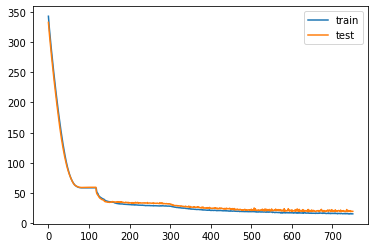


train_max_error: 85.79583740234375
test_max_error: 80.48065185546875
Train R2 = 0.90.
Test R2 = 0.85.

Epoch: 0, loss:121714.3750,  mae:341.5314,  mse:121714.3750,  val_loss:118988.6328,  val_mae:337.8231,  val_mse:118988.6328,  
....................................................................................................
Epoch: 100, loss:5056.3184,  mae:58.9679,  mse:5056.2798,  val_loss:4861.0566,  val_mae:57.6658,  val_mse:4861.0166,  
....................................................................................................
Epoch: 200, loss:1354.2319,  mae:27.2837,  mse:1354.1598,  val_loss:1614.2789,  val_mae:31.2917,  val_mse:1614.2065,  
....................................................................................................
Epoch: 300, loss:1076.2976,  mae:22.2015,  mse:1076.2078,  val_loss:1303.2938,  val_mae:25.9467,  val_mse:1303.2039,  
....................................................................................................
Epoch: 4

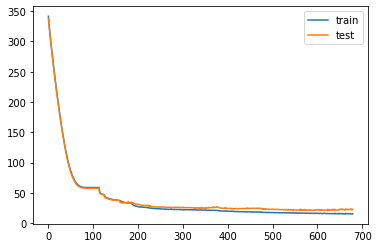


train_max_error: 117.70806884765625
test_max_error: 110.498046875
Train R2 = 0.89.
Test R2 = 0.78.
Units 14

Epoch: 0, loss:120987.9453,  mae:340.6971,  mse:120987.9453,  val_loss:118840.2656,  val_mae:336.0544,  val_mse:118840.2422,  
....................................................................................................
Epoch: 100, loss:4909.2075,  mae:58.0464,  mse:4909.1665,  val_loss:5920.3706,  val_mae:63.7465,  val_mse:5920.3296,  
....................................................................................................
Epoch: 200, loss:1725.4274,  mae:31.1384,  mse:1725.3557,  val_loss:2333.1458,  val_mae:38.5374,  val_mse:2333.0740,  
....................................................................................................
Epoch: 300, loss:1137.1880,  mae:24.0866,  mse:1137.1057,  val_loss:1055.9213,  val_mae:24.4121,  val_mse:1055.8387,  
....................................................................................................
Ep

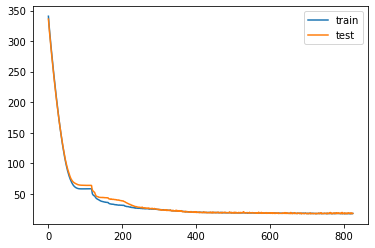


train_max_error: 106.98721313476562
test_max_error: 72.1531982421875
Train R2 = 0.87.
Test R2 = 0.91.

Epoch: 0, loss:120843.8359,  mae:340.2562,  mse:120843.8359,  val_loss:118909.3203,  val_mae:338.2540,  val_mse:118909.3125,  
....................................................................................................
Epoch: 100, loss:5114.6621,  mae:59.0602,  mse:5114.6230,  val_loss:4509.3340,  val_mae:56.6973,  val_mse:4509.2949,  
....................................................................................................
Epoch: 200, loss:1219.5573,  mae:25.8817,  mse:1219.4694,  val_loss:1669.4385,  val_mae:29.2131,  val_mse:1669.3505,  
....................................................................................................
Epoch: 300, loss:982.8458,  mae:22.3384,  mse:982.7396,  val_loss:1553.2836,  val_mae:27.2158,  val_mse:1553.1775,  
....................................................................................................
Epoch: 400

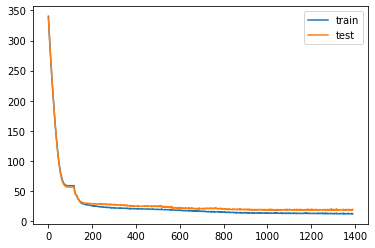


train_max_error: 67.721435546875
test_max_error: 62.0928955078125
Train R2 = 0.95.
Test R2 = 0.86.

Epoch: 0, loss:120493.8594,  mae:339.9583,  mse:120493.8594,  val_loss:121903.5859,  val_mae:340.9643,  val_mse:121903.5859,  
....................................................................................................
Epoch: 100, loss:4942.8193,  mae:58.4119,  mse:4942.7798,  val_loss:5719.2490,  val_mae:61.1907,  val_mse:5719.2095,  
....................................................................................................
Epoch: 200, loss:995.0582,  mae:23.0809,  mse:994.9722,  val_loss:1728.1392,  val_mae:30.0984,  val_mse:1728.0531,  
....................................................................................................
Epoch: 300, loss:753.4532,  mae:19.9344,  mse:753.3544,  val_loss:1762.2319,  val_mae:30.1229,  val_mse:1762.1327,  
.............................

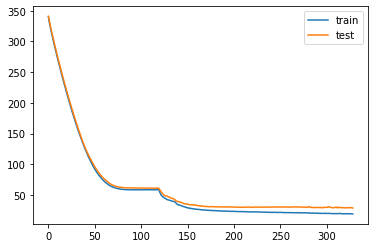


train_max_error: 137.91128540039062
test_max_error: 153.91485595703125
Train R2 = 0.86.
Test R2 = 0.69.

Epoch: 0, loss:122546.2969,  mae:342.5780,  mse:122546.2969,  val_loss:117367.5312,  val_mae:336.3641,  val_mse:117367.5312,  
....................................................................................................
Epoch: 100, loss:5153.2075,  mae:59.3027,  mse:5153.1675,  val_loss:4226.1895,  val_mae:55.1363,  val_mse:4226.1504,  
....................................................................................................
Epoch: 200, loss:1236.4388,  mae:25.7168,  mse:1236.3575,  val_loss:1827.1824,  val_mae:31.6513,  val_mse:1827.1010,  
....................................................................................................
Epoch: 300, loss:922.2573,  mae:21.6181,  mse:922.1662,  val_loss:1717.8418,  val_mae:29.3165,  val_mse:1717.7506,  
....................................................................................................
Epoch: 4

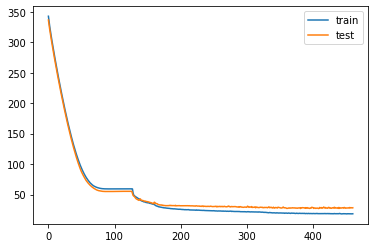


train_max_error: 138.25689697265625
test_max_error: 123.04937744140625
Train R2 = 0.87.
Test R2 = 0.60.

Epoch: 0, loss:122704.0938,  mae:343.0330,  mse:122704.0938,  val_loss:116484.3047,  val_mae:333.5829,  val_mse:116484.2891,  
....................................................................................................
Epoch: 100, loss:5010.7407,  mae:58.7138,  mse:5010.6997,  val_loss:5207.8789,  val_mae:59.4147,  val_mse:5207.8374,  
....................................................................................................
Epoch: 200, loss:1810.4465,  mae:32.6767,  mse:1810.3789,  val_loss:2112.9712,  val_mae:35.6879,  val_mse:2112.9036,  
....................................................................................................
Epoch: 300, loss:1164.1218,  mae:24.5416,  mse:1164.0459,  val_loss:1398.3878,  val_mae:25.9701,  val_mse:1398.3120,  
....................................................................................................
Epoch:

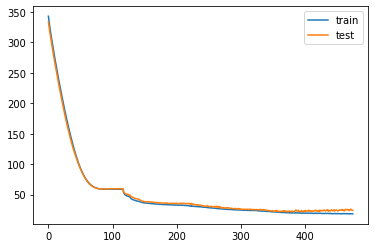


train_max_error: 116.79791259765625
test_max_error: 112.87515258789062
Train R2 = 0.87.
Test R2 = 0.76.

Epoch: 0, loss:122212.8828,  mae:342.2626,  mse:122212.8828,  val_loss:118540.5469,  val_mae:337.2405,  val_mse:118540.5312,  
....................................................................................................
Epoch: 100, loss:5069.4282,  mae:59.0364,  mse:5069.3887,  val_loss:4807.8018,  val_mae:56.9032,  val_mse:4807.7627,  
....................................................................................................
Epoch: 200, loss:1396.3489,  mae:27.3170,  mse:1396.2710,  val_loss:1216.3506,  val_mae:24.6479,  val_mse:1216.2728,  
....................................................................................................
Epoch: 300, loss:1062.9512,  mae:23.2977,  mse:1062.8594,  val_loss:1055.9076,  val_mae:23.4770,  val_mse:1055.8159,  
....................................................................................................
Epoch:

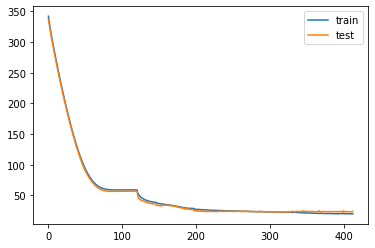


train_max_error: 145.381591796875
test_max_error: 101.12419433593749
Train R2 = 0.84.
Test R2 = 0.77.

Epoch: 0, loss:122492.6562,  mae:342.7245,  mse:122492.6562,  val_loss:116127.2812,  val_mae:333.2970,  val_mse:116127.2812,  
....................................................................................................
Epoch: 100, loss:5034.6646,  mae:58.6833,  mse:5034.6216,  val_loss:5039.9956,  val_mae:59.5180,  val_mse:5039.9531,  
....................................................................................................
Epoch: 200, loss:1738.6874,  mae:31.2664,  mse:1738.6101,  val_loss:1874.4946,  val_mae:33.9825,  val_mse:1874.4174,  
....................................................................................................
Epoch: 300, loss:1484.0684,  mae:27.9968,  mse:1483.9720,  val_loss:1617.1564,  val_mae:32.0621,  val_mse:1617.0604,  
....................................................................................................
Epoch: 4

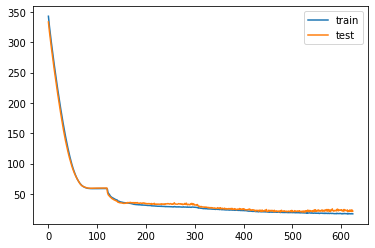


train_max_error: 100.97781372070312
test_max_error: 87.55463867187501
Train R2 = 0.88.
Test R2 = 0.82.

Epoch: 0, loss:121445.5625,  mae:341.1708,  mse:121445.5625,  val_loss:118977.0391,  val_mae:337.8030,  val_mse:118977.0312,  
....................................................................................................
Epoch: 100, loss:5061.6475,  mae:58.9260,  mse:5061.6094,  val_loss:4870.0835,  val_mae:57.6435,  val_mse:4870.0454,  
....................................................................................................
Epoch: 200, loss:1821.8259,  mae:32.3180,  mse:1821.7544,  val_loss:1618.5321,  val_mae:31.7070,  val_mse:1618.4604,  
....................................................................................................
Epoch: 300, loss:1332.9315,  mae:26.9353,  mse:1332.8530,  val_loss:1713.3347,  val_mae:33.2088,  val_mse:1713.2563,  
................

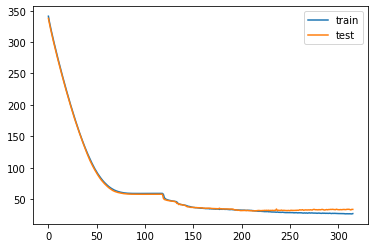


train_max_error: 163.36117553710938
test_max_error: 118.93583461216474
Train R2 = 0.75.
Test R2 = 0.64.
Units 13

Epoch: 0, loss:121601.9609,  mae:341.5428,  mse:121601.9609,  val_loss:119503.0625,  val_mae:337.0453,  val_mse:119503.0625,  
....................................................................................................
Epoch: 100, loss:4923.9111,  mae:58.0075,  mse:4923.8735,  val_loss:5934.3501,  val_mae:63.8258,  val_mse:5934.3130,  
....................................................................................................
Epoch: 200, loss:1745.0928,  mae:30.9556,  mse:1745.0256,  val_loss:2495.7915,  val_mae:38.8447,  val_mse:2495.7244,  
....................................................................................................
Epoch: 300, loss:1446.8811,  mae:28.4051,  mse:1446.8101,  val_loss:1746.6488,  val_mae:31.2664,  val_mse:1746.5776,  
..................................................................................................

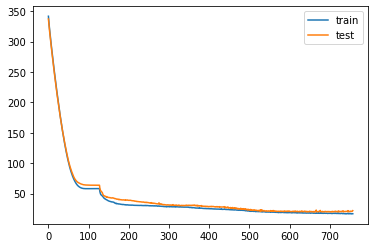


train_max_error: 88.58436279296876
test_max_error: 72.03287963867189
Train R2 = 0.88.
Test R2 = 0.86.

Epoch: 0, loss:121588.7578,  mae:341.2760,  mse:121588.7578,  val_loss:119913.5469,  val_mae:339.7293,  val_mse:119913.5469,  
....................................................................................................
Epoch: 100, loss:5131.5625,  mae:59.0424,  mse:5131.5259,  val_loss:4536.3228,  val_mae:56.6650,  val_mse:4536.2856,  
....................................................................................................
Epoch: 200, loss:1818.3501,  mae:32.8991,  mse:1818.2881,  val_loss:2116.1350,  val_mae:34.9459,  val_mse:2116.0728,  
....................................................................................................
Epoch: 300, loss:1404.5632,  mae:27.9755,  mse:1404.4976,  val_loss:1908.7103,  val_mae:30.1816,  val_mse:1908.6449,  
....................................................................................................
Epoch: 4

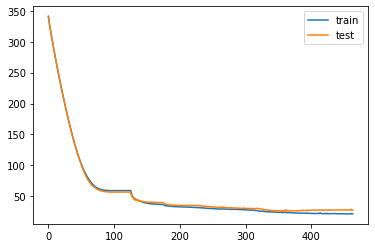


train_max_error: 133.68072509765625
test_max_error: 145.7441864013672
Train R2 = 0.83.
Test R2 = 0.64.

Epoch: 0, loss:121940.0938,  mae:342.0045,  mse:121940.0938,  val_loss:123725.3516,  val_mae:343.6253,  val_mse:123725.3516,  
....................................................................................................
Epoch: 100, loss:4958.7754,  mae:58.3681,  mse:4958.7368,  val_loss:5760.3628,  val_mae:61.2918,  val_mse:5760.3242,  
....................................................................................................
Epoch: 200, loss:1243.1244,  mae:26.0434,  mse:1243.0526,  val_loss:1791.9578,  val_mae:31.9058,  val_mse:1791.8857,  
....................................................................................................
Epoch: 300, loss:945.0955,  mae:22.1893,  mse:945.0167,  val_loss:1527.9950,  val_mae:28.8233,  val_mse:1527.9164,  
....................................................................................................
Epoch: 40

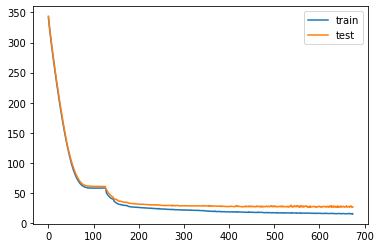


train_max_error: 112.06533813476562
test_max_error: 136.81036376953125
Train R2 = 0.91.
Test R2 = 0.74.

Epoch: 0, loss:121938.5078,  mae:341.7502,  mse:121938.5078,  val_loss:117028.3594,  val_mae:335.8603,  val_mse:117028.3516,  
....................................................................................................
Epoch: 100, loss:5169.2539,  mae:59.2834,  mse:5169.2163,  val_loss:4236.6953,  val_mae:55.0277,  val_mse:4236.6572,  
....................................................................................................
Epoch: 200, loss:1265.2653,  mae:26.0365,  mse:1265.1848,  val_loss:1971.2061,  val_mae:32.8478,  val_mse:1971.1255,  
....................................................................................................
Epoch: 300, loss:1112.7450,  mae:23.8597,  mse:1112.6482,  val_loss:1821.3341,  val_mae:31.0343,  val_mse:1821.2369,  
....................................................................................................
Epoch:

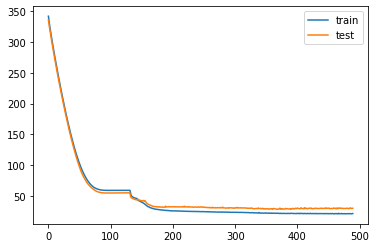


train_max_error: 159.42428588867188
test_max_error: 127.1953125
Train R2 = 0.82.
Test R2 = 0.57.

Epoch: 0, loss:122888.8125,  mae:343.3702,  mse:122888.7969,  val_loss:116926.0547,  val_mae:334.2497,  val_mse:116926.0547,  
....................................................................................................
Epoch: 100, loss:5027.0845,  mae:58.6840,  mse:5027.0449,  val_loss:5204.0854,  val_mae:59.2389,  val_mse:5204.0469,  
....................................................................................................
Epoch: 200, loss:1450.2308,  mae:29.3294,  mse:1450.1638,  val_loss:1565.8065,  val_mae:30.6380,  val_mse:1565.7393,  
....................................................................................................
Epoch: 300, loss:1115.2113,  mae:24.1160,  mse:1115.1371,  val_loss:1551.7173,  val_mae:28.4837,  val_mse:1551.6431,  
................

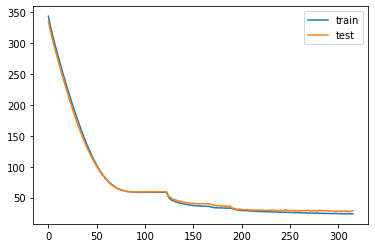


train_max_error: 151.81866455078125
test_max_error: 110.44270019531251
Train R2 = 0.79.
Test R2 = 0.69.

Epoch: 0, loss:121552.1172,  mae:341.3082,  mse:121552.1172,  val_loss:117808.8359,  val_mae:336.1594,  val_mse:117808.8359,  
....................................................................................................
Epoch: 100, loss:5084.0518,  mae:59.0136,  mse:5084.0142,  val_loss:4821.1494,  val_mae:56.8426,  val_mse:4821.1118,  
....................................................................................................
Epoch: 200, loss:1301.3795,  mae:26.3049,  mse:1301.3009,  val_loss:1069.7966,  val_mae:23.6292,  val_mse:1069.7180,  
....................................................................................................
Epoch: 300, loss:1036.8009,  mae:22.8894,  mse:1036.7115,  val_loss:957.5271,  val_mae:21.9095,  val_mse:957.4375,  
....................................................................................................

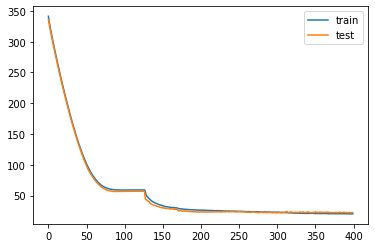


train_max_error: 145.41796875
test_max_error: 92.57677001953124
Train R2 = 0.84.
Test R2 = 0.79.

Epoch: 0, loss:122135.9062,  mae:342.2099,  mse:122135.9062,  val_loss:115498.1641,  val_mae:332.3507,  val_mse:115498.1484,  
....................................................................................................
Epoch: 100, loss:5049.7871,  mae:58.6558,  mse:5049.7495,  val_loss:5035.2935,  val_mae:59.4548,  val_mse:5035.2563,  
....................................................................................................
Epoch: 200, loss:1873.8246,  mae:32.3402,  mse:1873.7593,  val_loss:1712.6818,  val_mae:34.4713,  val_mse:1712.6165,  
....................................................................................................
Epoch: 300, loss:1481.0084,  mae:27.8718,  mse:1480.9250,  val_loss:1632.3346,  val_mae:32.3382,  val_mse:1632.2518,  
....................................................................................................
Epoch: 400, l

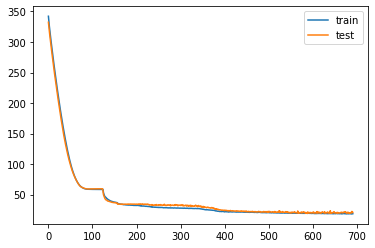


train_max_error: 97.75518798828125
test_max_error: 81.8431396484375
Train R2 = 0.86.
Test R2 = 0.86.

Epoch: 0, loss:121427.3828,  mae:341.1262,  mse:121427.3828,  val_loss:118896.8047,  val_mae:337.6851,  val_mse:118896.8047,  
....................................................................................................
Epoch: 100, loss:5077.4326,  mae:58.8991,  mse:5077.3979,  val_loss:4887.8926,  val_mae:57.6450,  val_mse:4887.8579,  
....................................................................................................
Epoch: 200, loss:1989.3821,  mae:35.0389,  mse:1989.3285,  val_loss:2015.9741,  val_mae:36.3328,  val_mse:2015.9203,  
....................................................................................................
Epoch: 300, loss:1122.7971,  mae:23.8635,  mse:1122.7252,  val_loss:1352.6216,  val_mae:27.0061,  val_mse:1352.5494,  
....................................................................................................
Epoch: 40

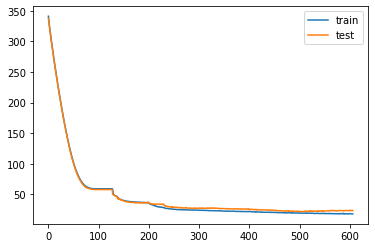


train_max_error: 122.52041625976562
test_max_error: 112.119140625
Train R2 = 0.87.
Test R2 = 0.79.
Units 12

Epoch: 0, loss:122601.2656,  mae:343.0450,  mse:122601.2656,  val_loss:120805.3750,  val_mae:338.9590,  val_mse:120805.3750,  
....................................................................................................
Epoch: 100, loss:4971.6177,  mae:58.0096,  mse:4971.5811,  val_loss:5980.3853,  val_mae:63.9956,  val_mse:5980.3491,  
....................................................................................................
Epoch: 200, loss:1796.5609,  mae:31.8512,  mse:1796.5018,  val_loss:2677.6235,  val_mae:39.6557,  val_mse:2677.5645,  
....................................................................................................
Epoch: 300, loss:1455.2998,  mae:28.7347,  mse:1455.2363,  val_loss:1746.4298,  val_mae:31.3616,  val_mse:1746.3663,  
....................................................................................................
Ep

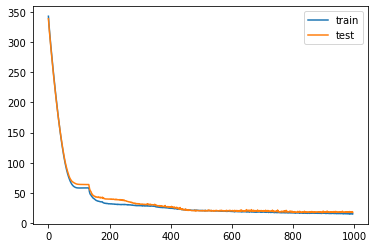


train_max_error: 92.33261108398438
test_max_error: 74.54248046875
Train R2 = 0.91.
Test R2 = 0.91.

Epoch: 0, loss:122083.9141,  mae:341.9489,  mse:122083.9141,  val_loss:120670.1875,  val_mae:340.8522,  val_mse:120670.1875,  
....................................................................................................
Epoch: 100, loss:5180.4141,  mae:59.0626,  mse:5180.3774,  val_loss:4601.9780,  val_mae:56.7430,  val_mse:4601.9424,  
....................................................................................................
Epoch: 200, loss:1831.4551,  mae:33.8362,  mse:1831.3961,  val_loss:2753.7646,  val_mae:40.5182,  val_mse:2753.7063,  
....................................................................................................
Epoch: 300, loss:1048.2422,  mae:23.0867,  mse:1048.1670,  val_loss:1875.3960,  val_mae:29.5158,  val_mse:1875.3208,  
....................................................................................................
Epoch: 400,

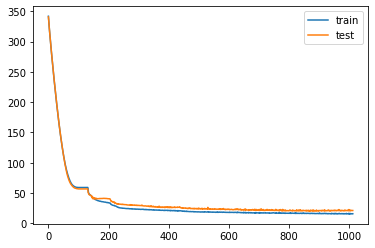


train_max_error: 102.4979248046875
test_max_error: 129.27638753255172
Train R2 = 0.90.
Test R2 = 0.75.

Epoch: 0, loss:121596.9062,  mae:341.5478,  mse:121596.9062,  val_loss:123616.5078,  val_mae:343.4746,  val_mse:123616.5078,  
....................................................................................................
Epoch: 100, loss:5005.5107,  mae:58.3897,  mse:5005.4746,  val_loss:5846.2402,  val_mae:61.4544,  val_mse:5846.2051,  
....................................................................................................
Epoch: 200, loss:1322.9722,  mae:27.3814,  mse:1322.9025,  val_loss:1872.4808,  val_mae:32.6343,  val_mse:1872.4114,  
....................................................................................................
Epoch: 300, loss:807.2634,  mae:20.6400,  mse:807.1810,  val_loss:1615.6794,  val_mae:29.3026,  val_mse:1615.5972,  
....................................................................................................
Epoch: 40

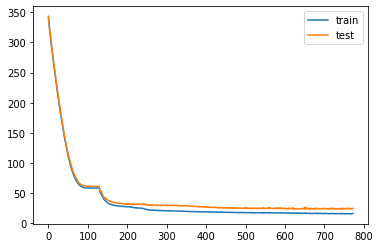


train_max_error: 114.66836547851562
test_max_error: 134.96267700195312
Train R2 = 0.90.
Test R2 = 0.78.

Epoch: 0, loss:122673.3125,  mae:342.7606,  mse:122673.3125,  val_loss:118074.5078,  val_mae:337.4131,  val_mse:118074.5078,  
....................................................................................................
Epoch: 100, loss:5217.0767,  mae:59.2949,  mse:5217.0400,  val_loss:4273.9771,  val_mae:55.0301,  val_mse:4273.9399,  
....................................................................................................
Epoch: 200, loss:1720.0757,  mae:31.7648,  mse:1720.0132,  val_loss:2409.8123,  val_mae:38.3605,  val_mse:2409.7500,  
....................................................................................................
Epoch: 300, loss:1044.4126,  mae:23.7351,  mse:1044.3384,  val_loss:2070.3389,  val_mae:34.2145,  val_mse:2070.2649,  
....................................................................................................
Epoch:

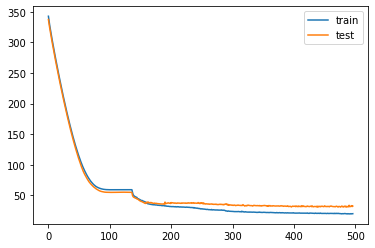


train_max_error: 139.38885498046875
test_max_error: 106.4777770996094
Train R2 = 0.85.
Test R2 = 0.56.

Epoch: 0, loss:122893.6328,  mae:343.3322,  mse:122893.6328,  val_loss:117069.7344,  val_mae:334.4625,  val_mse:117069.7344,  
....................................................................................................
Epoch: 100, loss:5073.1660,  mae:58.6991,  mse:5073.1289,  val_loss:5216.7104,  val_mae:59.0990,  val_mse:5216.6748,  
....................................................................................................
Epoch: 200, loss:1752.4189,  mae:32.4915,  mse:1752.3583,  val_loss:1779.8507,  val_mae:33.8348,  val_mse:1779.7900,  
....................................................................................................
Epoch: 300, loss:969.3433,  mae:22.5166,  mse:969.2698,  val_loss:1191.3568,  val_mae:24.8525,  val_mse:1191.2833,  
....................................................................................................
Epoch: 40

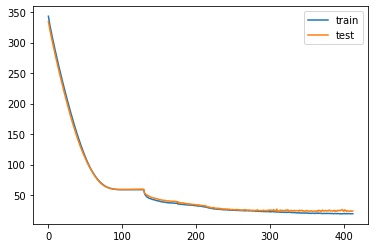


train_max_error: 131.17547607421875
test_max_error: 99.26649169921876
Train R2 = 0.86.
Test R2 = 0.78.

Epoch: 0, loss:122280.3125,  mae:342.3333,  mse:122280.3125,  val_loss:118816.2266,  val_mae:337.6489,  val_mse:118816.2266,  
....................................................................................................
Epoch: 100, loss:5131.8750,  mae:59.0656,  mse:5131.8398,  val_loss:4862.5371,  val_mae:56.7343,  val_mse:4862.5010,  
....................................................................................................
Epoch: 200, loss:1348.0255,  mae:26.8554,  mse:1347.9568,  val_loss:1167.7487,  val_mae:24.6450,  val_mse:1167.6798,  
....................................................................................................
Epoch: 300, loss:1046.8624,  mae:22.8275,  mse:1046.7819,  val_loss:876.3033,  val_mae:20.6818,  val_mse:876.2227,  
................................................................................................

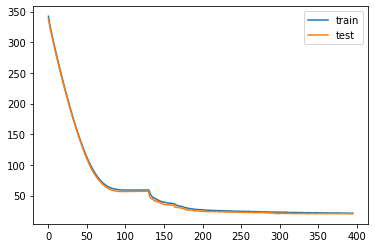


train_max_error: 147.20553588867188
test_max_error: 111.97879028320312
Train R2 = 0.82.
Test R2 = 0.80.

Epoch: 0, loss:123793.8906,  mae:344.6044,  mse:123793.8906,  val_loss:117985.2500,  val_mae:336.0737,  val_mse:117985.2500,  
....................................................................................................
Epoch: 100, loss:5099.9126,  mae:58.6800,  mse:5099.8745,  val_loss:5046.5742,  val_mae:59.3394,  val_mse:5046.5361,  
....................................................................................................
Epoch: 200, loss:1363.4554,  mae:27.2473,  mse:1363.3856,  val_loss:1276.0988,  val_mae:27.5140,  val_mse:1276.0284,  
....................................................................................................
Epoch: 300, loss:1079.6484,  mae:23.3670,  mse:1079.5677,  val_loss:932.1646,  val_mae:24.4067,  val_mse:932.0842,  
....................................................................................................
Epoch: 4

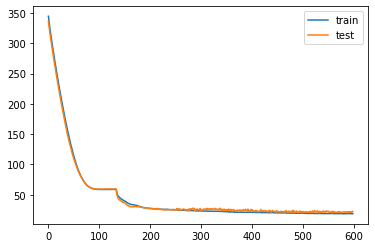


train_max_error: 110.6904296875
test_max_error: 94.75283813476562
Train R2 = 0.86.
Test R2 = 0.83.

Epoch: 0, loss:122642.6641,  mae:342.8673,  mse:122642.6641,  val_loss:120389.7969,  val_mae:339.8983,  val_mse:120389.7969,  
....................................................................................................
Epoch: 100, loss:5124.4941,  mae:58.9033,  mse:5124.4595,  val_loss:4941.3242,  val_mae:57.7011,  val_mse:4941.2886,  
....................................................................................................
Epoch: 200, loss:2031.7412,  mae:35.5222,  mse:2031.6880,  val_loss:2057.4949,  val_mae:36.5270,  val_mse:2057.4407,  
....................................................................................................
Epoch: 300, loss:1473.7422,  mae:28.4573,  mse:1473.6760,  val_loss:1534.4479,  val_mae:30.5957,  val_mse:1534.3821,  
....................................................................................................
Epoch: 400,

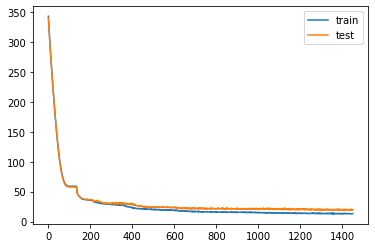


train_max_error: 83.23592325846386
test_max_error: 84.28861490885453
Train R2 = 0.93.
Test R2 = 0.86.
Units 11

Epoch: 0, loss:121883.7656,  mae:342.0247,  mse:121883.7656,  val_loss:120369.6953,  val_mae:338.3252,  val_mse:120369.6953,  
....................................................................................................
Epoch: 100, loss:5091.6147,  mae:58.2283,  mse:5091.5801,  val_loss:6091.0884,  val_mae:64.4325,  val_mse:6091.0542,  
....................................................................................................
Epoch: 200, loss:1362.0575,  mae:27.1673,  mse:1361.9922,  val_loss:1348.6300,  val_mae:28.7008,  val_mse:1348.5646,  
....................................................................................................
Epoch: 300, loss:1034.4191,  mae:22.7348,  mse:1034.3395,  val_loss:986.7833,  val_mae:22.0866,  val_mse:986.7034,  
....................................................................................................
E

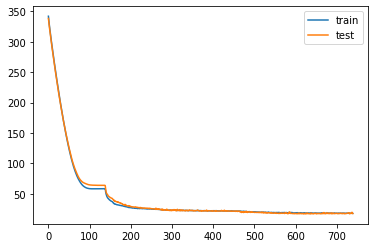


train_max_error: 112.09884643554688
test_max_error: 95.11358642578125
Train R2 = 0.88.
Test R2 = 0.90.

Epoch: 0, loss:122380.6328,  mae:342.4552,  mse:122380.6328,  val_loss:121317.4922,  val_mae:341.8072,  val_mse:121317.5000,  
....................................................................................................
Epoch: 100, loss:5307.8760,  mae:59.3410,  mse:5307.8398,  val_loss:4752.4707,  val_mae:57.2537,  val_mse:4752.4351,  
....................................................................................................
Epoch: 200, loss:1806.3143,  mae:33.7066,  mse:1806.2589,  val_loss:2746.1692,  val_mae:40.2033,  val_mse:2746.1138,  
....................................................................................................
Epoch: 300, loss:1046.7551,  mae:23.1441,  mse:1046.6857,  val_loss:1898.5648,  val_mae:29.4111,  val_mse:1898.4956,  
....................................................................................................
Epoch: 

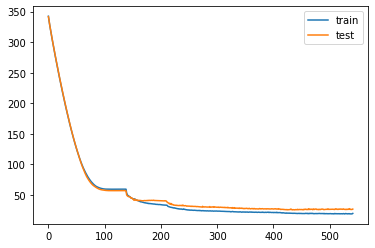


train_max_error: 132.16522216796875
test_max_error: 145.13723754882812
Train R2 = 0.86.
Test R2 = 0.65.

Epoch: 0, loss:122656.9531,  mae:343.0815,  mse:122656.9531,  val_loss:124936.3828,  val_mae:345.3792,  val_mse:124936.3828,  
....................................................................................................
Epoch: 100, loss:5120.3398,  mae:58.6853,  mse:5120.3062,  val_loss:6016.2739,  val_mae:61.7332,  val_mse:6016.2397,  
....................................................................................................
Epoch: 200, loss:1734.8441,  mae:31.4186,  mse:1734.7878,  val_loss:2312.7207,  val_mae:37.5217,  val_mse:2312.6643,  
....................................................................................................
Epoch: 300, loss:863.4216,  mae:21.1042,  mse:863.3475,  val_loss:1574.0856,  val_mae:28.1239,  val_mse:1574.0118,  
....................................................................................................
Epoch: 4

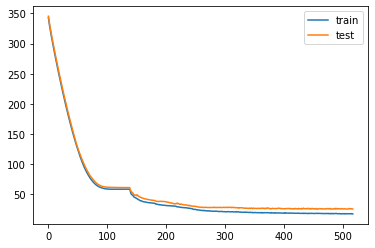


train_max_error: 130.80081176757812
test_max_error: 167.77413940429688
Train R2 = 0.88.
Test R2 = 0.72.

Epoch: 0, loss:123187.4219,  mae:343.5479,  mse:123187.4219,  val_loss:118899.5234,  val_mae:338.6289,  val_mse:118899.5234,  
....................................................................................................
Epoch: 100, loss:5346.0776,  mae:59.5941,  mse:5346.0405,  val_loss:4378.8926,  val_mae:55.2574,  val_mse:4378.8560,  
....................................................................................................
Epoch: 200, loss:1846.5032,  mae:33.0311,  mse:1846.4480,  val_loss:2391.0833,  val_mae:37.3920,  val_mse:2391.0278,  
....................................................................................................
Epoch: 300, loss:1046.6217,  mae:23.9584,  mse:1046.5514,  val_loss:2078.1863,  val_mae:31.7641,  val_mse:2078.1162,  
....................................................................................................
Epoch:

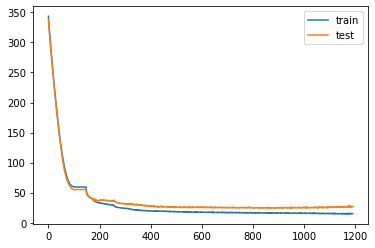


train_max_error: 87.8089599609375
test_max_error: 130.89752197265625
Train R2 = 0.93.
Test R2 = 0.66.

Epoch: 0, loss:122890.1484,  mae:343.3410,  mse:122890.1484,  val_loss:117264.1562,  val_mae:334.7511,  val_mse:117264.1562,  
....................................................................................................
Epoch: 100, loss:5197.7900,  mae:58.9446,  mse:5197.7568,  val_loss:5283.3525,  val_mae:59.2134,  val_mse:5283.3184,  
....................................................................................................
Epoch: 200, loss:2020.4211,  mae:35.1364,  mse:2020.3701,  val_loss:2085.5400,  val_mae:37.6921,  val_mse:2085.4893,  
....................................................................................................
Epoch: 300, loss:1152.9897,  mae:24.4361,  mse:1152.9277,  val_loss:1283.0248,  val_mae:24.6386,  val_mse:1282.9628,  
....................................................................................................
Epoch: 4

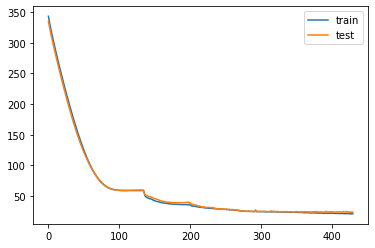


train_max_error: 141.060546875
test_max_error: 99.484619140625
Train R2 = 0.82.
Test R2 = 0.77.

Epoch: 0, loss:122569.2656,  mae:342.8109,  mse:122569.2656,  val_loss:119820.6484,  val_mae:339.1379,  val_mse:119820.6484,  
....................................................................................................
Epoch: 100, loss:5259.9453,  mae:59.3884,  mse:5259.9087,  val_loss:4981.8042,  val_mae:56.6381,  val_mse:4981.7676,  
....................................................................................................
Epoch: 200, loss:1398.9543,  mae:27.5055,  mse:1398.8866,  val_loss:1235.1675,  val_mae:25.9265,  val_mse:1235.0995,  
....................................................................................................
Epoch: 300, loss:1069.4507,  mae:23.3688,  mse:1069.3787,  val_loss:972.8475,  val_mae:21.6425,  val_mse:972.7757,  
....................................................................................................
Epoch: 400, loss

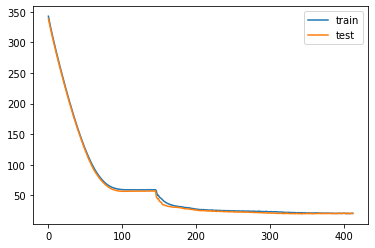


train_max_error: 143.384521484375
test_max_error: 112.479736328125
Train R2 = 0.83.
Test R2 = 0.80.

Epoch: 0, loss:121790.6016,  mae:341.6924,  mse:121790.5938,  val_loss:115611.0625,  val_mae:332.5119,  val_mse:115611.0625,  
....................................................................................................
Epoch: 100, loss:5210.5913,  mae:58.8886,  mse:5210.5571,  val_loss:5102.7573,  val_mae:59.3653,  val_mse:5102.7241,  
....................................................................................................
Epoch: 200, loss:1388.8724,  mae:27.1558,  mse:1388.8085,  val_loss:1155.7433,  val_mae:26.9885,  val_mse:1155.6793,  
....................................................................................................
Epoch: 300, loss:1108.3210,  mae:23.4359,  mse:1108.2507,  val_loss:919.8750,  val_mae:24.0788,  val_mse:919.8044,  
...................................................................................................

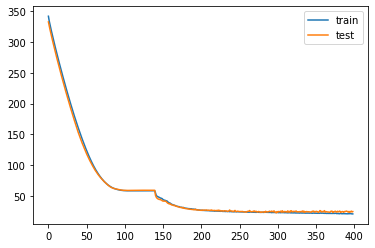


train_max_error: 154.63504028320312
test_max_error: 85.26348266601565
Train R2 = 0.81.
Test R2 = 0.78.

Epoch: 0, loss:122030.5391,  mae:342.0270,  mse:122030.5391,  val_loss:120111.2266,  val_mae:339.4843,  val_mse:120111.2266,  
....................................................................................................
Epoch: 100, loss:5241.0405,  mae:59.1429,  mse:5241.0073,  val_loss:5063.2344,  val_mae:57.9737,  val_mse:5063.2007,  
....................................................................................................
Epoch: 200, loss:1420.2877,  mae:28.0854,  mse:1420.2317,  val_loss:1498.2941,  val_mae:30.2709,  val_mse:1498.2380,  
....................................................................................................
Epoch: 300, loss:1093.0139,  mae:23.3392,  mse:1092.9449,  val_loss:1201.1644,  val_mae:24.7801,  val_mse:1201.0958,  
...................................................................................................

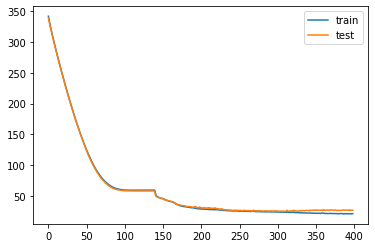


train_max_error: 144.4815673828125
test_max_error: 130.63015747070312
Train R2 = 0.83.
Test R2 = 0.72.
Units 10

Epoch: 0, loss:121889.7578,  mae:341.9958,  mse:121889.7578,  val_loss:120373.4922,  val_mae:338.3246,  val_mse:120373.4922,  
....................................................................................................
Epoch: 100, loss:5360.0063,  mae:59.3285,  mse:5359.9741,  val_loss:6354.9941,  val_mae:65.7956,  val_mse:6354.9629,  
....................................................................................................
Epoch: 200, loss:1545.5153,  mae:30.0028,  mse:1545.4623,  val_loss:1527.1683,  val_mae:30.9620,  val_mse:1527.1155,  
....................................................................................................
Epoch: 300, loss:1086.7324,  mae:24.2520,  mse:1086.6760,  val_loss:904.0993,  val_mae:22.5841,  val_mse:904.0427,  
....................................................................................................


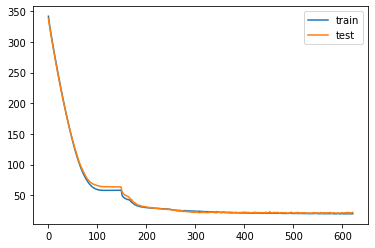


train_max_error: 120.14730834960938
test_max_error: 74.28335571289062
Train R2 = 0.84.
Test R2 = 0.86.

Epoch: 0, loss:122129.6719,  mae:342.1042,  mse:122129.6719,  val_loss:120785.0859,  val_mae:341.0228,  val_mse:120785.0859,  
....................................................................................................
Epoch: 100, loss:5562.3623,  mae:60.4727,  mse:5562.3320,  val_loss:5035.1211,  val_mae:58.2613,  val_mse:5035.0908,  
....................................................................................................
Epoch: 200, loss:1909.0568,  mae:34.5047,  mse:1909.0081,  val_loss:2741.8054,  val_mae:39.8128,  val_mse:2741.7563,  
....................................................................................................
Epoch: 300, loss:1160.4657,  mae:24.8006,  mse:1160.4077,  val_loss:2200.0647,  val_mae:32.4525,  val_mse:2200.0071,  
....................................................................................................
Epoch: 

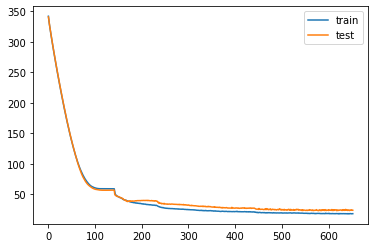


train_max_error: 120.62542724609375
test_max_error: 146.30339558919235
Train R2 = 0.87.
Test R2 = 0.68.

Epoch: 0, loss:121705.8984,  mae:341.6787,  mse:121705.8984,  val_loss:123985.9922,  val_mae:344.0107,  val_mse:123985.9844,  
....................................................................................................
Epoch: 100, loss:5393.9722,  mae:59.9173,  mse:5393.9399,  val_loss:6373.7183,  val_mae:62.8214,  val_mse:6373.6870,  
....................................................................................................
Epoch: 200, loss:1367.0393,  mae:27.6906,  mse:1366.9850,  val_loss:1806.7750,  val_mae:31.7823,  val_mse:1806.7205,  
....................................................................................................
Epoch: 300, loss:1032.8495,  mae:23.1237,  mse:1032.7877,  val_loss:1463.5546,  val_mae:28.4864,  val_mse:1463.4929,  
....................................................................................................
Epoch:

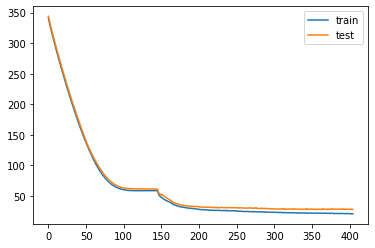


train_max_error: 127.44035339355469
test_max_error: 151.07626342773438
Train R2 = 0.83.
Test R2 = 0.73.

Epoch: 0, loss:123305.4844,  mae:343.7527,  mse:123305.4844,  val_loss:119260.3750,  val_mae:339.1685,  val_mse:119260.3750,  
....................................................................................................
Epoch: 100, loss:5643.4258,  mae:60.8064,  mse:5643.3896,  val_loss:4648.0259,  val_mae:56.5453,  val_mse:4647.9922,  
....................................................................................................
Epoch: 200, loss:1371.4303,  mae:27.5757,  mse:1371.3707,  val_loss:2000.5088,  val_mae:32.3841,  val_mse:2000.4495,  
....................................................................................................
Epoch: 300, loss:1000.2361,  mae:22.7556,  mse:1000.1738,  val_loss:1846.4122,  val_mae:32.1811,  val_mse:1846.3497,  
....................................................................................................
Epoch:

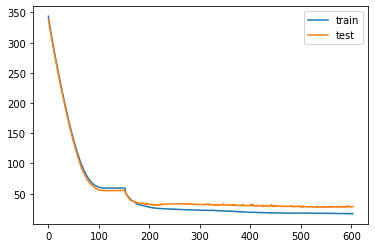


train_max_error: 132.0055389404297
test_max_error: 137.56936645507812
Train R2 = 0.88.
Test R2 = 0.60.

Epoch: 0, loss:123000.3828,  mae:343.5105,  mse:123000.3828,  val_loss:117624.7656,  val_mae:335.2858,  val_mse:117624.7656,  
....................................................................................................
Epoch: 100, loss:5482.8882,  mae:60.1459,  mse:5482.8560,  val_loss:5486.7573,  val_mae:59.9029,  val_mse:5486.7251,  
....................................................................................................
Epoch: 200, loss:2171.3542,  mae:35.9751,  mse:2171.3064,  val_loss:2216.2734,  val_mae:37.9093,  val_mse:2216.2258,  
....................................................................................................
Epoch: 300, loss:1211.0602,  mae:24.9287,  mse:1211.0056,  val_loss:1255.4100,  val_mae:24.5357,  val_mse:1255.3555,  
....................................................................................................
Epoch: 

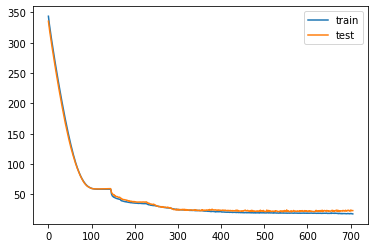


train_max_error: 110.93167114257812
test_max_error: 92.10493164062501
Train R2 = 0.87.
Test R2 = 0.79.

Epoch: 0, loss:122997.4922,  mae:343.4590,  mse:122997.4922,  val_loss:120261.3516,  val_mae:339.7935,  val_mse:120261.3516,  
....................................................................................................
Epoch: 100, loss:5542.2192,  mae:60.5964,  mse:5542.1885,  val_loss:5250.3994,  val_mae:57.6596,  val_mse:5250.3662,  
....................................................................................................
Epoch: 200, loss:2284.9958,  mae:36.1688,  mse:2284.9431,  val_loss:2291.6145,  val_mae:36.8548,  val_mse:2291.5623,  
....................................................................................................
Epoch: 300, loss:1526.5061,  mae:29.8535,  mse:1526.4492,  val_loss:1466.6968,  val_mae:30.5389,  val_mse:1466.6401,  
....................................................................................................
Epoch: 

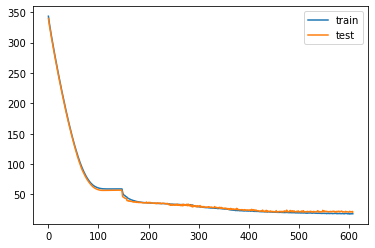


train_max_error: 124.56062316894531
test_max_error: 97.03535766601561
Train R2 = 0.86.
Test R2 = 0.82.

Epoch: 0, loss:122342.5234,  mae:342.5249,  mse:122342.5312,  val_loss:116357.4453,  val_mae:333.6399,  val_mse:116357.4453,  
....................................................................................................
Epoch: 100, loss:5493.1147,  mae:59.9927,  mse:5493.0835,  val_loss:5295.0195,  val_mae:60.4866,  val_mse:5294.9883,  
....................................................................................................
Epoch: 200, loss:2265.5137,  mae:35.8079,  mse:2265.4644,  val_loss:2506.2710,  val_mae:39.4611,  val_mse:2506.2214,  
....................................................................................................
Epoch: 300, loss:1215.7660,  mae:24.9365,  mse:1215.7136,  val_loss:1144.9575,  val_mae:26.5536,  val_mse:1144.9053,  
....................................................................................................
Epoch: 

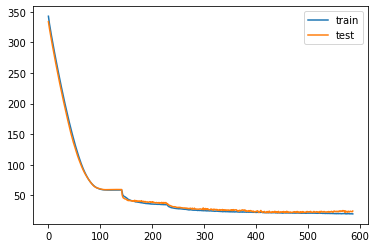


train_max_error: 122.46878051757812
test_max_error: 69.29183959960938
Train R2 = 0.85.
Test R2 = 0.83.

Epoch: 0, loss:123017.5703,  mae:343.4333,  mse:123017.5703,  val_loss:121336.4844,  val_mae:341.2920,  val_mse:121336.4766,  
....................................................................................................
Epoch: 100, loss:5540.8115,  mae:60.4641,  mse:5540.7808,  val_loss:5367.3506,  val_mae:59.1901,  val_mse:5367.3193,  
....................................................................................................
Epoch: 200, loss:1716.1532,  mae:32.3886,  mse:1716.1028,  val_loss:1861.0201,  val_mae:33.9211,  val_mse:1860.9695,  
....................................................................................................
Epoch: 300, loss:1112.3274,  mae:23.8419,  mse:1112.2710,  val_loss:1313.7073,  val_mae:26.7738,  val_mse:1313.6510,  
....................................................................................................
Epoch: 

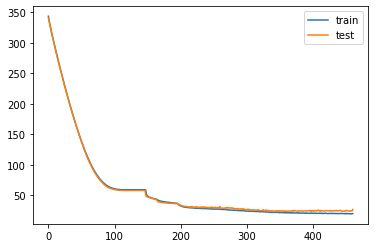


train_max_error: 128.5294189453125
test_max_error: 109.14797973632812
Train R2 = 0.83.
Test R2 = 0.75.
Units 9

Epoch: 0, loss:122630.4375,  mae:343.1014,  mse:122630.4375,  val_loss:121338.6172,  val_mae:339.7497,  val_mse:121338.6172,  
....................................................................................................
Epoch: 100, loss:5969.5732,  mae:62.3154,  mse:5969.5439,  val_loss:6948.5664,  val_mae:68.1113,  val_mse:6948.5376,  
....................................................................................................
Epoch: 200, loss:2301.1863,  mae:36.5896,  mse:2301.1438,  val_loss:2705.7810,  val_mae:39.4401,  val_mse:2705.7378,  
....................................................................................................
Epoch: 300, loss:1425.4462,  mae:28.7394,  mse:1425.3987,  val_loss:1496.9443,  val_mae:31.8072,  val_mse:1496.8970,  
....................................................................................................

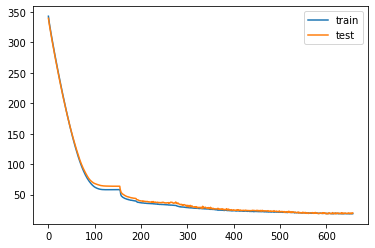


train_max_error: 101.73110961914062
test_max_error: 94.94656372070312
Train R2 = 0.87.
Test R2 = 0.88.

Epoch: 0, loss:122366.2344,  mae:342.4255,  mse:122366.2422,  val_loss:121504.9531,  val_mae:342.0798,  val_mse:121504.9531,  
....................................................................................................
Epoch: 100, loss:6175.4004,  mae:63.3698,  mse:6175.3726,  val_loss:5699.1904,  val_mae:61.4785,  val_mse:5699.1616,  
....................................................................................................
Epoch: 200, loss:1449.6948,  mae:28.9827,  mse:1449.6466,  val_loss:2012.8733,  val_mae:33.0231,  val_mse:2012.8251,  
....................................................................................................
Epoch: 300, loss:1063.2769,  mae:23.4660,  mse:1063.2185,  val_loss:1846.8828,  val_mae:29.5495,  val_mse:1846.8250,  
....................................................................................................
Epoch: 

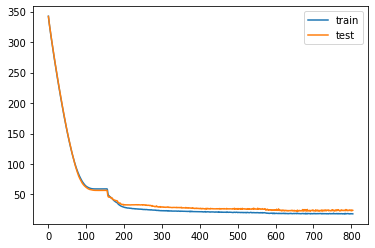


train_max_error: 117.5882568359375
test_max_error: 138.58470153808594
Train R2 = 0.87.
Test R2 = 0.70.

Epoch: 0, loss:122328.6797,  mae:342.6194,  mse:122328.6797,  val_loss:125193.6797,  val_mae:345.7592,  val_mse:125193.6953,  
....................................................................................................
Epoch: 100, loss:6024.9766,  mae:62.9909,  mse:6024.9468,  val_loss:7115.1636,  val_mae:66.0458,  val_mse:7115.1323,  
....................................................................................................
Epoch: 200, loss:1469.7045,  mae:29.7675,  mse:1469.6558,  val_loss:1940.0691,  val_mae:32.7742,  val_mse:1940.0201,  
....................................................................................................
Epoch: 300, loss:899.5855,  mae:21.6981,  mse:899.5292,  val_loss:1716.6072,  val_mae:30.3902,  val_mse:1716.5509,  
....................................................................................................
Epoch: 40

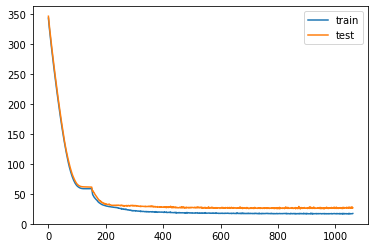


train_max_error: 116.66986083984375
test_max_error: 135.9967041015625
Train R2 = 0.89.
Test R2 = 0.76.

Epoch: 0, loss:123682.7656,  mae:344.2708,  mse:123682.7656,  val_loss:119674.8516,  val_mae:339.7751,  val_mse:119674.8516,  
....................................................................................................
Epoch: 100, loss:6254.6572,  mae:63.6664,  mse:6254.6265,  val_loss:5211.2598,  val_mae:59.9018,  val_mse:5211.2295,  
....................................................................................................
Epoch: 200, loss:1590.9106,  mae:30.0993,  mse:1590.8627,  val_loss:2142.3845,  val_mae:34.1120,  val_mse:2142.3362,  
....................................................................................................
Epoch: 300, loss:1060.7664,  mae:23.2944,  mse:1060.7125,  val_loss:1891.1396,  val_mae:32.3120,  val_mse:1891.0861,  
..........................................................

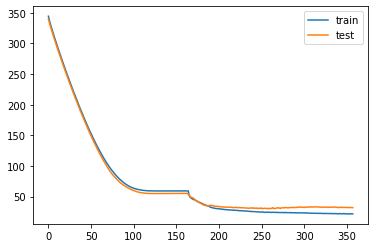


train_max_error: 151.14166259765625
test_max_error: 139.87469482421875
Train R2 = 0.82.
Test R2 = 0.55.

Epoch: 0, loss:123042.3281,  mae:343.5386,  mse:123042.3281,  val_loss:117899.0312,  val_mae:335.6971,  val_mse:117899.0312,  
....................................................................................................
Epoch: 100, loss:6113.8623,  mae:63.0889,  mse:6113.8315,  val_loss:5990.5513,  val_mae:62.7648,  val_mse:5990.5205,  
....................................................................................................
Epoch: 200, loss:2227.9480,  mae:36.0862,  mse:2227.9014,  val_loss:2353.2734,  val_mae:36.8267,  val_mse:2353.2266,  
....................................................................................................
Epoch: 300, loss:1503.8862,  mae:29.5045,  mse:1503.8375,  val_loss:1743.4558,  val_mae:31.4999,  val_mse:1743.4066,  
....................................................................................................
Epoch:

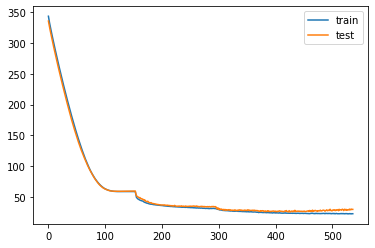


train_max_error: 141.33477783203125
test_max_error: 102.69828491210939
Train R2 = 0.82.
Test R2 = 0.70.

Epoch: 0, loss:122677.8281,  mae:342.9470,  mse:122677.8281,  val_loss:119910.0547,  val_mae:339.2705,  val_mse:119910.0547,  
....................................................................................................
Epoch: 100, loss:6132.4980,  mae:63.4043,  mse:6132.4688,  val_loss:5813.2876,  val_mae:60.4559,  val_mse:5813.2568,  
....................................................................................................
Epoch: 200, loss:2224.0369,  mae:35.6826,  mse:2223.9875,  val_loss:2164.5947,  val_mae:35.9456,  val_mse:2164.5457,  
....................................................................................................
Epoch: 300, loss:1443.9132,  mae:28.5700,  mse:1443.8601,  val_loss:1418.2433,  val_mae:28.9009,  val_mse:1418.1904,  
....................................................................................................
Epoch:

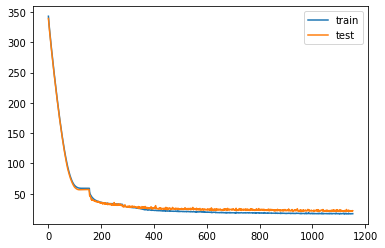


train_max_error: 116.30560302734375
test_max_error: 96.3931884765625
Train R2 = 0.88.
Test R2 = 0.80.

Epoch: 0, loss:122734.2500,  mae:343.1184,  mse:122734.2500,  val_loss:116932.3359,  val_mae:334.4995,  val_mse:116932.3359,  
....................................................................................................
Epoch: 100, loss:6107.7402,  mae:62.9376,  mse:6107.7104,  val_loss:5775.9717,  val_mae:62.7261,  val_mse:5775.9419,  
....................................................................................................
Epoch: 200, loss:2236.1436,  mae:36.0054,  mse:2236.0977,  val_loss:2362.3015,  val_mae:38.3370,  val_mse:2362.2559,  
....................................................................................................
Epoch: 300, loss:1170.3112,  mae:24.8963,  mse:1170.2581,  val_loss:1362.8750,  val_mae:28.5269,  val_mse:1362.8218,  
....................................................................................................
Epoch: 4

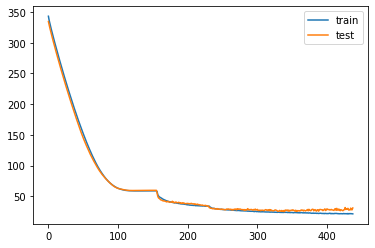


train_max_error: 145.28570556640625
test_max_error: 98.68768310546875
Train R2 = 0.82.
Test R2 = 0.70.

Epoch: 0, loss:123101.6641,  mae:343.5657,  mse:123101.6641,  val_loss:121650.5703,  val_mae:341.7490,  val_mse:121650.5703,  
....................................................................................................
Epoch: 100, loss:6160.4702,  mae:63.4610,  mse:6160.4414,  val_loss:5991.7603,  val_mae:61.7687,  val_mse:5991.7305,  
....................................................................................................
Epoch: 200, loss:2362.7715,  mae:37.2339,  mse:2362.7292,  val_loss:2125.6201,  val_mae:34.9717,  val_mse:2125.5786,  
....................................................................................................
Epoch: 300, loss:1823.4257,  mae:31.6359,  mse:1823.3772,  val_loss:1920.1057,  val_mae:36.6246,  val_mse:1920.0574,  
............................................................

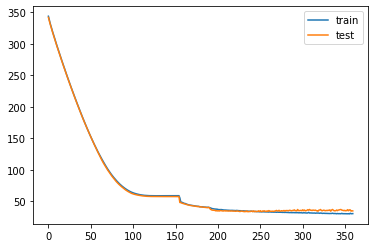


train_max_error: 185.7777099609375
test_max_error: 116.38711547851562
Train R2 = 0.66.
Test R2 = 0.63.
Units 8

Epoch: 0, loss:123363.8516,  mae:344.2004,  mse:123363.8516,  val_loss:122295.1250,  val_mae:341.1527,  val_mse:122295.1250,  
....................................................................................................
Epoch: 100, loss:7194.3608,  mae:68.9225,  mse:7194.3345,  val_loss:8145.8306,  val_mae:73.1206,  val_mse:8145.8042,  
....................................................................................................
Epoch: 200, loss:2430.5762,  mae:38.4193,  mse:2430.5410,  val_loss:2977.3484,  val_mae:42.0586,  val_mse:2977.3127,  
....................................................................................................
Epoch: 300, loss:1547.0320,  mae:29.7093,  mse:1546.9910,  val_loss:1745.6653,  val_mae:33.8755,  val_mse:1745.6243,  
....................................................................................................

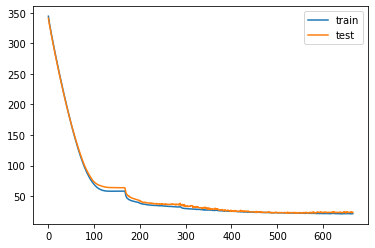


train_max_error: 123.0341796875
test_max_error: 74.10968017578125
Train R2 = 0.83.
Test R2 = 0.85.

Epoch: 0, loss:123749.0469,  mae:344.4533,  mse:123749.0469,  val_loss:122972.0234,  val_mae:344.2185,  val_mse:122972.0234,  
....................................................................................................
Epoch: 100, loss:7386.2896,  mae:69.9095,  mse:7386.2627,  val_loss:6965.6362,  val_mae:67.2031,  val_mse:6965.6099,  
....................................................................................................
Epoch: 200, loss:2274.0918,  mae:37.0312,  mse:2274.0515,  val_loss:2382.5110,  val_mae:37.8718,  val_mse:2382.4707,  
....................................................................................................
Epoch: 300, loss:1835.3075,  mae:32.3290,  mse:1835.2631,  val_loss:2055.8384,  val_mae:33.3998,  val_mse:2055.7939,  
....................................................................................................
Epoch: 400,

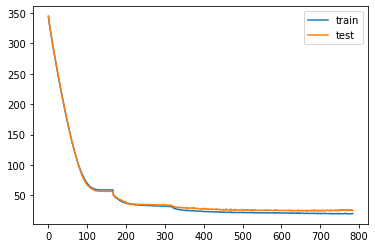


train_max_error: 123.24639892578125
test_max_error: 133.5689239501953
Train R2 = 0.86.
Test R2 = 0.69.

Epoch: 0, loss:122572.2188,  mae:342.9606,  mse:122572.2188,  val_loss:125462.5469,  val_mae:346.1451,  val_mse:125462.5469,  
....................................................................................................
Epoch: 100, loss:7229.1367,  mae:69.3236,  mse:7229.1099,  val_loss:8479.2168,  val_mae:73.3398,  val_mse:8479.1904,  
....................................................................................................
Epoch: 200, loss:2268.5322,  mae:37.2274,  mse:2268.4944,  val_loss:2770.3093,  val_mae:40.4195,  val_mse:2770.2712,  
....................................................................................................
Epoch: 300, loss:1029.9138,  mae:23.3200,  mse:1029.8652,  val_loss:2068.5005,  val_mae:30.7641,  val_mse:2068.4517,  
...................................................................

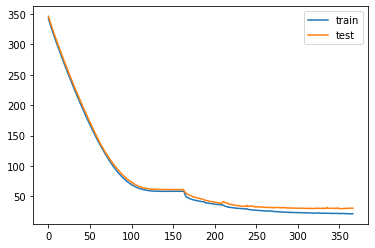


train_max_error: 142.53619384765625
test_max_error: 256.96409606933594
Train R2 = 0.83.
Test R2 = 0.54.

Epoch: 0, loss:123437.8750,  mae:343.9092,  mse:123437.8750,  val_loss:119617.4062,  val_mae:339.6898,  val_mse:119617.4062,  
....................................................................................................
Epoch: 100, loss:7489.1606,  mae:70.1141,  mse:7489.1323,  val_loss:6373.7119,  val_mae:66.2144,  val_mse:6373.6836,  
....................................................................................................
Epoch: 200, loss:2514.4104,  mae:39.2570,  mse:2514.3738,  val_loss:2538.1421,  val_mae:41.4803,  val_mse:2538.1055,  
..................................................................................................

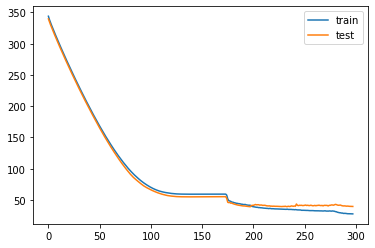


train_max_error: 183.11370849609375
test_max_error: 142.85760498046875
Train R2 = 0.75.
Test R2 = 0.35.

Epoch: 0, loss:123516.5625,  mae:344.2325,  mse:123516.5625,  val_loss:118700.7891,  val_mae:336.8902,  val_mse:118700.7891,  
....................................................................................................
Epoch: 100, loss:7375.7412,  mae:69.6893,  mse:7375.7139,  val_loss:7079.3008,  val_mae:68.9322,  val_mse:7079.2739,  
....................................................................................................
Epoch: 200, loss:2286.6836,  mae:36.7342,  mse:2286.6426,  val_loss:2354.3774,  val_mae:37.6617,  val_mse:2354.3372,  
....................................................................................................
Epoch: 300, loss:1445.6112,  mae:28.7216,  mse:1445.5693,  val_loss:1309.6794,  val_mae:27.3322,  val_mse:1309.6379,  
......................................................................................

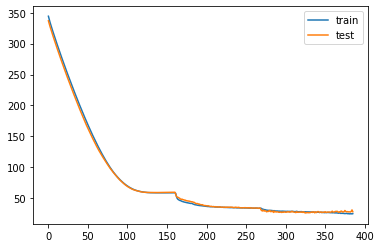


train_max_error: 157.81317138671875
test_max_error: 129.45765380859376
Train R2 = 0.79.
Test R2 = 0.72.

Epoch: 0, loss:123005.0703,  mae:343.3951,  mse:123005.0703,  val_loss:120515.6328,  val_mae:340.1593,  val_mse:120515.6328,  
....................................................................................................
Epoch: 100, loss:7350.0923,  mae:69.6908,  mse:7350.0649,  val_loss:6992.1611,  val_mae:67.2153,  val_mse:6992.1338,  
....................................................................................................
Epoch: 200, loss:2443.1653,  mae:38.6177,  mse:2443.1267,  val_loss:2213.6692,  val_mae:35.4362,  val_mse:2213.6304,  
....................................................................................................
Epoch: 300, loss:1903.9410,  mae:33.1073,  mse:1903.8978,  val_loss:1872.3268,  val_mae:32.8951,  val_mse:1872.2833,  
....................................................................................................
Epoch:

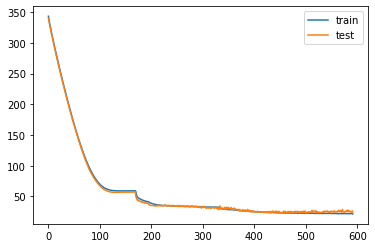


train_max_error: 144.5887451171875
test_max_error: 104.66316528320311
Train R2 = 0.82.
Test R2 = 0.78.

Epoch: 0, loss:124069.6172,  mae:345.0196,  mse:124069.6172,  val_loss:118876.6797,  val_mae:337.4005,  val_mse:118876.6797,  
....................................................................................................
Epoch: 100, loss:7441.2285,  mae:69.7916,  mse:7441.1992,  val_loss:6910.1284,  val_mae:69.6445,  val_mse:6910.0991,  
....................................................................................................
Epoch: 200, loss:2292.0217,  mae:37.0158,  mse:2291.9812,  val_loss:2305.9255,  val_mae:38.3358,  val_mse:2305.8850,  
....................................................................................................
Epoch: 300, loss:1833.0088,  mae:31.9761,  mse:1832.9680,  val_loss:1943.7584,  val_mae:33.8127,  val_mse:1943.7180,  
....................................................................................................
Epoch: 

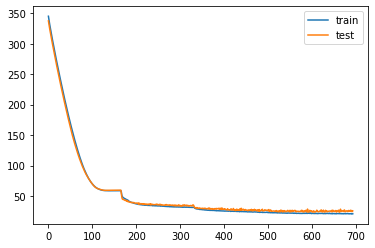


train_max_error: 131.62139892578125
test_max_error: 99.63302612304688
Train R2 = 0.84.
Test R2 = 0.78.

Epoch: 0, loss:122710.3750,  mae:343.0004,  mse:122710.3750,  val_loss:121402.3438,  val_mae:341.3819,  val_mse:121402.3438,  
....................................................................................................
Epoch: 100, loss:7366.9131,  mae:69.8140,  mse:7366.8872,  val_loss:7203.3081,  val_mae:68.1310,  val_mse:7203.2812,  
....................................................................................................
Epoch: 200, loss:2587.2217,  mae:40.5435,  mse:2587.1855,  val_loss:2541.7017,  val_mae:40.1631,  val_mse:2541.6650,  
....................................................................................................
Epoch: 300, loss:1882.2755,  mae:32.5301,  mse:1882.2339,  val_loss:1793.2202,  val_mae:34.9181,  val_mse:1793.1787,  
....................................................................................................
Epoch: 

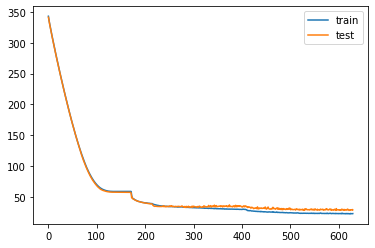


train_max_error: 130.558349609375
test_max_error: 112.32766113281252
Train R2 = 0.81.
Test R2 = 0.71.
Units 7

Epoch: 0, loss:123889.9062,  mae:344.9387,  mse:123889.9062,  val_loss:123224.5391,  val_mae:342.5104,  val_mse:123224.5391,  
....................................................................................................
Epoch: 100, loss:9422.6660,  mae:80.1907,  mse:9422.6426,  val_loss:10338.0225,  val_mae:84.0591,  val_mse:10337.9990,  
....................................................................................................
Epoch: 200, loss:2584.5234,  mae:40.5567,  mse:2584.4922,  val_loss:3152.0715,  val_mae:44.4243,  val_mse:3152.0408,  
....................................................................................................
Epoch: 300, loss:1806.7095,  mae:32.0332,  mse:1806.6711,  val_loss:2238.9692,  val_mae:36.3991,  val_mse:2238.9312,  
...................................................................................................

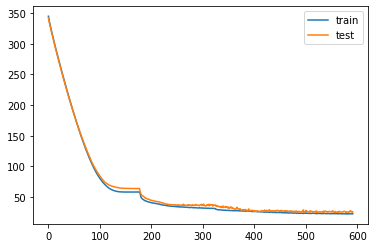


train_max_error: 148.11492919921875
test_max_error: 80.55682373046875
Train R2 = 0.81.
Test R2 = 0.82.

Epoch: 0, loss:122743.8906,  mae:343.0070,  mse:122743.8906,  val_loss:122200.3984,  val_mae:343.0974,  val_mse:122200.3984,  
....................................................................................................
Epoch: 100, loss:9537.8945,  mae:80.8424,  mse:9537.8721,  val_loss:9189.9717,  val_mae:77.9337,  val_mse:9189.9473,  
....................................................................................................
Epoch: 200, loss:2525.1812,  mae:40.7388,  mse:2525.1489,  val_loss:2837.4592,  val_mae:42.5971,  val_mse:2837.4272,  
....................................................................................................
Epoch: 300, loss:1861.4614,  mae:32.9898,  mse:1861.4269,  val_loss:2177.0332,  val_mae:34.4485,  val_mse:2176.9988,  
....................................................................................................
Epoch: 

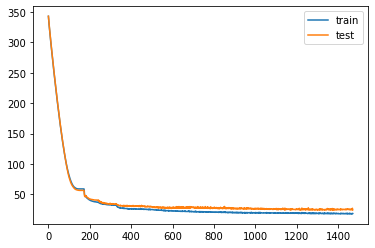


train_max_error: 94.6112060546875
test_max_error: 111.57839965820312
Train R2 = 0.88.
Test R2 = 0.73.

Epoch: 0, loss:122436.0000,  mae:342.7647,  mse:122436.0000,  val_loss:125475.3125,  val_mae:346.1594,  val_mse:125475.3125,  
....................................................................................................
Epoch: 100, loss:9330.3750,  mae:80.0432,  mse:9330.3525,  val_loss:10765.0215,  val_mae:84.2793,  val_mse:10764.9980,  
....................................................................................................
Epoch: 200, loss:2542.0906,  mae:40.6963,  mse:2542.0593,  val_loss:3175.7048,  val_mae:45.6766,  val_mse:3175.6733,  
....................................................................................................
Epoch: 300, loss:1364.3325,  mae:28.7704,  mse:1364.2959,  val_loss:1956.6218,  val_mae:32.7573,  val_mse:1956.5852,  
....................................................................................................
Epoch:

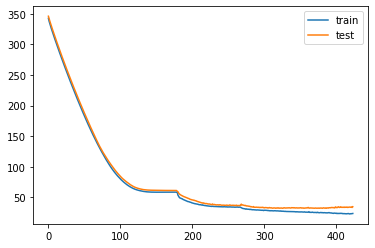


train_max_error: 158.15213012695312
test_max_error: 208.72882080078125
Train R2 = 0.81.
Test R2 = 0.56.

Epoch: 0, loss:123334.5078,  mae:343.7525,  mse:123334.5078,  val_loss:119525.1484,  val_mae:339.5483,  val_mse:119525.1484,  
....................................................................................................
Epoch: 100, loss:9569.6943,  mae:80.6976,  mse:9569.6719,  val_loss:8367.6240,  val_mae:75.9082,  val_mse:8367.6016,  
....................................................................................................
Epoch: 200, loss:2916.4749,  mae:43.8145,  mse:2916.4456,  val_loss:2623.3340,  val_mae:41.2230,  val_mse:2623.3049,  
....................................................................................................
Epoch: 300, loss:1489.8088,  mae:29.9906,  mse:1489.7715,  val_loss:2573.9773,  val_mae:38.4925,  val_mse:2573.9402,  
........................

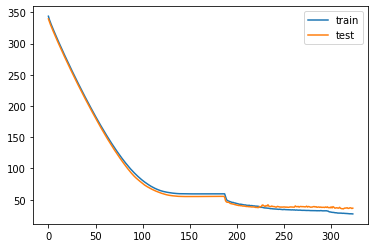


train_max_error: 178.73416137695312
test_max_error: 143.72286987304688
Train R2 = 0.76.
Test R2 = 0.44.

Epoch: 0, loss:123684.4922,  mae:344.5161,  mse:123684.4922,  val_loss:118862.6875,  val_mae:337.1339,  val_mse:118862.6875,  
....................................................................................................
Epoch: 100, loss:9491.1523,  mae:80.2032,  mse:9491.1289,  val_loss:8986.5078,  val_mae:79.6513,  val_mse:8986.4834,  
....................................................................................................
Epoch: 200, loss:2550.6147,  mae:39.8798,  mse:2550.5837,  val_loss:2828.8083,  val_mae:43.3306,  val_mse:2828.7771,  
....................................................................................................
Epoch: 300, loss:1812.2026,  mae:32.2886,  mse:1812.1683,  val_loss:2005.0647,  val_mae:34.1809,  val_mse:2005.0304,  
....................................................................................................
Epoch:

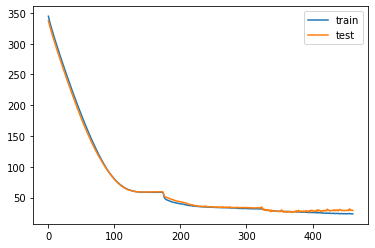


train_max_error: 141.3289794921875
test_max_error: 128.94175415039064
Train R2 = 0.80.
Test R2 = 0.70.

Epoch: 0, loss:123441.3906,  mae:344.0430,  mse:123441.3906,  val_loss:121100.2969,  val_mae:341.0224,  val_mse:121100.2969,  
....................................................................................................
Epoch: 100, loss:9550.6201,  mae:80.8145,  mse:9550.5957,  val_loss:9145.7129,  val_mae:78.2424,  val_mse:9145.6875,  
....................................................................................................
Epoch: 200, loss:2638.4072,  mae:41.6395,  mse:2638.3750,  val_loss:2370.2000,  val_mae:38.1458,  val_mse:2370.1675,  
....................................................................................................
Epoch: 300, loss:1891.2686,  mae:33.0351,  mse:1891.2321,  val_loss:1978.9202,  val_mae:34.6464,  val_mse:1978.8834,  
....................................................................................................
Epoch: 

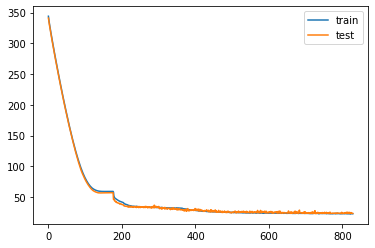


train_max_error: 130.52667236328125
test_max_error: 89.73546142578124
Train R2 = 0.82.
Test R2 = 0.80.

Epoch: 0, loss:123857.6797,  mae:344.7224,  mse:123857.6797,  val_loss:118589.7969,  val_mae:336.9716,  val_mse:118589.7969,  
....................................................................................................
Epoch: 100, loss:9600.6074,  mae:80.6130,  mse:9600.5850,  val_loss:8850.7666,  val_mae:80.0626,  val_mse:8850.7412,  
....................................................................................................
Epoch: 200, loss:2685.7822,  mae:41.6050,  mse:2685.7517,  val_loss:2273.5234,  val_mae:40.5867,  val_mse:2273.4932,  
....................................................................................................
Epoch: 300, loss:1857.1079,  mae:32.3746,  mse:1857.0725,  val_loss:1953.7758,  val_mae:34.4437,  val_mse:1953.7400,  
....................................................................................................
Epoch: 

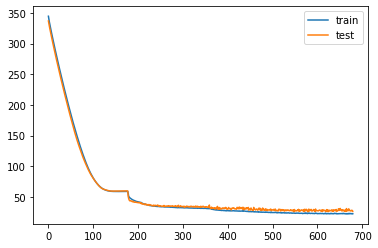


train_max_error: 127.02212524414062
test_max_error: 96.4295654296875
Train R2 = 0.81.
Test R2 = 0.78.

Epoch: 0, loss:122563.9375,  mae:342.7802,  mse:122563.9375,  val_loss:121299.5000,  val_mae:341.2345,  val_mse:121299.5000,  
....................................................................................................
Epoch: 100, loss:9475.2119,  mae:80.5046,  mse:9475.1885,  val_loss:9313.1924,  val_mae:78.7670,  val_mse:9313.1699,  
....................................................................................................
Epoch: 200, loss:2666.5090,  mae:41.8212,  mse:2666.4788,  val_loss:2593.6809,  val_mae:41.4151,  val_mse:2593.6509,  
....................................................................................................
Epoch: 300, loss:1896.7743,  mae:33.0159,  mse:1896.7408,  val_loss:1725.2792,  val_mae:34.1324,  val_mse:1725.2461,  
....................................................................................................
Epoch: 4

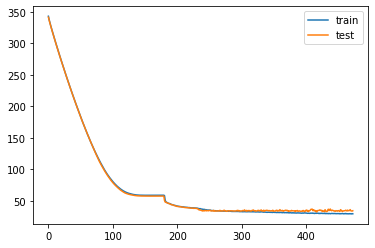


train_max_error: 173.37261962890625
test_max_error: 107.60275268554688
Train R2 = 0.69.
Test R2 = 0.65.
Units 6

Epoch: 0, loss:122848.4922,  mae:343.4022,  mse:122848.4922,  val_loss:122438.0859,  val_mae:341.3613,  val_mse:122438.0938,  
....................................................................................................
Epoch: 100, loss:13053.3984,  mae:96.8929,  mse:13053.3818,  val_loss:13934.8223,  val_mae:99.8771,  val_mse:13934.7998,  
....................................................................................................
Epoch: 200, loss:3742.2544,  mae:49.4977,  mse:3742.2317,  val_loss:4369.2573,  val_mae:53.6453,  val_mse:4369.2334,  
....................................................................................................
Epoch: 300, loss:1842.5332,  mae:32.6930,  mse:1842.5077,  val_loss:2174.5398,  val_mae:36.2898,  val_mse:2174.5142,  
...............................................................................................

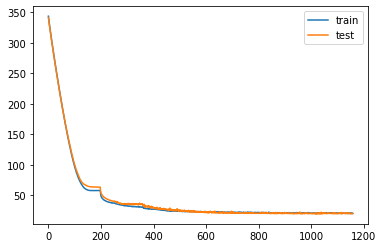


train_max_error: 115.31192016601562
test_max_error: 58.615121694712
Train R2 = 0.84.
Test R2 = 0.89.

Epoch: 0, loss:124112.8906,  mae:344.9491,  mse:124112.8906,  val_loss:124093.9609,  val_mae:345.8481,  val_mse:124093.9609,  
....................................................................................................
Epoch: 100, loss:13417.3135,  mae:98.3848,  mse:13417.2949,  val_loss:13168.2090,  val_mae:97.3249,  val_mse:13168.1865,  
....................................................................................................
Epoch: 200, loss:2993.8367,  mae:44.9030,  mse:2993.8118,  val_loss:3377.5481,  val_mae:47.8395,  val_mse:3377.5229,  
....................................................................................................
Epoch: 300, loss:1870.2383,  mae:33.1842,  mse:1870.2123,  val_loss:2275.6904,  val_mae:36.3397,  val_mse:2275.6646,  
....................................................................................................
Epoch

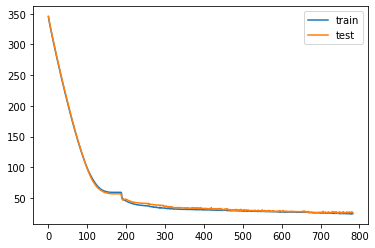


train_max_error: 178.19717407226562
test_max_error: 157.16842651367188
Train R2 = 0.78.
Test R2 = 0.66.

Epoch: 0, loss:122979.1562,  mae:343.5299,  mse:122979.1562,  val_loss:126221.8125,  val_mae:347.2433,  val_mse:126221.8125,  
....................................................................................................
Epoch: 100, loss:13021.3076,  mae:96.9735,  mse:13021.2881,  val_loss:14685.3311,  val_mae:101.5974,  val_mse:14685.3115,  
....................................................................................................
Epoch: 200, loss:2963.1411,  mae:44.5541,  mse:2963.1172,  val_loss:3731.9746,  val_mae:50.1228,  val_mse:3731.9504,  
....................................................................................................
Epoch: 300, loss:1835.0353,  mae:32.9494,  mse:1835.0061,  val_loss:2365.2859,  val_mae:37.1532,  val_mse:2365.2571,  
....................................................................................................
E

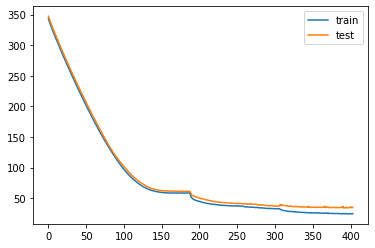


train_max_error: 178.8915557861328
test_max_error: 240.22368621826172
Train R2 = 0.79.
Test R2 = 0.50.

Epoch: 0, loss:123924.9062,  mae:344.6300,  mse:123924.9062,  val_loss:120731.6484,  val_mae:341.3306,  val_mse:120731.6484,  
....................................................................................................
Epoch: 100, loss:13512.2119,  mae:98.7330,  mse:13512.1895,  val_loss:12196.2881,  val_mae:93.5782,  val_mse:12196.2646,  
....................................................................................................
Epoch: 200, loss:5144.9937,  mae:59.3624,  mse:5144.9727,  val_loss:4224.4321,  val_mae:55.3084,  val_mse:4224.4106,  
....................................................................................................
Epoch: 300, loss:1741.0258,  mae:32.0263,  mse:1740.9958,  val_loss:2377.5125,  val_mae:37.8082,  val_mse:2377.4829,  
....................................................................................................
Epo

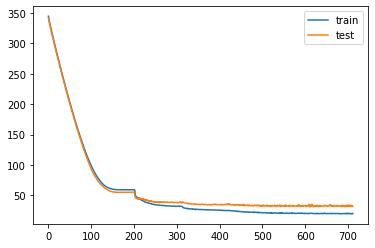


train_max_error: 129.76544189453125
test_max_error: 111.22039794921875
Train R2 = 0.85.
Test R2 = 0.54.

Epoch: 0, loss:122894.6875,  mae:343.3650,  mse:122894.6875,  val_loss:118301.8984,  val_mae:336.2986,  val_mse:118301.8984,  
....................................................................................................
Epoch: 100, loss:13152.2285,  mae:96.9230,  mse:13152.2109,  val_loss:12389.2275,  val_mae:96.0152,  val_mse:12389.2080,  
....................................................................................................
Epoch: 200, loss:3287.8157,  mae:45.9770,  mse:3287.7908,  val_loss:3403.4453,  val_mae:50.2296,  val_mse:3403.4204,  
....................................................................................................
Epoch: 300, loss:1869.6543,  mae:33.0030,  mse:1869.6267,  val_loss:1930.0247,  val_mae:33.4060,  val_mse:1929.9976,  
....................................................................................................
Ep

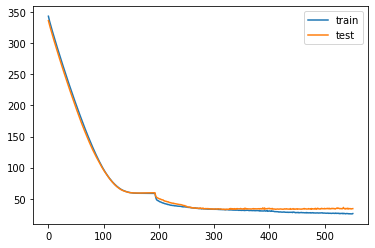


train_max_error: 144.77996826171875
test_max_error: 132.559814453125
Train R2 = 0.76.
Test R2 = 0.63.

Epoch: 0, loss:123320.6406,  mae:343.8695,  mse:123320.6406,  val_loss:121068.1953,  val_mae:340.9696,  val_mse:121068.1953,  
....................................................................................................
Epoch: 100, loss:13137.3945,  mae:97.2704,  mse:13137.3770,  val_loss:12679.8115,  val_mae:94.2579,  val_mse:12679.7891,  
....................................................................................................
Epoch: 200, loss:3838.4116,  mae:50.3405,  mse:3838.3896,  val_loss:3313.3816,  val_mae:45.1431,  val_mse:3313.3596,  
....................................................................................................
Epoch: 300, loss:1884.7896,  mae:33.4086,  mse:1884.7571,  val_loss:1842.2528,  val_mae:33.1228,  val_mse:1842.2202,  
....................................................................................................
Epoc

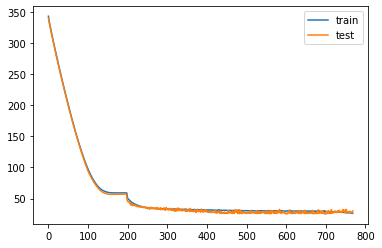


train_max_error: 150.9210205078125
test_max_error: 106.26689453124999
Train R2 = 0.75.
Test R2 = 0.70.

Epoch: 0, loss:123813.5703,  mae:344.6632,  mse:123813.5703,  val_loss:118725.5000,  val_mae:337.1756,  val_mse:118725.5000,  
....................................................................................................
Epoch: 100, loss:13277.7510,  mae:97.5154,  mse:13277.7305,  val_loss:12247.4102,  val_mae:95.2471,  val_mse:12247.3887,  
....................................................................................................
Epoch: 200, loss:3391.9517,  mae:47.4200,  mse:3391.9272,  val_loss:2634.6946,  val_mae:43.2359,  val_mse:2634.6697,  
....................................................................................................
Epoch: 300, loss:1899.3108,  mae:33.1691,  mse:1899.2837,  val_loss:1817.4363,  val_mae:33.4267,  val_mse:1817.4097,  
....................................................................................................
Epo

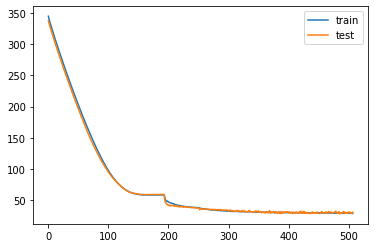


train_max_error: 165.42535400390625
test_max_error: 126.73284912109375
Train R2 = 0.69.
Test R2 = 0.67.

Epoch: 0, loss:122744.9062,  mae:343.0526,  mse:122744.9062,  val_loss:121593.2578,  val_mae:341.6593,  val_mse:121593.2578,  
....................................................................................................
Epoch: 100, loss:13059.8486,  mae:96.9267,  mse:13059.8271,  val_loss:12903.5332,  val_mae:95.5742,  val_mse:12903.5127,  
....................................................................................................
Epoch: 200, loss:3481.6716,  mae:47.4899,  mse:3481.6484,  val_loss:3338.9485,  val_mae:47.2013,  val_mse:3338.9260,  
....................................................................................................
Epoch: 300, loss:1968.7400,  mae:34.1731,  mse:1968.7146,  val_loss:1718.0182,  val_mae:32.9255,  val_mse:1717.9924,  
....................................................................................................
Ep

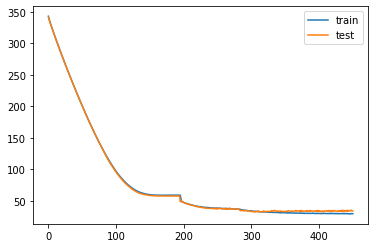


train_max_error: 174.97698974609375
test_max_error: 106.4249267578125
Train R2 = 0.69.
Test R2 = 0.66.
Units 5

Epoch: 0, loss:123485.5625,  mae:344.3481,  mse:123485.5625,  val_loss:123157.0469,  val_mae:342.4151,  val_mse:123157.0469,  
....................................................................................................
Epoch: 100, loss:18708.0273,  mae:120.1571,  mse:18708.0117,  val_loss:19563.5156,  val_mae:122.9955,  val_mse:19563.4961,  
....................................................................................................
Epoch: 200, loss:4912.6929,  mae:58.0327,  mse:4912.6709,  val_loss:5924.9810,  val_mae:63.7746,  val_mse:5924.9600,  
....................................................................................................
Epoch: 300, loss:1909.2290,  mae:34.1544,  mse:1909.2085,  val_loss:2237.3030,  val_mae:37.3664,  val_mse:2237.2827,  
..............................................................................................

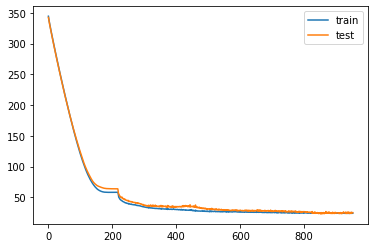


train_max_error: 153.21917724609375
test_max_error: 99.16387939453125
Train R2 = 0.77.
Test R2 = 0.84.

Epoch: 0, loss:124074.0938,  mae:344.9153,  mse:124074.0938,  val_loss:124113.6328,  val_mae:345.8773,  val_mse:124113.6328,  
....................................................................................................
Epoch: 100, loss:19020.8789,  mae:121.0848,  mse:19020.8613,  val_loss:18887.0117,  val_mae:122.0735,  val_mse:18886.9961,  
....................................................................................................
Epoch: 200, loss:5119.2427,  mae:59.0615,  mse:5119.2212,  val_loss:4517.0771,  val_mae:56.6846,  val_mse:4517.0576,  
....................................................................................................
Epoch: 300, loss:1847.7227,  mae:33.3534,  mse:1847.7014,  val_loss:2150.6538,  val_mae:35.2168,  val_mse:2150.6318,  
....................................................................................................
E

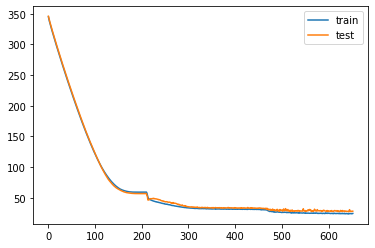


train_max_error: 140.8507080078125
test_max_error: 160.4420166015625
Train R2 = 0.81.
Test R2 = 0.63.

Epoch: 0, loss:123363.4453,  mae:344.1277,  mse:123363.4453,  val_loss:126770.6328,  val_mae:348.0312,  val_mse:126770.6328,  
....................................................................................................
Epoch: 100, loss:18589.0293,  mae:120.1930,  mse:18589.0156,  val_loss:20542.7070,  val_mae:123.4172,  val_mse:20542.6895,  
....................................................................................................
Epoch: 200, loss:4946.2510,  mae:58.3974,  mse:4946.2324,  val_loss:5733.6372,  val_mae:61.2265,  val_mse:5733.6187,  
....................................................................................................
Epoch: 300, loss:1817.2180,  mae:33.2157,  mse:1817.1964,  val_loss:2183.5737,  val_mae:35.8229,  val_mse:2183.5525,  
....................................................................................................
Ep

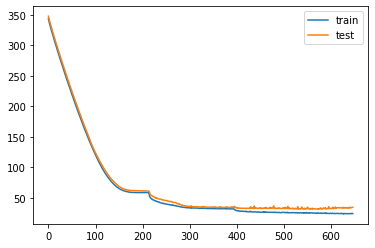


train_max_error: 158.2093048095703
test_max_error: 218.1924591064453
Train R2 = 0.81.
Test R2 = 0.57.

Epoch: 0, loss:123036.3125,  mae:343.3547,  mse:123036.3125,  val_loss:119574.3750,  val_mae:339.6341,  val_mse:119574.3750,  
....................................................................................................
Epoch: 100, loss:18748.4551,  mae:120.0698,  mse:18748.4375,  val_loss:17338.2656,  val_mae:116.1794,  val_mse:17338.2480,  
....................................................................................................
Epoch: 200, loss:5155.3838,  mae:59.2935,  mse:5155.3633,  val_loss:4228.2642,  val_mae:55.1026,  val_mse:4228.2441,  
....................................................................................................
Epoch: 300, loss:1746.5183,  mae:32.7253,  mse:1746.4961,  val_loss:2383.0491,  val_mae:38.2102,  val_mse:2383.0266,  
....................................................................................................
Ep

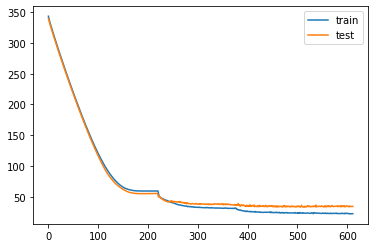


train_max_error: 137.76705932617188
test_max_error: 132.51266479492188
Train R2 = 0.83.
Test R2 = 0.48.

Epoch: 0, loss:124085.2969,  mae:345.0901,  mse:124085.2969,  val_loss:119860.5078,  val_mae:338.6099,  val_mse:119860.5078,  
....................................................................................................
Epoch: 100, loss:19071.1465,  mae:121.3093,  mse:19071.1289,  val_loss:17997.2598,  val_mae:118.5360,  val_mse:17997.2422,  
....................................................................................................
Epoch: 200, loss:5014.0493,  mae:58.6970,  mse:5014.0278,  val_loss:5205.2915,  val_mae:59.3348,  val_mse:5205.2695,  
....................................................................................................
Epoch: 300, loss:1879.9094,  mae:33.6405,  mse:1879.8879,  val_loss:1912.0500,  val_mae:34.2888,  val_mse:1912.0284,  
....................................................................................................


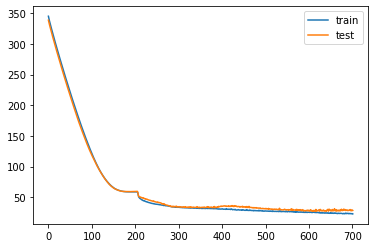


train_max_error: 155.25213623046875
test_max_error: 120.78599243164064
Train R2 = 0.80.
Test R2 = 0.70.

Epoch: 0, loss:123813.4922,  mae:344.5806,  mse:123813.4922,  val_loss:121742.1484,  val_mae:341.9585,  val_mse:121742.1484,  
....................................................................................................
Epoch: 100, loss:18848.9141,  mae:120.6231,  mse:18848.8965,  val_loss:18333.8184,  val_mae:118.7817,  val_mse:18333.8008,  
....................................................................................................
Epoch: 200, loss:5072.6812,  mae:59.0255,  mse:5072.6616,  val_loss:4810.7095,  val_mae:56.8865,  val_mse:4810.6895,  
....................................................................................................
Epoch: 300, loss:1914.5767,  mae:34.1267,  mse:1914.5563,  val_loss:1824.0070,  val_mae:32.4106,  val_mse:1823.9865,  
....................................................................................................


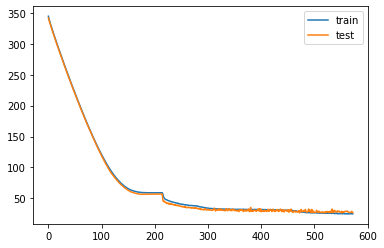


train_max_error: 155.6163330078125
test_max_error: 105.05214233398436
Train R2 = 0.77.
Test R2 = 0.75.

Epoch: 0, loss:124492.5000,  mae:345.6335,  mse:124492.5000,  val_loss:119688.3906,  val_mae:338.5961,  val_mse:119688.3906,  
....................................................................................................
Epoch: 100, loss:19082.2148,  mae:121.4375,  mse:19082.1992,  val_loss:17725.0176,  val_mae:116.8862,  val_mse:17725.0000,  
....................................................................................................
Epoch: 200, loss:5037.8628,  mae:58.6636,  mse:5037.8418,  val_loss:5037.3501,  val_mae:59.4949,  val_mse:5037.3301,  
....................................................................................................
Epoch: 300, loss:1976.4783,  mae:34.5598,  mse:1976.4573,  val_loss:1722.3654,  val_mae:33.8457,  val_mse:1722.3439,  
....................................................................................................
E

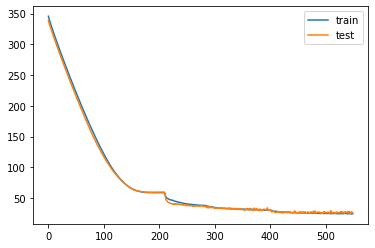


train_max_error: 145.4476318359375
test_max_error: 113.62692260742188
Train R2 = 0.79.
Test R2 = 0.78.

Epoch: 0, loss:122997.2812,  mae:343.4261,  mse:122997.2812,  val_loss:122219.0234,  val_mae:342.5775,  val_mse:122219.0234,  
....................................................................................................
Epoch: 100, loss:18802.9922,  mae:120.5032,  mse:18802.9766,  val_loss:18662.5176,  val_mae:119.4914,  val_mse:18662.5000,  
....................................................................................................
Epoch: 200, loss:5065.3965,  mae:58.9225,  mse:5065.3789,  val_loss:4874.1499,  val_mae:57.6477,  val_mse:4874.1304,  
....................................................................................................
Epoch: 300, loss:1492.9923,  mae:28.5006,  mse:1492.9705,  val_loss:1726.9159,  val_mae:31.9241,  val_mse:1726.8940,  
....................................................................................................
E

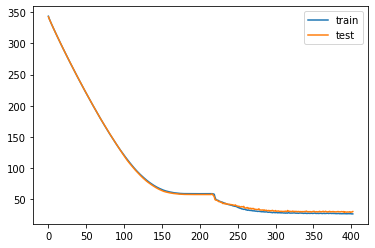


train_max_error: 180.67947387695312
test_max_error: 123.84271240234375
Train R2 = 0.72.
Test R2 = 0.64.
Units 4

Epoch: 0, loss:123416.8047,  mae:344.2330,  mse:123416.8047,  val_loss:123151.6484,  val_mae:342.4037,  val_mse:123151.6484,  
....................................................................................................
Epoch: 100, loss:26837.3965,  mae:148.7612,  mse:26837.3848,  val_loss:27664.9980,  val_mae:150.4994,  val_mse:27664.9844,  
....................................................................................................
Epoch: 200, loss:5182.4609,  mae:58.5512,  mse:5182.4443,  val_loss:6189.5273,  val_mae:64.8918,  val_mse:6189.5093,  
....................................................................................................
Epoch: 300, loss:2315.0381,  mae:38.0814,  mse:2315.0227,  val_loss:2968.4688,  val_mae:43.6820,  val_mse:2968.4536,  
.............................................................................................

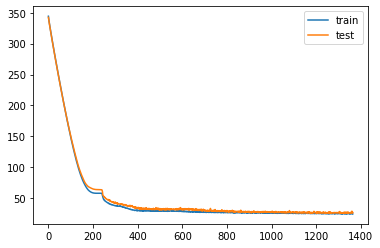


train_max_error: 156.51260375976562
test_max_error: 89.88037109375
Train R2 = 0.75.
Test R2 = 0.81.

Epoch: 0, loss:123020.8906,  mae:343.3865,  mse:123020.8906,  val_loss:123042.3203,  val_mae:344.3222,  val_mse:123042.3203,  
....................................................................................................
Epoch: 100, loss:26860.3770,  mae:148.5406,  mse:26860.3574,  val_loss:26871.1543,  val_mae:149.9650,  val_mse:26871.1426,  
....................................................................................................
Epoch: 200, loss:5382.6562,  mae:59.6367,  mse:5382.6406,  val_loss:4846.3950,  val_mae:57.6277,  val_mse:4846.3774,  
....................................................................................................
Epoch: 300, loss:2339.0413,  mae:39.4795,  mse:2339.0271,  val_loss:3067.3889,  val_mae:44.7654,  val_mse:3067.3743,  
....................................................................................................
Epoc

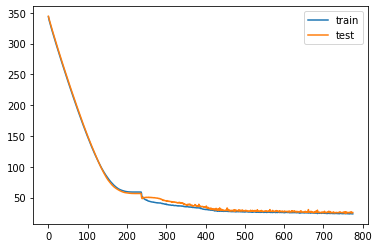


train_max_error: 134.84600830078125
test_max_error: 151.5696258544922
Train R2 = 0.81.
Test R2 = 0.67.

Epoch: 0, loss:123645.6484,  mae:344.5506,  mse:123645.6484,  val_loss:127579.8516,  val_mae:349.1942,  val_mse:127579.8516,  
....................................................................................................
Epoch: 100, loss:27082.5352,  mae:149.8449,  mse:27082.5215,  val_loss:29399.1992,  val_mae:154.1255,  val_mse:29399.1836,  
....................................................................................................
Epoch: 200, loss:5225.2437,  mae:59.1265,  mse:5225.2261,  val_loss:6163.3218,  val_mae:62.1142,  val_mse:6163.3047,  
....................................................................................................
Epoch: 300, loss:1551.6989,  mae:29.7879,  mse:1551.6801,  val_loss:2299.4839,  val_mae:33.9705,  val_mse:2299.4651,  
....................................................................................................
E

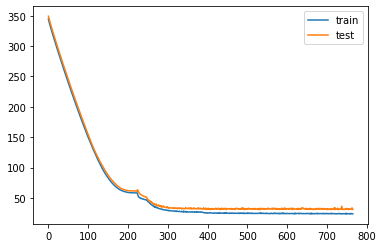


train_max_error: 125.98800659179688
test_max_error: 169.67092895507812
Train R2 = 0.78.
Test R2 = 0.65.

Epoch: 0, loss:124017.0312,  mae:344.7637,  mse:124017.0312,  val_loss:120857.2109,  val_mae:341.5108,  val_mse:120857.2109,  
....................................................................................................
Epoch: 100, loss:27136.1250,  mae:149.3346,  mse:27136.1113,  val_loss:25603.5703,  val_mae:146.4228,  val_mse:25603.5547,  
....................................................................................................
Epoch: 200, loss:5430.2700,  mae:59.8880,  mse:5430.2529,  val_loss:4458.9614,  val_mae:55.6042,  val_mse:4458.9438,  
....................................................................................................
Epoch: 300, loss:1596.7637,  mae:30.3493,  mse:1596.7450,  val_loss:2401.5249,  val_mae:36.1841,  val_mse:2401.5061,  
....................................................................................................


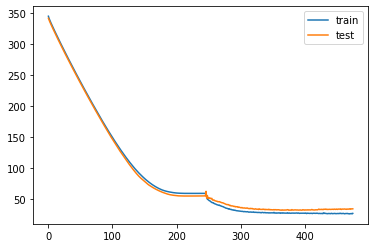


train_max_error: 176.69122314453125
test_max_error: 137.6783447265625
Train R2 = 0.75.
Test R2 = 0.45.

Epoch: 0, loss:124369.9297,  mae:345.4782,  mse:124369.9297,  val_loss:120033.2109,  val_mae:338.8617,  val_mse:120033.2109,  
....................................................................................................
Epoch: 100, loss:27188.2812,  mae:149.8058,  mse:27188.2676,  val_loss:25810.4844,  val_mae:145.2795,  val_mse:25810.4668,  
....................................................................................................
Epoch: 200, loss:5294.2344,  mae:59.3005,  mse:5294.2163,  val_loss:5353.2710,  val_mae:59.3755,  val_mse:5353.2534,  
....................................................................................................
Epoch: 300, loss:2283.5173,  mae:37.2913,  mse:2283.5020,  val_loss:2317.9041,  val_mae:40.6241,  val_mse:2317.8889,  
....................................................................................................
E

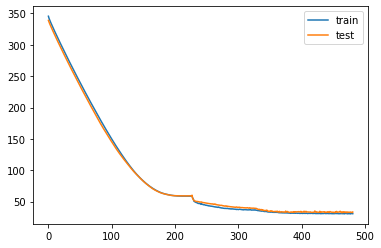


train_max_error: 163.73837280273438
test_max_error: 116.18037109375001
Train R2 = 0.68.
Test R2 = 0.65.

Epoch: 0, loss:124179.8516,  mae:345.1364,  mse:124179.8516,  val_loss:122609.0547,  val_mae:343.2324,  val_mse:122609.0547,  
....................................................................................................
Epoch: 100, loss:27363.0840,  mae:150.2414,  mse:27363.0684,  val_loss:26802.5254,  val_mae:149.2805,  val_mse:26802.5117,  
....................................................................................................
Epoch: 200, loss:5359.8467,  mae:59.7855,  mse:5359.8276,  val_loss:5083.1260,  val_mae:56.8528,  val_mse:5083.1089,  
....................................................................................................
Epoch: 300, loss:2029.0980,  mae:35.8631,  mse:2029.0814,  val_loss:1827.9874,  val_mae:32.9178,  val_mse:1827.9705,  
....................................................................................................


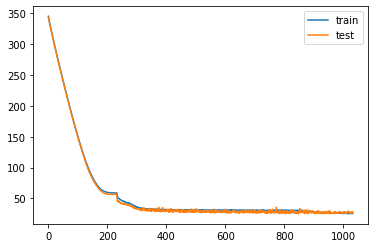


train_max_error: 157.34124755859375
test_max_error: 121.32355550130177
Train R2 = 0.75.
Test R2 = 0.73.

Epoch: 0, loss:124825.6719,  mae:346.1306,  mse:124825.6953,  val_loss:120497.1719,  val_mae:339.7976,  val_mse:120497.1719,  
....................................................................................................
Epoch: 100, loss:27705.2285,  mae:151.5409,  mse:27705.2109,  val_loss:26001.4297,  val_mae:145.3005,  val_mse:26001.4141,  
....................................................................................................
Epoch: 200, loss:5345.2031,  mae:59.3684,  mse:5345.1851,  val_loss:5192.3574,  val_mae:59.7974,  val_mse:5192.3394,  
....................................................................................................
Epoch: 300, loss:2105.6882,  mae:36.7484,  mse:2105.6738,  val_loss:1660.1494,  val_mae:33.2574,  val_mse:1660.1346,  
....................................................................................................


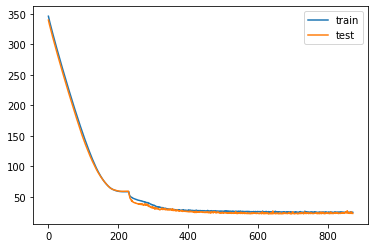


train_max_error: 156.30047607421875
test_max_error: 110.54156494140625
Train R2 = 0.76.
Test R2 = 0.80.

Epoch: 0, loss:123966.5859,  mae:344.8241,  mse:123966.5859,  val_loss:123206.1875,  val_mae:344.0169,  val_mse:123206.1875,  
....................................................................................................
Epoch: 100, loss:27088.2891,  mae:149.3647,  mse:27088.2754,  val_loss:26985.2383,  val_mae:149.7396,  val_mse:26985.2266,  
....................................................................................................
Epoch: 200, loss:5340.1050,  mae:59.5384,  mse:5340.0879,  val_loss:5170.6035,  val_mae:58.3496,  val_mse:5170.5869,  
....................................................................................................
Epoch: 300, loss:2352.2910,  mae:39.1199,  mse:2352.2764,  val_loss:2326.3154,  val_mae:38.7478,  val_mse:2326.3010,  
....................................................................................................


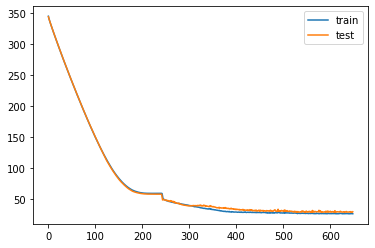


train_max_error: 171.1236572265625
test_max_error: 134.60218811035156
Train R2 = 0.74.
Test R2 = 0.68.
Units 3

Epoch: 0, loss:124020.3281,  mae:345.1489,  mse:124020.3281,  val_loss:124240.8047,  val_mae:343.9934,  val_mse:124240.8047,  
....................................................................................................
Epoch: 100, loss:38545.1211,  mae:183.4274,  mse:38545.1016,  val_loss:39379.5078,  val_mae:183.8684,  val_mse:39379.4961,  
....................................................................................................
Epoch: 200, loss:7630.9111,  mae:71.2622,  mse:7630.8965,  val_loss:8613.5713,  val_mae:75.2757,  val_mse:8613.5576,  
....................................................................................................
Epoch: 300, loss:2871.6428,  mae:43.3968,  mse:2871.6328,  val_loss:3678.1497,  val_mae:49.9348,  val_mse:3678.1394,  
..............................................................................................

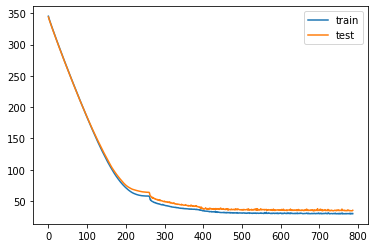


train_max_error: 165.20001220703125
test_max_error: 127.52166748046875
Train R2 = 0.69.
Test R2 = 0.67.

Epoch: 0, loss:123850.4922,  mae:344.5799,  mse:123850.4922,  val_loss:124296.6953,  val_mae:346.1424,  val_mse:124296.6953,  
....................................................................................................
Epoch: 100, loss:38549.2773,  mae:183.0103,  mse:38549.2695,  val_loss:38759.8711,  val_mae:185.1583,  val_mse:38759.8594,  
....................................................................................................
Epoch: 200, loss:7806.9390,  mae:72.1245,  mse:7806.9229,  val_loss:7439.1978,  val_mae:69.4731,  val_mse:7439.1836,  
....................................................................................................
Epoch: 300, loss:3000.8882,  mae:44.7779,  mse:3000.8762,  val_loss:3702.1746,  val_mae:49.9261,  val_mse:3702.1624,  
....................................................................................................


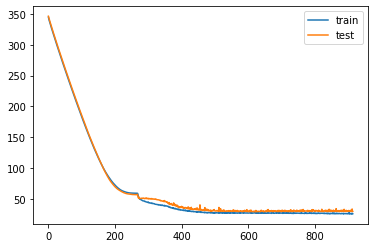


train_max_error: 155.57232666015625
test_max_error: 161.8983612060547
Train R2 = 0.78.
Test R2 = 0.63.

Epoch: 0, loss:123851.2656,  mae:344.8369,  mse:123851.2656,  val_loss:127956.8203,  val_mae:349.7313,  val_mse:127956.8203,  
....................................................................................................
Epoch: 100, loss:38573.0977,  mae:183.5295,  mse:38573.0898,  val_loss:41296.6367,  val_mae:188.8176,  val_mse:41296.6211,  
....................................................................................................
Epoch: 200, loss:7675.7075,  mae:71.6731,  mse:7675.6943,  val_loss:9006.9307,  val_mae:75.9750,  val_mse:9006.9180,  
....................................................................................................
Epoch: 300, loss:2378.4631,  mae:39.6333,  mse:2378.4521,  val_loss:4035.1865,  val_mae:46.6740,  val_mse:4035.1755,  
....................................................................................................
E

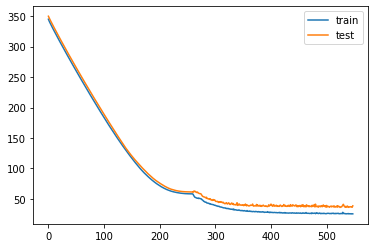


train_max_error: 155.69769287109375
test_max_error: 261.467041015625
Train R2 = 0.76.
Test R2 = 0.40.

Epoch: 0, loss:124576.7266,  mae:345.5664,  mse:124576.7266,  val_loss:121789.3672,  val_mae:342.8677,  val_mse:121789.3672,  
....................................................................................................
Epoch: 100, loss:38821.3555,  mae:183.6275,  mse:38821.3398,  val_loss:37188.6914,  val_mae:181.5612,  val_mse:37188.6836,  
....................................................................................................
Epoch: 200, loss:7889.1621,  mae:72.2485,  mse:7889.1479,  val_loss:6790.7222,  val_mae:68.2699,  val_mse:6790.7085,  
....................................................................................................
Epoch: 300, loss:3008.1462,  mae:45.1450,  mse:3008.1348,  val_loss:3206.6777,  val_mae:45.8411,  val_mse:3206.6665,  
....................................................................................................
Ep

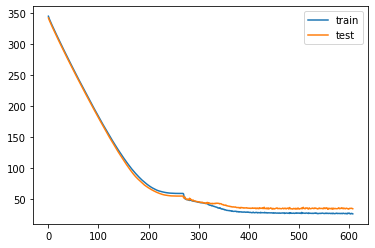


train_max_error: 168.26535034179688
test_max_error: 170.03305053710938
Train R2 = 0.75.
Test R2 = 0.42.

Epoch: 0, loss:124918.0391,  mae:346.2809,  mse:124918.0391,  val_loss:120952.6094,  val_mae:340.2155,  val_mse:120952.6094,  
....................................................................................................
Epoch: 100, loss:38834.7227,  mae:184.0568,  mse:38834.7109,  val_loss:37112.4258,  val_mae:178.6293,  val_mse:37112.4141,  
....................................................................................................
Epoch: 200, loss:7779.3501,  mae:71.7592,  mse:7779.3379,  val_loss:7471.7612,  val_mae:71.1988,  val_mse:7471.7476,  
....................................................................................................
Epoch: 300, loss:2887.6443,  mae:43.2361,  mse:2887.6331,  val_loss:3039.0366,  val_mae:46.6130,  val_mse:3039.0256,  
....................................................................................................


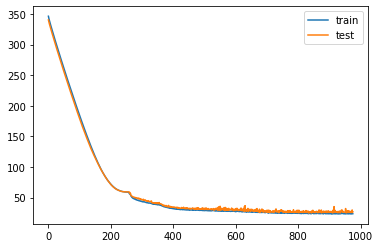


train_max_error: 135.69049072265625
test_max_error: 120.94495849609376
Train R2 = 0.80.
Test R2 = 0.72.

Epoch: 0, loss:124433.1406,  mae:345.4979,  mse:124433.1406,  val_loss:122997.2656,  val_mae:343.7927,  val_mse:122997.2656,  
....................................................................................................
Epoch: 100, loss:38718.5117,  mae:183.5847,  mse:38718.5039,  val_loss:38133.0078,  val_mae:182.5706,  val_mse:38133.0000,  
....................................................................................................
Epoch: 200, loss:7804.5605,  mae:72.0914,  mse:7804.5449,  val_loss:7472.0952,  val_mae:69.8550,  val_mse:7472.0801,  
....................................................................................................
Epoch: 300, loss:3069.2500,  mae:45.5138,  mse:3069.2385,  val_loss:2407.6270,  val_mae:38.7475,  val_mse:2407.6162,  
....................................................................................................


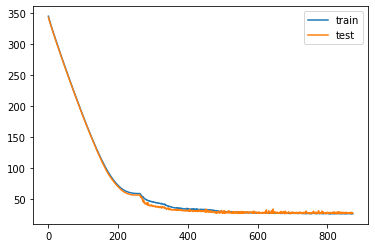


train_max_error: 159.17349243164062
test_max_error: 93.84257812499999
Train R2 = 0.73.
Test R2 = 0.75.

Epoch: 0, loss:124618.2500,  mae:345.8083,  mse:124618.2500,  val_loss:120173.4062,  val_mae:339.3170,  val_mse:120173.4062,  
....................................................................................................
Epoch: 100, loss:38939.8945,  mae:184.2824,  mse:38939.8828,  val_loss:36877.3633,  val_mae:178.4436,  val_mse:36877.3555,  
....................................................................................................
Epoch: 200, loss:7820.0947,  mae:71.7298,  mse:7820.0781,  val_loss:7279.4517,  val_mae:71.8782,  val_mse:7279.4370,  
....................................................................................................
Epoch: 300, loss:3017.6074,  mae:44.9045,  mse:3017.5957,  val_loss:2261.1472,  val_mae:40.2480,  val_mse:2261.1360,  
....................................................................................................
E

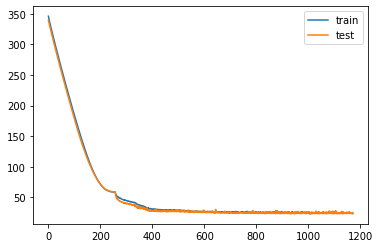


train_max_error: 158.20550537109375
test_max_error: 121.61923217773438
Train R2 = 0.77.
Test R2 = 0.79.

Epoch: 0, loss:124082.5391,  mae:344.9983,  mse:124082.5391,  val_loss:123726.8828,  val_mae:344.7785,  val_mse:123726.8828,  
....................................................................................................
Epoch: 100, loss:38612.5898,  mae:183.3128,  mse:38612.5742,  val_loss:38574.0547,  val_mae:183.6292,  val_mse:38574.0469,  
....................................................................................................
Epoch: 200, loss:7773.0044,  mae:71.9564,  mse:7772.9927,  val_loss:7648.1973,  val_mae:70.5385,  val_mse:7648.1831,  
....................................................................................................
Epoch: 300, loss:3110.6980,  mae:45.5691,  mse:3110.6870,  val_loss:3240.7473,  val_mae:46.9080,  val_mse:3240.7356,  
....................................................................................................


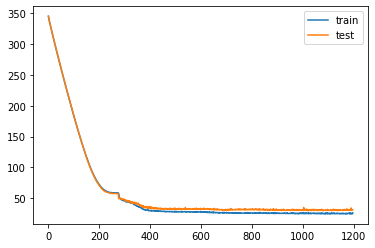


train_max_error: 161.07669067382812
test_max_error: 139.14561462402344
Train R2 = 0.76.
Test R2 = 0.64.
Units 2

Epoch: 0, loss:124105.7812,  mae:345.2691,  mse:124105.7812,  val_loss:124513.0938,  val_mae:344.3900,  val_mse:124513.0938,  
....................................................................................................
Epoch: 100, loss:53576.3438,  mae:220.6219,  mse:53576.3398,  val_loss:54439.0312,  val_mae:220.2878,  val_mse:54439.0273,  
....................................................................................................
Epoch: 200, loss:16723.6953,  mae:112.3528,  mse:16723.6836,  val_loss:17674.7363,  val_mae:115.6760,  val_mse:17674.7266,  
....................................................................................................
Epoch: 300, loss:5357.3711,  mae:59.3057,  mse:5357.3604,  val_loss:6367.8359,  val_mae:65.8606,  val_mse:6367.8271,  
.......................................................................................

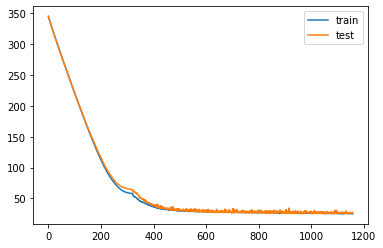


train_max_error: 150.9810791015625
test_max_error: 85.8140869140625
Train R2 = 0.77.
Test R2 = 0.81.

Epoch: 0, loss:124040.9219,  mae:344.8736,  mse:124040.9219,  val_loss:124691.2969,  val_mae:346.7188,  val_mse:124691.2969,  
....................................................................................................
Epoch: 100, loss:53549.6875,  mae:220.1011,  mse:53549.6797,  val_loss:54000.3008,  val_mae:222.5400,  val_mse:54000.2891,  
....................................................................................................
Epoch: 200, loss:16828.4531,  mae:112.5731,  mse:16828.4395,  val_loss:16747.5605,  val_mae:113.3933,  val_mse:16747.5508,  
....................................................................................................
Epoch: 300, loss:5560.5957,  mae:60.4535,  mse:5560.5864,  val_loss:5053.7822,  val_mae:58.3406,  val_mse:5053.7734,  
..................................................................................................

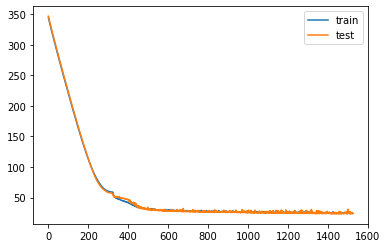


train_max_error: 140.06802368164062
test_max_error: 109.1568603515625
Train R2 = 0.80.
Test R2 = 0.77.

Epoch: 0, loss:124217.9688,  mae:345.3678,  mse:124217.9688,  val_loss:128574.8984,  val_mae:350.6160,  val_mse:128574.8984,  
....................................................................................................
Epoch: 100, loss:53683.0938,  mae:220.7754,  mse:53683.0898,  val_loss:56879.2383,  val_mae:226.3509,  val_mse:56879.2344,  
....................................................................................................
Epoch: 200, loss:16788.1621,  mae:113.0444,  mse:16788.1562,  val_loss:18753.0098,  val_mae:117.0521,  val_mse:18753.0020,  
....................................................................................................
Epoch: 300, loss:4794.9834,  mae:56.1259,  mse:4794.9751,  val_loss:6504.6060,  val_mae:65.1624,  val_mse:6504.5977,  
................................................................................................

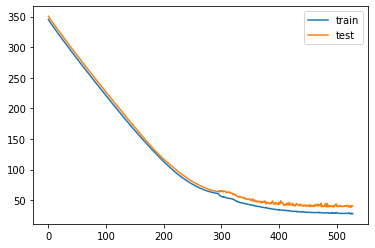


train_max_error: 130.43124389648438
test_max_error: 287.4814758300781
Train R2 = 0.74.
Test R2 = 0.34.

Epoch: 0, loss:124415.5547,  mae:345.3596,  mse:124415.5547,  val_loss:122079.9297,  val_mae:343.2993,  val_mse:122079.9297,  
....................................................................................................
Epoch: 100, loss:54179.6289,  mae:221.4319,  mse:54179.6172,  val_loss:52465.4297,  val_mae:219.6388,  val_mse:52465.4219,  
....................................................................................................
Epoch: 200, loss:17129.2578,  mae:113.7578,  mse:17129.2500,  val_loss:15835.0801,  val_mae:109.8981,  val_mse:15835.0713,  
....................................................................................................
Epoch: 300, loss:5625.7769,  mae:60.7547,  mse:5625.7681,  val_loss:4640.4966,  val_mae:56.5074,  val_mse:4640.4883,  
................................................................................................

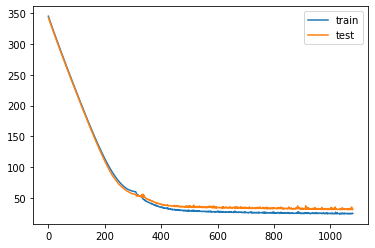


train_max_error: 148.21099853515625
test_max_error: 148.05691528320312
Train R2 = 0.80.
Test R2 = 0.56.

Epoch: 0, loss:125120.3203,  mae:346.5811,  mse:125120.3359,  val_loss:121612.7344,  val_mae:341.1869,  val_mse:121612.7188,  
....................................................................................................
Epoch: 100, loss:54453.8086,  mae:222.3774,  mse:54453.8047,  val_loss:52398.0352,  val_mae:217.2419,  val_mse:52398.0273,  
....................................................................................................
Epoch: 200, loss:17166.8398,  mae:113.8529,  mse:17166.8281,  val_loss:16275.4756,  val_mae:112.1762,  val_mse:16275.4639,  
....................................................................................................
Epoch: 300, loss:5499.5093,  mae:60.2227,  mse:5499.5005,  val_loss:5508.3242,  val_mae:60.0404,  val_mse:5508.3154,  
...............................................................................................

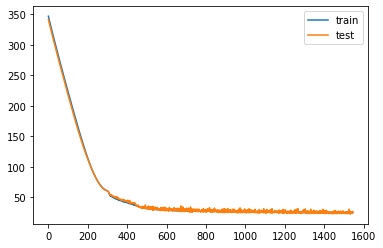


train_max_error: 146.22244262695312
test_max_error: 83.88288574218751
Train R2 = 0.78.
Test R2 = 0.78.

Epoch: 0, loss:124757.7422,  mae:345.9630,  mse:124757.7422,  val_loss:123711.3516,  val_mae:344.8309,  val_mse:123711.3516,  
....................................................................................................
Epoch: 100, loss:54081.5938,  mae:221.3989,  mse:54081.5898,  val_loss:53493.8516,  val_mae:220.6646,  val_mse:53493.8477,  
....................................................................................................
Epoch: 200, loss:17038.8926,  mae:113.5898,  mse:17038.8809,  val_loss:16629.3496,  val_mae:111.6978,  val_mse:16629.3398,  
....................................................................................................
Epoch: 300, loss:5538.3086,  mae:60.5876,  mse:5538.2974,  val_loss:5258.8843,  val_mae:57.6982,  val_mse:5258.8760,  
................................................................................................

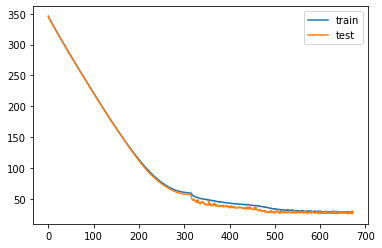


train_max_error: 171.06710815429688
test_max_error: 104.927001953125
Train R2 = 0.71.
Test R2 = 0.70.

Epoch: 0, loss:125208.5625,  mae:346.6714,  mse:125208.5625,  val_loss:121210.2656,  val_mae:340.8408,  val_mse:121210.2656,  
....................................................................................................
Epoch: 100, loss:54442.3516,  mae:222.3010,  mse:54442.3477,  val_loss:52015.4023,  val_mae:216.7491,  val_mse:52015.3945,  
....................................................................................................
Epoch: 200, loss:17174.6504,  mae:113.9684,  mse:17174.6387,  val_loss:16001.6621,  val_mae:110.3687,  val_mse:16001.6514,  
....................................................................................................
Epoch: 300, loss:5521.9692,  mae:60.1266,  mse:5521.9619,  val_loss:5325.1831,  val_mae:60.6629,  val_mse:5325.1748,  
.................................................................................................

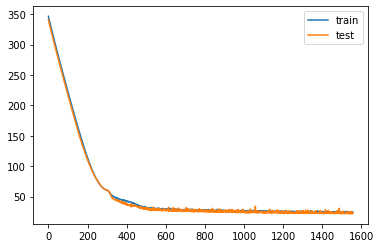


train_max_error: 142.78363037109375
test_max_error: 90.20208740234375
Train R2 = 0.79.
Test R2 = 0.83.

Epoch: 0, loss:124069.1172,  mae:344.9716,  mse:124069.1172,  val_loss:123799.8516,  val_mae:344.8820,  val_mse:123799.8516,  
....................................................................................................
Epoch: 100, loss:53461.2891,  mae:220.0235,  mse:53461.2773,  val_loss:53528.9297,  val_mae:220.6231,  val_mse:53528.9297,  
....................................................................................................
Epoch: 200, loss:16758.3574,  mae:112.5634,  mse:16758.3496,  val_loss:16703.0918,  val_mae:111.4120,  val_mse:16703.0820,  
....................................................................................................
Epoch: 300, loss:5503.0127,  mae:60.2693,  mse:5503.0034,  val_loss:5344.8730,  val_mae:59.0912,  val_mse:5344.8643,  
................................................................................................

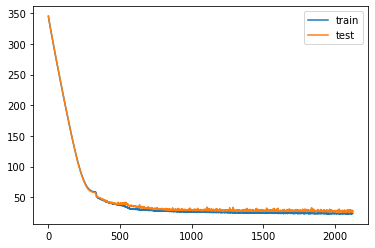


train_max_error: 139.61636352539062
test_max_error: 93.60150146484375
Train R2 = 0.81.
Test R2 = 0.76.


In [254]:
best_model = None
best_score = 10000000
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=51)
for units in range(20, 1, -1):
    print('Units ' + str(units))
    for train, test in kfold.split(X, y_binned):
        model = keras.Sequential()
        model.add(layers.Dense(units, activation='tanh', 
                               kernel_regularizer=regularizers.l2(1e-4),
                               bias_regularizer=regularizers.l2(1e-4),
                               activity_regularizer=regularizers.l2(1e-5),
                               input_shape=[len(predictors)]))
        model.add(layers.Dense(1))
#         model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(0.001), metrics=['mae', 'mse'])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['mae', 'mse'])
        
        early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
        history = model.fit(X[train], y[train], epochs=3000,
                              batch_size=10, verbose=0,
                              validation_data=(X[test], y[test]),
                              callbacks=[early_stop, tfdocs.modeling.EpochDots()])
        plt.plot(history.history['mae'], label='train')
        plt.plot(history.history['val_mae'], label='test')
        plt.legend()
        plt.show()
        train_predictions = model.predict(X[train])
        test_predictions = model.predict(X[test])
        print()
        print("train_max_error: {}".format(max_error(y[train], train_predictions)))
        print("test_max_error: {}".format(max_error(y[test], test_predictions)))
        print('Train R2 = {:0.2f}.'.format(r2_score(y[train], train_predictions)))
        print('Test R2 = {:0.2f}.'.format(r2_score(y[test], test_predictions)))

In [199]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
best_model = None
best_score = 10000000
X_train, X_test = None, None
y_train, y_test = None, None
mse_cvscores = []
mae_cvscores = []
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=52)
for train, test in kfold.split(X, y_binned):
    model = xgb.XGBRegressor()
    model.fit(X[train], y[train], eval_set=[(X[test], y[test])], eval_metric='rmse', early_stopping_rounds=3, verbose=0)
    train_predictions = model.predict(X[train])
    test_predictions = model.predict(X[test])
    print("train_mae: {}".format(mean_absolute_error(y[train], train_predictions)))
    score = mean_squared_error(y[test], test_predictions)
    mae = mean_absolute_error(y[test], test_predictions)
    print("test_mae: {}".format(mean_absolute_error(y[test], test_predictions)))
    print("train_max_error: {}".format(max_error(y[train], train_predictions)))
    print("test_max_error: {}".format(max_error(y[test], test_predictions)))
    print('Train R2 = {:0.2f}.'.format(r2_score(y[train], train_predictions)))
    print('Test R2 = {:0.2f}.'.format(r2_score(y[test], test_predictions)))
    print()
    mse_cvscores.append(score)
    mae_cvscores.append(mae)
    if score < best_score:
        X_train, y_train = X[train], y[train]
        X_test, y_test = X[test], y[test]
        best_model = model
        best_score = score
print("MSE {:.2f} (+/- {:.2f})".format(np.mean(mse_cvscores), np.std(mse_cvscores)))
print("MAE {:.2f} (+/- {:.2f})".format(np.mean(mae_cvscores), np.std(mae_cvscores)))

train_mae: 3.368818090446335
test_mae: 12.699429298849665
train_max_error: 17.0340576171875
test_max_error: 44.012487792968756
Train R2 = 0.99.
Test R2 = 0.82.

train_mae: 3.298660308760018
test_mae: 11.92693240464336
train_max_error: 21.031881713867193
test_max_error: 39.67746429443359
Train R2 = 0.98.
Test R2 = 0.86.

train_mae: 5.906358283552813
test_mae: 14.560274713689632
train_max_error: 24.845748901367188
test_max_error: 48.26233673095703
Train R2 = 0.96.
Test R2 = 0.64.

train_mae: 6.615218146471369
test_mae: 20.070666293519917
train_max_error: 38.29346466064453
test_max_error: 95.18946685791016
Train R2 = 0.94.
Test R2 = 0.42.

train_mae: 3.120391263401748
test_mae: 13.206670555345939
train_max_error: 19.07616424560547
test_max_error: 53.20867156982422
Train R2 = 0.99.
Test R2 = 0.73.

train_mae: 11.115406378590288
test_mae: 10.919032075477368
train_max_error: 53.91516876220703
test_max_error: 57.179771423339844
Train R2 = 0.85.
Test R2 = 0.84.

train_mae: 8.080435919009599
te

In [200]:
def get_parameters(dff):
    cc = dff[chemical_composition].to_dict()
    ht = dff[heat_treatment].to_dict()
    other = dff[other_predictors]
    params = {
        "chemicalComposition": cc,
        "heatTreatment": ht,
    }
    params.update(other)
    return params

min_values = df_before_scaling[predictors].min()
max_values = df_before_scaling[predictors].max()

In [201]:
conf = {
    "modelInput" : predictors,
    "minParams" : get_parameters(min_values),
    "maxParams" : get_parameters(max_values),
    "offset" : 0.5,
}
with open("k_model_conf.json", 'w') as f:
    json.dump(conf, f)

best_model.save_model("k_xgb.bin")

Max error 81.19888916015623 for (362.9, 281.7011)


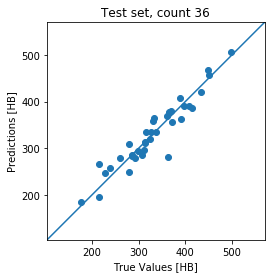

In [ ]:
test_predictions = best_model.predict(X_test)
print('Max error {} for {}'.format(max_error(y_test, test_predictions), str(find_max_error(y_test, test_predictions))))

a = plt.axes(aspect='equal')
plt.title('Test set, count {}'.format(y_test.shape[0]))
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [{}]'.format(target_column))
plt.ylabel('Predictions [{}]'.format(target_column))
lims = [min(y_test)-np.std(y_test), max(y_test)+np.std(y_test)]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Max error 36.911968994140636 for (277.2, 314.11197)


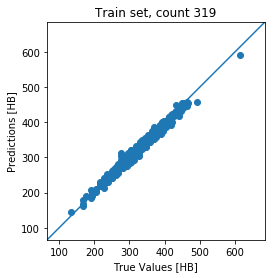

In [ ]:
train_predictions = best_model.predict(X_train)
print('Max error {} for {}'.format(max_error(y_train, train_predictions), str(find_max_error(y_train, train_predictions))))

a = plt.axes(aspect='equal')
plt.title('Train set, count {}'.format(y_train.shape[0]))
plt.scatter(y_train, train_predictions)
plt.xlabel('True Values [{}]'.format(target_column))
plt.ylabel('Predictions [{}]'.format(target_column))
lims = [min(y_train)-np.std(y_train), max(y_train)+np.std(y_train)]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

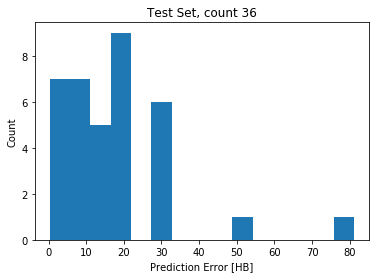

In [ ]:
test_error = abs(test_predictions - y_test)
# test_error = abs(test_predictions - y_test.reshape(-1, 1))
plt.hist(test_error, bins = 15)
plt.title('Test Set, count {}'.format(y_test.shape[0]))
plt.xlabel('Prediction Error [{}]'.format(target_column))
_ = plt.ylabel("Count")
plt.show()

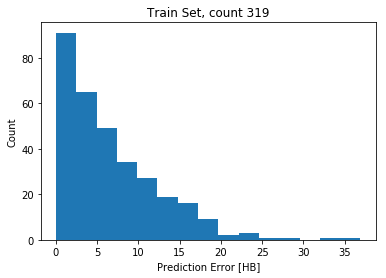

In [ ]:
train_error = abs(train_predictions - y_train)
# train_error = abs(train_predictions - y_train.reshape(-1, 1))
plt.hist(train_error, bins = 15)
plt.title('Train Set, count {}'.format(y_train.shape[0]))
plt.xlabel('Prediction Error [{}]'.format(target_column))
_ = plt.ylabel("Count")
plt.show()

In [ ]:
df_new = DataFrame()
df_new[target_column] = df_tmp[target_column]
df_new['{}_predicted'.format(target_column)] = df_tmp.apply(fill, axis = 1, args=(predictors, best_model))
df_new.to_csv('{}_predicted.csv'.format(target_column))


In [ ]:
df_new = DataFrame()
df_new[target_column] = df_tmp[target_column]
df_new['{}_predicted'.format(target_column)] = df_tmp.apply(fill, axis = 1, args=(predictors, best_model))
df_new.to_csv('{}_predicted.csv'.format(target_column))


In [ ]:
# train_error = abs(train_predictions - y_train)
train_error = abs(train_predictions - y_train.reshape(-1, 1))
plt.hist(train_error, bins = 15)
plt.title('Train Set, count {}'.format(y_train.shape[0]))
plt.xlabel('Prediction Error [{}]'.format(target_column))
_ = plt.ylabel("Count")
plt.show()

In [ ]:
df_new = DataFrame()
df_new[target_column] = df_tmp[target_column]
df_new['{}_predicted'.format(target_column)] = df_tmp.apply(fill, axis = 1, args=(predictors, best_model))
df_new.to_csv('{}_predicted.csv'.format(target_column))


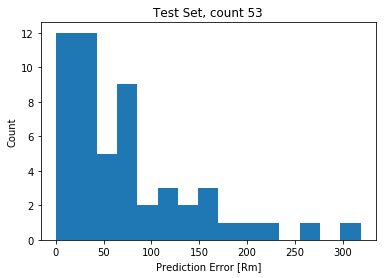

In [ ]:
df_new = DataFrame()
df_new[target_column] = df_tmp[target_column]
df_new['{}_predicted'.format(target_column)] = df_tmp.apply(fill, axis = 1, args=(predictors, best_model))
df_new.to_csv('{}_predicted.csv'.format(target_column))


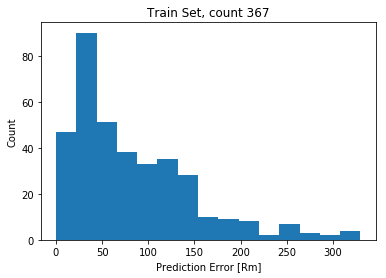

In [ ]:
# train_error = abs(train_predictions - y_train)
train_error = abs(train_predictions - y_train.reshape(-1, 1))
plt.hist(train_error, bins = 15)
plt.title('Train Set, count {}'.format(y_train.shape[0]))
plt.xlabel('Prediction Error [{}]'.format(target_column))
_ = plt.ylabel("Count")
plt.show()

In [ ]:
df_new = DataFrame()
df_new[target_column] = df_tmp[target_column]
df_new['{}_predicted'.format(target_column)] = df_tmp.apply(fill, axis = 1, args=(predictors, best_model))
df_new.to_csv('{}_predicted.csv'.format(target_column))
